Comp 47350 - Assignment 1  
Tania Lopes  
*18389156*

# Introduction
Refer to '18389156_Data Quality Report' for a brief introduction to the machine learning problem we would like to solve in addition to some key terminology to be familiar with.

# Exercise 1 - Prepare a **Data Quality Report** for the CSV File

## Prepare environment and load data

First things first, we need to import the packages that will helpus with our data analysis.

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

In [155]:
from sklearn.impute import KNNImputer

Additionally, we need to load in our CSV

In [156]:
data = pd.read_csv('data\covid19-cdc-18389156.csv', keep_default_na=True)

### Define Some Functions that will help us throughout the Data Quality Report and Action Plan

In [157]:
def calculateNthMode(dataFrame, n):
    describeData = dataFrame.describe(datetime_is_numeric = True).T

    indices = describeData.index.values.tolist()

    secondMode = []
    secondModeFreq = []
    
    for column in dataFrame:
        secondMode.append(dataFrame[column].value_counts().index.tolist()[n-1])
        secondModeFreq.append(dataFrame[column].value_counts().tolist()[n-1])

    second_mode = pd.DataFrame(secondMode, columns=[f'{n}th mode']).set_index([indices]).T
    second_mode_freq = pd.DataFrame(secondModeFreq, columns=[f'{n}th mode freq']).set_index([indices]).T

    return second_mode, second_mode_freq


def applyToRowsAndAppend(dataFrame, expression, columnName):
    tempDataFrame_result = dataFrame.apply(expression, axis=1).rename(columnName)
    tempDataFrame = pd.concat([dataFrame, tempDataFrame_result], axis=1)
    return tempDataFrame


def getDescriptiveStatisticsForContinuousFeatures(dataFrame):
    # Get descriptive statistics, mode, second mode, and cardinality
    stats = dataFrame.describe(datetime_is_numeric = True)

    n_missing = pd.DataFrame((dataFrame.isnull()).sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame.isnull()).sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    first_mode, first_modeFreq = calculateNthMode(dataFrame, 1)
    second_mode, second_modeFreq = calculateNthMode(dataFrame, 2)
    cardinality = pd.DataFrame(dataFrame.nunique(), columns=['cardinality']).T

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, first_mode, first_modeFreq, second_mode, second_modeFreq, cardinality]).T

    return stats


def getDescriptiveStatisticsForCategoricalFeatures(dataFrame):
    # Calculate the number of missing entries for each of the continuous feature
    stats = dataFrame.describe()

    n_missing = pd.DataFrame((dataFrame == 'Missing').sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame == 'Missing').sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    # Calculate second mode
    second_mode, second_mode_frequency = calculateNthMode(dataFrame, 2)

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, second_mode, second_mode_frequency]).T

    return stats


def getValidityColumn(dataFrame, expression):
    validity_result = applyToRowsAndAppend(dataFrame, expression, 'Validity')
    
    # Count the number of columns where validity is not equal to True
    invalid_entry = validity_result['Validity'].value_counts().index.tolist()

    if len(invalid_entry) == 1 and invalid_entry[0]:
        print("The data passes the test.")
    else:
        count_invalid_entry = len(validity_result.loc[validity_result['Validity'] == False])
        print(f"The data does not pass the test. \n{count_invalid_entry} invalid entries.")

### Shape
Let's check the shape of the CSV file; this will give us the number of features and entries contained in the data set to start.

In [158]:
def getShape(dataframe):
    length, cardinality = dataframe.shape
    print(f"The dataset has {length} entries, with {cardinality} features per entry.")

getShape(data)

The dataset has 20000 entries, with 19 features per entry.


$~$
###  Preview Data
To get an idea of the features and entries in the data set, let's print the first and last 5 rows of the data set.

In [159]:
data.head(5)

case_month res_state  state_fips_code res_county  county_fips_code  \
0    2020-12        MD             24.0  FREDERICK           24021.0   
1    2021-12        CA              6.0     ORANGE            6059.0   
2    2020-01        GA             13.0        NaN               NaN   
3    2020-11        KS             20.0   SEDGWICK           20173.0   
4    2020-07        TX             48.0     HARRIS           48201.0   

   age_group   sex     race            ethnicity  \
0  65+ years  Male    White  Non-Hispanic/Latino   
1  65+ years  Male    White  Non-Hispanic/Latino   
2        NaN   NaN      NaN                  NaN   
3  65+ years  Male  Unknown                  NaN   
4  65+ years  Male    White  Non-Hispanic/Latino   

   case_positive_specimen_interval  case_onset_interval              process  \
0                              NaN                  NaN              Missing   
1                              NaN                  NaN              Missing   
2                              NaN                  NaN              Missing   
3                              NaN                  0.0  Laboratory reported   
4                              NaN                  NaN              Missing   

  exposure_yn             current_status symptom_status  hosp_yn   icu_yn  \
0     Missing  Laboratory-confirmed case        Missing  Missing  Missing   
1     Missing  Laboratory-confirmed case    Symptomatic      Yes  Missing   
2     Missing  Laboratory-confirmed case        Missing  Missing  Missing   
3         Yes  Laboratory-confirmed case    Symptomatic      Yes      Yes   
4     Missing  Laboratory-confirmed case        Missing      Yes  Missing   

  death_yn underlying_conditions_yn  
0      Yes                      NaN  
1      Yes                      NaN  
2      Yes                      NaN  
3      Yes                      NaN  
4      Yes                      NaN

In [160]:
data.tail(5)

case_month res_state  state_fips_code res_county  county_fips_code  \
19995    2021-12        FL             12.0    BROWARD           12011.0   
19996    2021-01        WI             55.0  OUTAGAMIE           55087.0   
19997    2021-03        FL             12.0       LEON           12073.0   
19998    2021-12        TN             47.0   DAVIDSON           47037.0   
19999    2021-04        AZ              4.0   MARICOPA            4013.0   

            age_group     sex   race            ethnicity  \
19995  18 to 49 years    Male  Black  Non-Hispanic/Latino   
19996  50 to 64 years  Female  White  Non-Hispanic/Latino   
19997  18 to 49 years  Female  White      Hispanic/Latino   
19998    0 - 17 years  Female    NaN                  NaN   
19999  18 to 49 years  Female  Asian  Non-Hispanic/Latino   

       case_positive_specimen_interval  case_onset_interval  process  \
19995                              0.0                  0.0  Missing   
19996                              NaN                  0.0  Missing   
19997                              NaN                  NaN  Missing   
19998                              1.0                  0.0  Missing   
19999                              NaN                  0.0  Missing   

      exposure_yn             current_status symptom_status hosp_yn   icu_yn  \
19995     Missing  Laboratory-confirmed case    Symptomatic      No  Missing   
19996     Missing  Laboratory-confirmed case    Symptomatic      No  Missing   
19997     Missing  Laboratory-confirmed case        Missing      No  Missing   
19998     Missing  Laboratory-confirmed case    Symptomatic      No  Missing   
19999     Missing  Laboratory-confirmed case    Symptomatic      No  Missing   

      death_yn underlying_conditions_yn  
19995       No                      NaN  
19996       No                      NaN  
19997       No                      NaN  
19998       No                      NaN  
19999       No                      NaN

## Scrub Extra White Space

It is possible for the column names to contain extra undesirable characters. We should check for it and remove if necessary.

In [161]:
data.columns

Index(['case_month', 'res_state', 'state_fips_code', 'res_county',
       'county_fips_code', 'age_group', 'sex', 'race', 'ethnicity',
       'case_positive_specimen_interval', 'case_onset_interval', 'process',
       'exposure_yn', 'current_status', 'symptom_status', 'hosp_yn', 'icu_yn',
       'death_yn', 'underlying_conditions_yn'],
      dtype='object')

The columns names don't contain extra white space. No further action is needed.

## Feature Data Types
We should convert features to appropriate data types. To view their python data types, we call data.dtypes.

In [162]:
data.dtypes

case_month                          object
res_state                           object
state_fips_code                    float64
res_county                          object
county_fips_code                   float64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
process                             object
exposure_yn                         object
current_status                      object
symptom_status                      object
hosp_yn                             object
icu_yn                              object
death_yn                            object
underlying_conditions_yn            object
dtype: object

Upon examining the data and reviewing the **Data Dictionary** provided alongside it, **17** features will be considered categorical and **3** features will be considered continuous.

- *CaseMonth* will be converted to **continuous** because it contains over 10 possible values, a range of months between January 2020 and November 2022. However, these will not be stored as Int64s like the other two continuous features.
- *Positive Specimen Interval* column will be converted to **continuous** because it is calculated based on two dates, and can have over 10 possible values.
- *Case Onset Interval* column will be converted to **continuous** because it is calculated based on two dates, and can have over 10 possible values.

| Feature | Type of Feature |
|---------|-----------------|
| Case Month| Continuous    |
| State of Residence | Categorical    |
| State of FIPS Code | Categorical    |
| County of Residence | Categorical    |
| County of FIPS Code | Categorical    |
| Age Group | Categorical    |
| Sex | Categorical    |
| Race | Categorical    |
| Ethnicity | Categorical    |
| Positive Specimen Interval  | Continuous    |
| Case Onset Interval | Continuous    |
| Case Identification Process | Categorical    |
| Exposure | Categorical    |
| Current Status | Categorical    |
| Symptom Status| Categorical    |
| Hospitalization | Categorical    |
| ICU Stay | Categorical    |
| Death | Categorical    |
| Underlying Conditions | Categorical    |


In [163]:
categorical_data = data[['res_state', 'state_fips_code', 'res_county', 'county_fips_code', 'age_group', 'sex', 'race', 'ethnicity', 'process', 'exposure_yn', 'current_status', 'symptom_status', 'hosp_yn', 'icu_yn', 'death_yn', 'underlying_conditions_yn']].columns
continuous_data_ints = data[['case_positive_specimen_interval', 'case_onset_interval']].columns
continuous_data_dates = data[['case_month']].columns

for column in categorical_data:
    data[column] = data[column].astype('category')

for column in continuous_data_ints:
    data[column] = data[column].astype('Int64')

The *case_month* column needs to be treated a bit differently. It is a continuous data type but cannot be stored as an int. We can try storing it as a datetime64.

In [164]:
for column in continuous_data_dates:
    data[column] = data[column].astype('datetime64[ns]')

This works. Once these change have been made, we can check the datatypes by calling data.dtypes once again.

In [165]:
data.dtypes

case_month                         datetime64[ns]
res_state                                category
state_fips_code                          category
res_county                               category
county_fips_code                         category
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
process                                  category
exposure_yn                              category
current_status                           category
symptom_status                           category
hosp_yn                                  category
icu_yn                                   category
death_yn                                 category
underlying_conditions_yn                 category
dtype: object

Note that the res_state and res_county have been ignored because the data they capture is already reflected in the state_fips_code and county_fips_code respectively.

## Duplicates
We should now check the data set for duplicate entries.

In [166]:
getShape(data)
print(f"There are {data.duplicated(keep=False).sum()} rows with duplicate data.")

duplicateData = data[data.duplicated(keep=False)].sort_values(by=['case_month', 'age_group', 'ethnicity'], inplace=False)
duplicateData.head(10)

The dataset has 20000 entries, with 19 features per entry.
There are 1842 rows with duplicate data.


case_month res_state state_fips_code   res_county county_fips_code  \
1577 2020-03-01        NJ            34.0        ESSEX          34013.0   
1866 2020-03-01        NJ            34.0        ESSEX          34013.0   
4830 2020-03-01        IL            17.0         COOK          17031.0   
4868 2020-03-01        IL            17.0         COOK          17031.0   
756  2020-03-01        CA             6.0  LOS ANGELES           6037.0   
1230 2020-03-01        CA             6.0  LOS ANGELES           6037.0   
2193 2020-03-01        CA             6.0  LOS ANGELES           6037.0   
4038 2020-03-01        CA             6.0  LOS ANGELES           6037.0   
504  2020-03-01        NY            36.0        KINGS          36047.0   
1386 2020-03-01        NY            36.0        KINGS          36047.0   

           age_group     sex   race            ethnicity  \
1577  50 to 64 years    Male  White  Non-Hispanic/Latino   
1866  50 to 64 years    Male  White  Non-Hispanic/Latino   
4830  50 to 64 years    Male  White  Non-Hispanic/Latino   
4868  50 to 64 years    Male  White  Non-Hispanic/Latino   
756        65+ years    Male  White      Hispanic/Latino   
1230       65+ years  Female  White      Hispanic/Latino   
2193       65+ years    Male  White      Hispanic/Latino   
4038       65+ years  Female  White      Hispanic/Latino   
504        65+ years  Female  Black  Non-Hispanic/Latino   
1386       65+ years  Female  Black  Non-Hispanic/Latino   

      case_positive_specimen_interval  case_onset_interval  process  \
1577                             <NA>                    0  Missing   
1866                             <NA>                    0  Missing   
4830                             <NA>                    0  Missing   
4868                             <NA>                    0  Missing   
756                              <NA>                    0  Missing   
1230                             <NA>                    0  Missing   
2193                             <NA>                    0  Missing   
4038                             <NA>                    0  Missing   
504                                 0                 <NA>  Missing   
1386                                0                 <NA>  Missing   

     exposure_yn             current_status symptom_status hosp_yn   icu_yn  \
1577     Missing  Laboratory-confirmed case    Symptomatic     Yes  Missing   
1866     Missing  Laboratory-confirmed case    Symptomatic     Yes  Missing   
4830     Missing  Laboratory-confirmed case        Missing     Yes  Missing   
4868     Missing  Laboratory-confirmed case        Missing     Yes  Missing   
756      Missing  Laboratory-confirmed case    Symptomatic     Yes      Yes   
1230     Missing  Laboratory-confirmed case    Symptomatic     Yes      Yes   
2193     Missing  Laboratory-confirmed case    Symptomatic     Yes      Yes   
4038     Missing  Laboratory-confirmed case    Symptomatic     Yes      Yes   
504      Missing  Laboratory-confirmed case        Unknown     Yes  Unknown   
1386     Missing  Laboratory-confirmed case        Unknown     Yes  Unknown   

     death_yn underlying_conditions_yn  
1577      Yes                      NaN  
1866      Yes                      NaN  
4830      Yes                      NaN  
4868      Yes                      NaN  
756       Yes                      NaN  
1230      Yes                      NaN  
2193      Yes                      NaN  
4038      Yes                      NaN  
504       Yes                      Yes  
1386      Yes                      Yes

In [167]:
data_transposed = data.transpose()
getShape(data_transposed)
print(f"There are {data_transposed.duplicated(keep=False).sum()} columns with duplicate data.")

The dataset has 19 entries, with 20000 features per entry.
There are 0 columns with duplicate data.


#### Rows
Since there is no primary key to establish whether or not a patient has been included twice, we should use pandas' duplicate function to check for duplicates using all of the features for an entry. 

Pandas has indicated that there are 1849 instances of duplicate entries. We can create a table showing only the identified duplicates and sort them by a few identifying features ('case_month', 'age_group', 'ethnicity') to verify that the rows are indeed duplicates. We can safely drop the duplicate entries.

#### Columns
While there are no duplicate columns, we have instances of column pairs giving us the same information. These pairs are:
+ ('res_state', 'state_fips_code')
+ ('res_county', 'res_county_fips_code')

This means that we can also safely drop 'res_state' and 'res_county', preserving 'state_fips_code' and 'res_county_fips_code'.

In [168]:
data.drop_duplicates(keep='first', inplace=True)
data.drop(columns=['res_state', 'res_county'])
getShape(data)

The dataset has 18976 entries, with 19 features per entry.


## Constant Columns

After removing duplicates, we should check if there are any constant columns in both the categorical and continuous features. In other words, we can create a table of descriptive statistics to check if there are any features that only have 1 unique value.

#### Categorical Features

In [169]:
# Check the categorical features
data.select_dtypes(['category']).describe().transpose()

count  unique                        top    freq
res_state                   18976      48                         NY    1894
state_fips_code           18976.0    48.0                       36.0  1894.0
res_county                  17799     864                 MIAMI-DADE     367
county_fips_code          17799.0  1199.0                    12086.0   367.0
age_group                   18858       5             18 to 49 years    7317
sex                         18594       4                     Female    9637
race                        16700       8                      White   11743
ethnicity                   16495       4        Non-Hispanic/Latino   11396
process                     18976       9                    Missing   17179
exposure_yn                 18976       3                    Missing   16257
current_status              18976       2  Laboratory-confirmed case   16040
symptom_status              18976       4                Symptomatic    8934
hosp_yn                     18976       4                         No    9407
icu_yn                      18976       4                    Missing   14663
death_yn                    18976       2                         No   14373
underlying_conditions_yn     1816       2                        Yes    1783

There are no constant columns, as each column has at least 2 unique values.

#### Continous Features - Ints & DateTime

In [170]:
continuous_data = continuous_data_ints.append(continuous_data_dates)
data[continuous_data].describe(datetime_is_numeric=True)

case_positive_specimen_interval  case_onset_interval  \
count                          10195.0               8498.0   
mean                          0.179696            -0.015062   
min                              -62.0                -50.0   
25%                                0.0                  0.0   
50%                                0.0                  0.0   
75%                                0.0                  0.0   
max                               70.0                 52.0   
std                           2.120946             1.574111   

                          case_month  
count                          18976  
mean   2021-06-05 13:42:08.499156992  
min              2020-01-01 00:00:00  
25%              2020-12-01 00:00:00  
50%              2021-07-01 00:00:00  
75%              2022-01-01 00:00:00  
max              2022-11-01 00:00:00  
std                              NaN

There are no constant columns, as the min and max are different for each column.

## Null Values

To look for null values in the data, we can begin by using the Pandas .isnull method. This should return True for any value that has been defined as null.

In [171]:
data.isnull()

case_month  res_state  state_fips_code  res_county  county_fips_code  \
0           False      False            False       False             False   
1           False      False            False       False             False   
2           False      False            False        True              True   
3           False      False            False       False             False   
4           False      False            False       False             False   
...           ...        ...              ...         ...               ...   
19995       False      False            False       False             False   
19996       False      False            False       False             False   
19997       False      False            False       False             False   
19998       False      False            False       False             False   
19999       False      False            False       False             False   

       age_group    sex   race  ethnicity  case_positive_specimen_interval  \
0          False  False  False      False                             True   
1          False  False  False      False                             True   
2           True   True   True       True                             True   
3          False  False  False       True                             True   
4          False  False  False      False                             True   
...          ...    ...    ...        ...                              ...   
19995      False  False  False      False                            False   
19996      False  False  False      False                             True   
19997      False  False  False      False                             True   
19998      False  False   True       True                            False   
19999      False  False  False      False                             True   

       case_onset_interval  process  exposure_yn  current_status  \
0                     True    False        False           False   
1                     True    False        False           False   
2                     True    False        False           False   
3                    False    False        False           False   
4                     True    False        False           False   
...                    ...      ...          ...             ...   
19995                False    False        False           False   
19996                False    False        False           False   
19997                 True    False        False           False   
19998                False    False        False           False   
19999                False    False        False           False   

       symptom_status  hosp_yn  icu_yn  death_yn  underlying_conditions_yn  
0               False    False   False     False                      True  
1               False    False   False     False                      True  
2               False    False   False     False                      True  
3               False    False   False     False                      True  
4               False    False   False     False                      True  
...               ...      ...     ...       ...                       ...  
19995           False    False   False     False                      True  
19996           False    False   False     False                      True  
19997           False    False   False     False                      True  
19998           False    False   False     False                      True  
19999           False    False   False     False                      True  

[18976 rows x 19 columns]

Looking at these results, and comparing them to the raw .csv data, we can see that there are other fields with missing data that have not been captured because they are not **null** in the strictest sense. Rather, they are empty fields or have simply been indicated as missing in some way. To find all of these values, we can print all of the unique values for each column.

Function to print all unique values by column, sorted for readability.

In [172]:
def printUniqueValuesbyColumn(dataframe):
    for column in dataframe.columns:
        print("Unique Values for", column)
        sortedValues = dataframe[column].sort_values().unique().tolist()
        if len(sortedValues) > 10:
            print(sortedValues[-10:-1], "...\nValue Count:", len(sortedValues), "\n")
        else:
            print(sortedValues, "\nValue Count:", len(sortedValues), "\n")

printUniqueValuesbyColumn(data)

Unique Values for case_month
[1643673600000000000, 1646092800000000000, 1648771200000000000, 1651363200000000000, 1654041600000000000, 1656633600000000000, 1659312000000000000, 1661990400000000000, 1664582400000000000] ...
Value Count: 35 

Unique Values for res_state
['SC', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI'] ...
Value Count: 48 

Unique Values for state_fips_code
[47.0, 48.0, 49.0, 50.0, 51.0, 53.0, 55.0, 56.0, 72.0] ...
Value Count: 48 

Unique Values for res_county
['YADKIN', 'YAKIMA', 'YAMHILL', 'YATES', 'YAVAPAI', 'YELL', 'YELLOWSTONE', 'YORK', 'YUMA'] ...
Value Count: 865 

Unique Values for county_fips_code
[56001.0, 56005.0, 56013.0, 56021.0, 56025.0, 56029.0, 56037.0, 56039.0, 56041.0] ...
Value Count: 1200 

Unique Values for age_group
['0 - 17 years', '18 to 49 years', '50 to 64 years', '65+ years', 'Missing', nan] 
Value Count: 6 

Unique Values for sex
['Female', 'Male', 'Missing', 'Unknown', nan] 
Value Count: 5 

Unique Values for race
['American Indian/Alas

The following values have been identified as invalid data:
* NaN
* Missing
* Unknown
* \<NA\> (only for continuous integer data types)

"NaN", "Missing", and "Unknown" will all be replaced with "Missing"  
\<NA\> values in integer data types will remain as \<NA\>

In [173]:
for column in categorical_data:
    if 'Missing' not in data[column].cat.categories.to_list():
        data[column] = data[column].cat.add_categories(['Missing'])

    data[column] = data[column].fillna('Missing')
    data[column] = data[column].replace(to_replace='Unknown', value='Missing')

data.isnull().sum()

case_month                             0
res_state                              0
state_fips_code                        0
res_county                             0
county_fips_code                       0
age_group                              0
sex                                    0
race                                   0
ethnicity                              0
case_positive_specimen_interval     8781
case_onset_interval                10478
process                                0
exposure_yn                            0
current_status                         0
symptom_status                         0
hosp_yn                                0
icu_yn                                 0
death_yn                               0
underlying_conditions_yn               0
dtype: int64

Now, all of the null, NAN, missing, and unkown features have been converted to "Missing" for categorical values, and thus summing null values returns 0 for all categorical features.

The continuous features hold on to their null values, as this is how we're handling missing data for integers and dates.

## Statistics
### Continuous Features

#### Print Descriptive Statistics

The continuous are now categorized by data type, and null values have been identified. It is now possible to determine the following:
* Bounds for the feature (minimum and maximum values)
* Distribution of the values of the feature
* Cardinality, or number of unique values

In [174]:
# # Display the set of descriptive statistics for each continuous feature
describe_continuous_data = getDescriptiveStatisticsForContinuousFeatures(data[continuous_data])
describe_continuous_data

count                           mean  \
case_positive_specimen_interval  10195.0                       0.179696   
case_onset_interval               8498.0                      -0.015062   
case_month                         18976  2021-06-05 13:42:08.499156992   

                                                 min                  25%  \
case_positive_specimen_interval                -62.0                  0.0   
case_onset_interval                            -50.0                  0.0   
case_month                       2020-01-01 00:00:00  2020-12-01 00:00:00   

                                                 50%                  75%  \
case_positive_specimen_interval                  0.0                  0.0   
case_onset_interval                              0.0                  0.0   
case_month                       2021-07-01 00:00:00  2022-01-01 00:00:00   

                                                 max       std # missing  \
case_positive_specimen_interval                 70.0  2.120946      8781   
case_onset_interval                             52.0  1.574111     10478   
case_month                       2022-11-01 00:00:00       NaN         0   

                                 % missing             1th mode 1th mode freq  \
case_positive_specimen_interval  46.274241                    0          8998   
case_onset_interval              55.217116                    0          8195   
case_month                             0.0  2022-01-01 00:00:00          2417   

                                            2th mode 2th mode freq cardinality  
case_positive_specimen_interval                    1           950          47  
case_onset_interval                               -1           164          36  
case_month                       2020-12-01 00:00:00          1547          35

**Running Assessment**

For the case_positive_specimen_interval and the case_onset_interval, the 1st, 2nd, and 3rd quartile numbers are all 0, which already begins to indicate that there could be some outliers. We will further examine this in the visualizations of the features.

#### Logical Integrity

**Test 1:** Case positive specimen interval should not be negative, so we check for negative values.

In [175]:
count_neg_case_pos_spec = data['case_positive_specimen_interval'].loc[data['case_positive_specimen_interval'] < 0].count()

# Test whether the number of symptomatic patients is greater than the number of hospitalized patients.
print(f"There are {count_neg_case_pos_spec} patients with negative case_positive_specimen_intervals.")
if count_neg_case_pos_spec <= 0:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

There are 51 patients with negative case_positive_specimen_intervals.
The data does not pass the test.


It's likely that for the 44 patients where these numbers are negative, the two dates used to calculate the interval were switched in the calculation. If this is the case, simply taking the absolute value of the data would be enough to correct the data.

**Test 2:** Case onset interval is should not be negative, so we check for negative values.

In [176]:
count_neg_case_onset = data['case_onset_interval'].loc[data['case_onset_interval'] < 0].count()

# Test whether the number of symptomatic patients is greater than the number of hospitalized patients.
print(f"There are {count_neg_case_onset} patients with negative case_onset_interval.")
if count_neg_case_onset <= 0:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

There are 255 patients with negative case_onset_interval.
The data does not pass the test.


It's likely that for the 249 patients where these numbers are negative, the two dates used to calculate the interval were switched in the calculation. If this is the case, simply taking the absolute value of the data would be enough to correct the data.

**Test 3:** Assuming all case_positive_specimen_intervals are positive, the absolute value should not be greater than the number of weeks between the earliest case month and the latest case month.   
The data is given to us in months, so we will perform all calculations using the first of the month.

In [177]:
# Calculate the range of dates in the dataset.
days_in_range = data['case_month'].sort_values(ascending=False).tolist()[0] -  data['case_month'].sort_values().tolist()[0]
weeks_in_range = days_in_range / np.timedelta64(1, 'W')

# Find the absolute value of the case_positive_specimen_interval
abs_case_pos_spec = pd.DataFrame(data['case_positive_specimen_interval'].apply(lambda interval: abs(interval)))

# Count intervals greater than dataset date range.
count_large_case_pos_spec_interval = len(abs_case_pos_spec.loc[abs_case_pos_spec['case_positive_specimen_interval'] > weeks_in_range])

# Test whether the the case_positive_specimen_interval is greater than the number of total weeks in the data set.
print(f"There are {count_large_case_pos_spec_interval} patients with case_positive_specimen_interval larger than the number of weeks in the range.")
if count_large_case_pos_spec_interval <= 0:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

There are 0 patients with case_positive_specimen_interval larger than the number of weeks in the range.
The data passes the test.


**Test 4:** Assuming all case_onset_intervals are positive, the absolute value should not be greater than the number of weeks between the earliest case month and its own case month.

In [178]:
# Find the absolute value of the case_onset_interval
abs_case_onset_spec = pd.DataFrame(data['case_onset_interval'].apply(lambda interval: abs(interval)))

# Count intervals greater than dataset date range.
count_large_case_pos_spec_interval = len(abs_case_onset_spec.loc[abs_case_onset_spec['case_onset_interval'] > weeks_in_range])

# Test whether the the case_positive_specimen interval is greater than the number of total weeks in the data set.
print(f"There are {count_large_case_pos_spec_interval} patients with case_onset_interval larger than the number of weeks in the range.")
if count_large_case_pos_spec_interval <= 0:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

There are 0 patients with case_onset_interval larger than the number of weeks in the range.
The data passes the test.


**Test 5:** There should only be a case_positive_specimen_interval for patients who tested positive and as such whose current status is Laboratory-confirmed case.

In [179]:
# Create a table with just the case_positive_specimen_interval and current_status columns
pos_spec_current_status_comparison_table = pd.DataFrame([data['case_positive_specimen_interval'], data['current_status']]).T

# Check whether for each entry into the hospital the patient was indicated as symptomatic, store this value in a column named 'validity' 
pos_spec_current_status_comparison_result = pos_spec_current_status_comparison_table.apply(lambda row: \
        row['current_status'] == 'Laboratory-confirmed case' \
        if type(row['case_positive_specimen_interval']) == int  \
        else True, axis=1).rename('validity')
pos_spec_current_status_comparison_result = pd.concat([pos_spec_current_status_comparison_table, pos_spec_current_status_comparison_result], axis=1)
pos_spec_current_status_comparison_result

case_positive_specimen_interval             current_status  validity
0                                <NA>  Laboratory-confirmed case      True
1                                <NA>  Laboratory-confirmed case      True
2                                <NA>  Laboratory-confirmed case      True
3                                <NA>  Laboratory-confirmed case      True
4                                <NA>  Laboratory-confirmed case      True
...                               ...                        ...       ...
19995                               0  Laboratory-confirmed case      True
19996                            <NA>  Laboratory-confirmed case      True
19997                            <NA>  Laboratory-confirmed case      True
19998                               1  Laboratory-confirmed case      True
19999                            <NA>  Laboratory-confirmed case      True

[18976 rows x 3 columns]

In [180]:
# Count the number of columns where validity is not equal to True
invalid_pos_spec_entry = pos_spec_current_status_comparison_result['validity'].value_counts().index.tolist()

if len(invalid_pos_spec_entry) == 1 and invalid_pos_spec_entry[0]:
    print("The data passes the test.")
else:
    count_invalid_onset_sympotmatic_entry = len(pos_spec_current_status_comparison_result.loc[pos_spec_current_status_comparison_result['validity'] == False])
    print(f"The data does not pass the test. \n{count_invalid_onset_sympotmatic_entry} instances of patients with positive_specimen_intervals but who were not 'Laboratory confirmed cases'.")

The data does not pass the test. 
1693 instances of patients with positive_specimen_intervals but who were not 'Laboratory confirmed cases'.


**Test 6:** There should only be a case_onset_interval for patients with symptoms and as such whose symptom_status is 'Symptomatic'

In [181]:
# Create a table with just the case_positive_specimen_interval and current_status columns
onset_symptomatic_comparison_table = pd.DataFrame([data['case_onset_interval'], data['symptom_status']]).T

# Check whether for each entry with a case_onset_interval, the patient was indicated as symptomatic, store this value in a column named 'validity' 
onset_symptomatic_comparison_result = onset_symptomatic_comparison_table.apply(lambda row: \
        row['symptom_status'] == 'Symptomatic' \
        if type(row['case_onset_interval']) == int  \
        else True, axis=1).rename('validity')
onset_symptomatic_comparison_result = pd.concat([onset_symptomatic_comparison_table, onset_symptomatic_comparison_result], axis=1)

onset_symptomatic_comparison_result

case_onset_interval symptom_status  validity
0                    <NA>        Missing      True
1                    <NA>    Symptomatic      True
2                    <NA>        Missing      True
3                       0    Symptomatic      True
4                    <NA>        Missing      True
...                   ...            ...       ...
19995                   0    Symptomatic      True
19996                   0    Symptomatic      True
19997                <NA>        Missing      True
19998                   0    Symptomatic      True
19999                   0    Symptomatic      True

[18976 rows x 3 columns]

In [182]:
# Count the number of columns where validity is not equal to True
invalid_onset_sympotmatic_entry = onset_symptomatic_comparison_result['validity'].value_counts().index.tolist()

if len(invalid_onset_sympotmatic_entry) == 1 and invalid_onset_sympotmatic_entry[0]:
    print("The data passes the test.")
else:
    count_invalid_onset_sympotmatic_entry = len(onset_symptomatic_comparison_result.loc[onset_symptomatic_comparison_result['validity'] == False])
    print(f"The data does not pass the test. \n{count_invalid_onset_sympotmatic_entry} instances of patients with onset intervals but who were considered asymptomatic.")

The data does not pass the test. 
231 instances of patients with onset intervals but who were considered asymptomatic.


**Running Assessment**

The continuous features do seem to contain some invalid data.
* A small fraction of patients had impossible negative values for *case_onset_* and *case_positive_specimen_interval*:
    * 44 patients had negative *case_positive_specimen_interval*.
    * 249 has negative *case_onset_interval*.
* Impossible values:
    * No instances of *case_positive_specimen_interval* larger than the range of the dataset.
    * No instances of *cast_onset_interval* larger than the range of the dataset.
* Inconsistent values:
    * 1647 instances of a patient with a *case_positive_specimen_interval* without having a *'current_status'* of 'Laboratory-confirmed case'.
    * 212 instances of a patient with a *case_onset_interval* without having a *'symptom_status'* of  'Symptomatic'.

Steps to address these will be discussed further in the Data Action Plan.

#### Plots

**Histograms:**

min: -62 max 70
min: -50 max 52


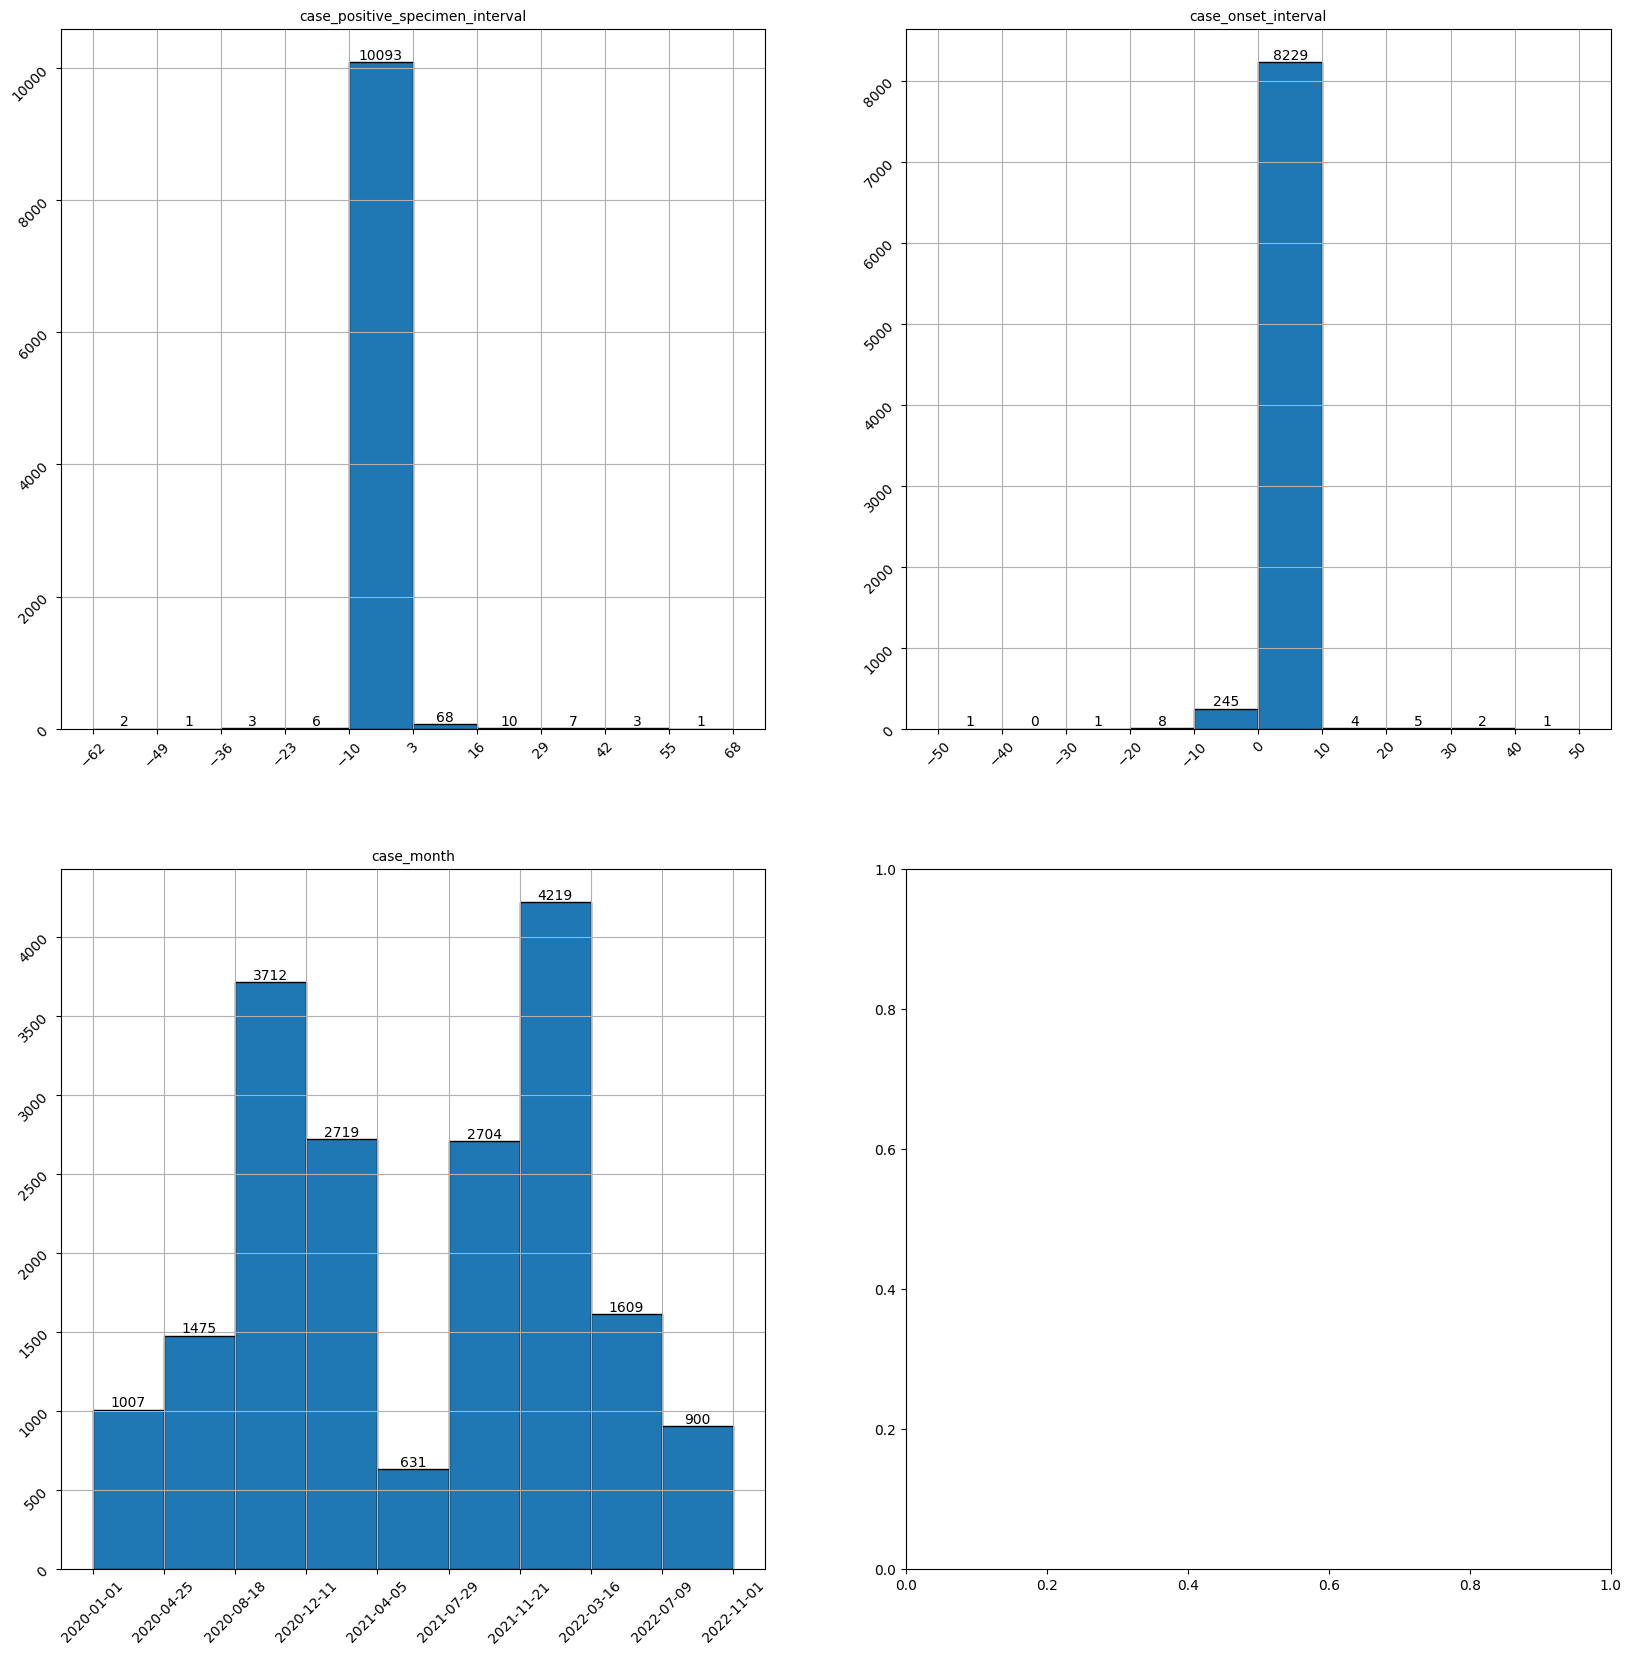

In [183]:
facecolor = (1,1,1)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,20), facecolor=facecolor)

def createHistogram(data, column, ax, bin_count = 10):
    values = data[column]

    # Get ranges for integer types and datetime types
    if values.dtype == 'Int64':
        print("min:", values.min(), "max", values.max())
        bin_range = range(values.min(), values.max(), (values.max()-values.min())//bin_count) 
    else:
        bin_range = pd.date_range(values.min(), values.max(), bin_count)
        
    # Draw the histogram for each column
    hist = data[column].hist(ax=ax, bins=bin_range, xlabelsize=8, ec="black")
    hist.set_xticks(bin_range)
    hist.tick_params(labelsize=10, rotation=45)
        
    # Set the title and labels for the histogram
    hist.set_title(column, fontsize=10)
    hist.bar_label(hist.containers[0], fontsize=10)


for i, column in enumerate(continuous_data):

    createHistogram(data, column, axs[i//2][i%2])

plt.savefig('cat-histograms.pdf')

for s in axs:
    for a in s:
        a.set_facecolor(facecolor)

**Running Assessment**

The histograms allow us to visually get a sense of the distribution of the data.  
Observations from the *'case_positive_specimen_interval'* and *'case_onset_interval'* features:
* There is a very large concentration of values around 0. 
* This lines up with the results obtained for the 1st, 2nd, and 3rd quartiles gathered in the descriptive statistics table.
* There are a few outliers which heavily distort the data set.
* There are negative numbers which do not make sense.  
  
    There is likely invalid data in these two features, which makes sense, since these features are all obtained via calculations based on other fields (which we do not have access to). It is likely some error was introduced in these calculations.  
  
The histogram for *case_month* seems to make sense, with distribution of case_months aligning with what were the pandemic peaks. There is also a smaller likelihood of error introduced in this feature because it is objective and does not require calculation.

**Box and whisker plots:**

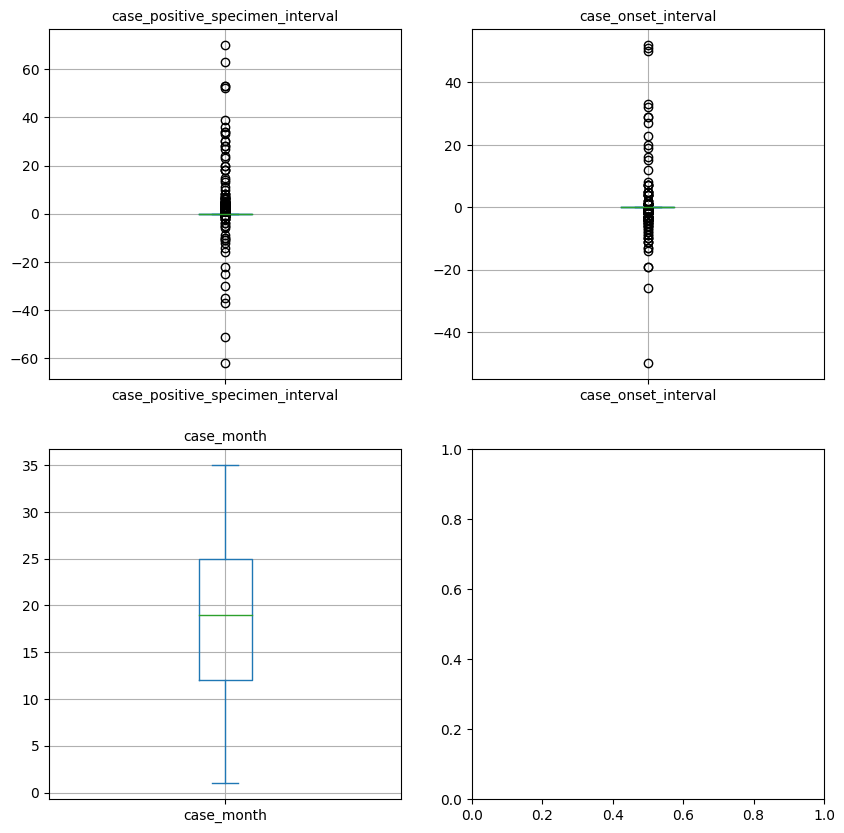

In [184]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10), facecolor=facecolor)

for i, column in enumerate(continuous_data):
    values = data[column]
    bin_count = 10

    # Get values for integer types and datetime types
    if values.dtype == 'Int64':
        values = values
    else:
        values = (values.dt.year-values.min().year)*12 + values.dt.month
        
    # Draw the boxplot for each column
    box = values.plot.box(ax=axs[i//2][i%2], grid=True, fontsize=10) 
    
    # Set the title and labels for the boxplot
    box.set_title(column, fontsize=10)

plt.savefig('boxandwhisker.pdf')

for s in axs:
    for a in s:
        a.set_facecolor(facecolor)

**Running Assessment**

The box-and-whisker plots allow us to continue to develop our sense of the distribution of the data.  
Observations from the 'case_positive_specimen_interval' and 'case_onset_interval' features:
* There is a very large concentration of values around 0 (also apparent from the histogram)
* This lines up with the results obtained for the 1st, 2nd, and 3rd quartiles gathered in the descriptive statistics table, as well as the histogram.
* There are a few outliers which heavily distort the data set; this is even more clear with the box and whisker-plot since the box is practically displayed as a flat line at 0.
* There are negative numbers which do not make sense.  
  
The idea that there is  invalid data in these two features is further reinforced, and steps will have to be taken to address this in the Data Action Plan.
  
The box-and-whisker plot continues to make sense. However we lose the ability to read the multi-modal trend of the data in this plot.

### Categorical Features

#### Print Descriptive Statistics

The categorical features are also now categorized by data type, and null values have been identified. It is now possible to determine the following:
* More frequent levels for the feature
* Frequency of most frequent levels
* Percent missing data
* Cardinality, or number of unique values

In [185]:
# Display the set of descriptive statistics for each continuous feature
describe_categorical_data = getDescriptiveStatisticsForCategoricalFeatures( data[categorical_data])
describe_categorical_data

count unique                        top    freq  \
res_state                   18976     48                         NY    1894   
state_fips_code           18976.0   48.0                       36.0  1894.0   
res_county                  18976    865                    Missing    1177   
county_fips_code            18976   1200                    Missing    1177   
age_group                   18976      5             18 to 49 years    7317   
sex                         18976      3                     Female    9637   
race                        18976      7                      White   11743   
ethnicity                   18976      3        Non-Hispanic/Latino   11396   
process                     18976      8                    Missing   17240   
exposure_yn                 18976      2                    Missing   17037   
current_status              18976      2  Laboratory-confirmed case   16040   
symptom_status              18976      3                    Missing    9756   
hosp_yn                     18976      3                         No    9407   
icu_yn                      18976      3                    Missing   17297   
death_yn                    18976      2                         No   14373   
underlying_conditions_yn    18976      3                    Missing   17160   

                         # missing  % missing             2th mode  \
res_state                        0        0.0                   NJ   
state_fips_code                  0        0.0                 34.0   
res_county                    1177   6.202572           MIAMI-DADE   
county_fips_code              1177   6.202572              12086.0   
age_group                      141   0.743044            65+ years   
sex                            496   2.613828                 Male   
race                          4553  23.993465              Missing   
ethnicity                     5926  31.228921              Missing   
process                      17240  90.851602  Clinical evaluation   
exposure_yn                  17037   89.78183                  Yes   
current_status                   0        0.0        Probable Case   
symptom_status                9756   51.41231          Symptomatic   
hosp_yn                       6373  33.584528              Missing   
icu_yn                       17297  91.151981                   No   
death_yn                         0        0.0                  Yes   
underlying_conditions_yn     17160  90.430017                  Yes   

                         2th mode freq  
res_state                         1730  
state_fips_code                   1730  
res_county                         367  
county_fips_code                   367  
age_group                         5833  
sex                               8843  
race                              4553  
ethnicity                         5926  
process                            819  
exposure_yn                       1939  
current_status                    2936  
symptom_status                    8934  
hosp_yn                           6373  
icu_yn                            1193  
death_yn                          4603  
underlying_conditions_yn          1783

**Running Assessment**

Printing the descriptive statistics for the categorical features shows that there are 4 features which have over 90% missing data:
* **Process**
* **ICU_yn**
* **Underlying_conditions_yn**
* **Exposure_yn**

The rule of thumb for features with this much missing data is to drop it, but we will reassess after analysing the visual plots.

There are also 4 features with between 20-50 missing data.

#### Logical Integrity

**Test 7:** The number of unique res_state should be equal to the number of unique state_fips_code.

In [186]:
count_res_state = data['res_state'].nunique()
count_raw_state_fips_code = data['state_fips_code'].nunique()

if count_res_state == count_raw_state_fips_code:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

The data passes the test.


**Test 8:** The number of unique res_county should be equal to the number of unique county_fips_code.
* The data fails the test, most likely because there is overlap between county names in different states. To remedy this, we could create another feature that is a combination of both county and state, or drop the feature, since this data is already encoded in the county_fips_code.

In [187]:
count_res_county = data['res_county'].nunique()
count_county_fips_Code = data['county_fips_code'].nunique()

print(f'{count_res_county} unique res_county and {count_county_fips_Code} unique county fips_codes.')
if count_res_county == count_county_fips_Code:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

865 unique res_county and 1200 unique county fips_codes.
The data does not pass the test.


**Test 9:** If we divide the county_fips_codes by 1000, the number of unique values should be equal to the number of unique state_fips_codes.

In [188]:
# Calculate the state fisps codes derived from the county codes
derived_state_fips_code = data['county_fips_code'].apply(lambda county: county // 1000 if county != 'Missing' else 0)

# Count the total number of unique derived_ (minus 1 to account for the derived_state_codes that are missing and coded to 0) and raw_state_codes
count_derived_state_fips_code = derived_state_fips_code.nunique() - 1
count_raw_state_fips_code = data['state_fips_code'].nunique()

# Test whether these numbers are the same. Print the results
print(f"There are {count_derived_state_fips_code} state codes derived from county codes and {count_raw_state_fips_code} raw state codes.")
if count_derived_state_fips_code == count_raw_state_fips_code:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

There are 46 state codes derived from county codes and 48 raw state codes.
The data does not pass the test.


At a glance, the data does not pass the test. However, there are instances of *'Missing'* county fips codes. Perhaps these coincide with the outlying state fips codes. To determine the source of this error and whether it is a case of invalid data, we can do some set operations.

In [189]:
# Convert both sets of state codes to sets.
sorted_derived_state = set(derived_state_fips_code.unique())
sorted_raw_state = set(data['state_fips_code'].unique().tolist())

# Perform a symmetric difference to identify codes that are present in one of the sets but not in both.
difference = sorted_derived_state.symmetric_difference(sorted_raw_state)

difference

{0.0, 72.0, 78.0}

In [190]:
# Discard 0 because we know it is an indicator for missing county data.
difference.discard(0)

# Identify entries in the raw data set with state codes in the difference set
difference_rows = data.loc[data['state_fips_code'].isin(difference)]
difference_rows_counties = difference_rows['county_fips_code'].unique()

# Print the county codes of the states not present in the difference 
print(difference_rows_counties)

['Missing']
Categories (1200, object): [1001.0, 1003.0, 1015.0, 1039.0, ..., 56037.0, 56039.0, 56041.0, 'Missing']


Upon further examination, the data makes sense. The state_fips_codes that appear in the raw_state_codes and not in the derived_state_codes appear this way because all of the entries belonging to those states do not contain any county codes. These entries are from Puerto Rico or the Virgin Islands. These are not *states* the same way the other states are, which could help explain the lack of county fips codes. For completeness of the model, we could generate a "county code" for each of these two states.

**Test 10:** In all cases where there is a county_fips_code, the derived_state_fips_code should be equal to the raw_state_fips_code.

In [191]:
# Create a table with just the state and county fips code 
state_county_comparison_table = pd.DataFrame([derived_state_fips_code, data['state_fips_code']]).T

# Compare the derived_ and raw_fips_codes for each row and store this in another column called 
state_county_comparison_result = state_county_comparison_table.apply(lambda row: \
        row['county_fips_code'] == row['state_fips_code'] \
        if row['county_fips_code'] != 0 \
        else True, axis=1).rename('equality')
state_county_comparison_result = pd.concat([state_county_comparison_table, state_county_comparison_result], axis=1)

state_county_comparison_result

county_fips_code  state_fips_code  equality
0                  24.0             24.0      True
1                   6.0              6.0      True
2                   0.0             13.0      True
3                  20.0             20.0      True
4                  48.0             48.0      True
...                 ...              ...       ...
19995              12.0             12.0      True
19996              55.0             55.0      True
19997              12.0             12.0      True
19998              47.0             47.0      True
19999               4.0              4.0      True

[18976 rows x 3 columns]

In [192]:
# Count the number of columns where equality is not equal to True
unequal_state_fips_codes = state_county_comparison_result['equality'].value_counts().index.tolist()

if len(unequal_state_fips_codes) == 1 and unequal_state_fips_codes[0]:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

The data passes the test.


**Test 11:** The number of hospitalized patients should be less than the number of symptomatic patients.

In [193]:
count_symtomatic_patients = data['symptom_status'].loc[data['symptom_status'] == 'Symptomatic'].count()
count_hospitalized_patients = data['hosp_yn'].loc[data['hosp_yn'] == 'Yes'].count()

# Test whether the number of symptomatic patients is greater than the number of hospitalized patients.
print(f"There were {count_symtomatic_patients} symptomatic patients and {count_hospitalized_patients} patients were hospitalized.")
if count_symtomatic_patients >= count_hospitalized_patients:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

There were 8934 symptomatic patients and 3196 patients were hospitalized.
The data passes the test.


**Test 12:** In all cases where *'hosp_yn'* is 'Yes', *'symptom_status'* should be 'Symptomatic'; a patient without symptoms would not need hospital care for Covid.

In [194]:
# Create a table with just the hosp_yn and symptom_status columns
hosp_symp_comparison_table = pd.DataFrame([data['symptom_status'], data['hosp_yn']]).T

# Check whether for each entry into the hospital the patient was indicated as symptomatic, store this value in a column named 'validity' 
hosp_symp_comparison_result = hosp_symp_comparison_table.apply(lambda row:\
    row['symptom_status'] == 'Symptomatic' \
    if row['hosp_yn'] == 'Yes' \
    else True, axis=1).rename('validity')
hosp_symp_comparison_result = pd.concat([hosp_symp_comparison_table, hosp_symp_comparison_result], axis=1)

hosp_symp_comparison_result

symptom_status  hosp_yn  validity
0            Missing  Missing      True
1        Symptomatic      Yes      True
2            Missing  Missing      True
3        Symptomatic      Yes      True
4            Missing      Yes     False
...              ...      ...       ...
19995    Symptomatic       No      True
19996    Symptomatic       No      True
19997        Missing       No      True
19998    Symptomatic       No      True
19999    Symptomatic       No      True

[18976 rows x 3 columns]

In [195]:
# Count the number of columns where validity is not equal to True
invalid_symp_entry = hosp_symp_comparison_result['validity'].value_counts().index.tolist()

if len(invalid_symp_entry) == 1 and invalid_symp_entry[0]:
    print("The data passes the test.")
else:
    count_invalid_symp_entry = len(hosp_symp_comparison_result.loc[hosp_symp_comparison_result['validity'] == False])
    print(f"The data does not pass the test. \n{count_invalid_symp_entry} instances of asymptomatic hospitalizations.")

The data does not pass the test. 
1428 instances of asymptomatic hospitalizations.


The data does not pass the test, which indicates that there are instances of patients who have entered the hospital as symptomatic. Logically speaking, to have entered the hospital though, the patient has to have been symptomatic. With this insight, we may be able to fill in some of the 'Missing' values in the *'symptom_status'* column with 'Symptomatic'.

**Test 13:** The number of patients admitted to the ICU should be less than the number of hospitalized patients.

In [196]:
count_hospitalized_patients = data['hosp_yn'].loc[data['hosp_yn'] == 'Yes'].count()
count_icu_patients = data['icu_yn'].loc[data['icu_yn'] == 'Yes'].count()

# Test whether the number of symptomatic patients is greater than the number of hospitalized patients.
print(f"There were {count_hospitalized_patients} hospitalized patients and {count_icu_patients} patients were admitted to the ICU.")
if count_hospitalized_patients >= count_icu_patients:
    print("The data passes the test.")
else:
    print("The data does not pass the test.")

There were 3196 hospitalized patients and 486 patients were admitted to the ICU.
The data passes the test.


**Test 14:** In all cases where *'icu_yn'* is 'Yes', *'hosp_yn'* should be 'Yes'.

In [197]:
# Create a table with just the hosp_yn and symptom_status columns
icu_hosp_comparison_table = pd.DataFrame([data['hosp_yn'], data['icu_yn']]).T

# Check whether for each entry into the ICU the patient was indicated as being adnmitted to the ICU, store this value in a column named 'validity' 
icu_hosp_comparison_result = icu_hosp_comparison_table.apply(lambda row: \
    row['hosp_yn'] == 'Yes' \
    if row['icu_yn'] == 'Yes' \
    else True, axis=1).rename('validity')
icu_hosp_comparison_result = pd.concat([icu_hosp_comparison_table, icu_hosp_comparison_result], axis=1)

icu_hosp_comparison_result

hosp_yn   icu_yn  validity
0      Missing  Missing      True
1          Yes  Missing      True
2      Missing  Missing      True
3          Yes      Yes      True
4          Yes  Missing      True
...        ...      ...       ...
19995       No  Missing      True
19996       No  Missing      True
19997       No  Missing      True
19998       No  Missing      True
19999       No  Missing      True

[18976 rows x 3 columns]

In [198]:
# Count the number of columns where validity is not equal to True
invalid_hosp_entry = icu_hosp_comparison_result['validity'].value_counts().index.tolist()

if len(invalid_hosp_entry) == 1 and invalid_hosp_entry[0]:
    print("The data passes the test.")
else:
    count_invalid_hosp_entry = len(icu_hosp_comparison_result.loc[icu_hosp_comparison_result['validity'] == False])
    print(f"The data does not pass the test. \n{count_invalid_hosp_entry} instances of ICU stays without hospitalizations.")

The data passes the test.


**Test 15:** In all cases where *'death_yn'* is 'Yes', *'symptom_status'* should be 'Symptomatic'.

In [199]:
# Create a table with just the hosp_yn and symptom_status columns
death_symptom_comparison_table = pd.DataFrame([data['death_yn'], data['symptom_status']]).T

# Check whether for each entry into the hospital the patient was indicated as symptomatic, store this value in a column named 'validity' 
death_symptom_comparison_result = death_symptom_comparison_table.apply(lambda row: row['symptom_status'] == 'Sympytomatic' if row['death_yn'] == 'Yes' else True, axis=1).rename('validity')
death_symptom_comparison_result = pd.concat([death_symptom_comparison_table, death_symptom_comparison_result], axis=1)

death_symptom_comparison_result

death_yn symptom_status  validity
0          Yes        Missing     False
1          Yes    Symptomatic     False
2          Yes        Missing     False
3          Yes    Symptomatic     False
4          Yes        Missing     False
...        ...            ...       ...
19995       No    Symptomatic      True
19996       No    Symptomatic      True
19997       No        Missing      True
19998       No    Symptomatic      True
19999       No    Symptomatic      True

[18976 rows x 3 columns]

In [200]:
# Count the number of columns where validity is not equal to True
invalid_death_symptom_entry = death_symptom_comparison_result['validity'].value_counts().index.tolist()

if len(invalid_death_symptom_entry) == 1 and invalid_death_symptom_entry[0]:
    print("The data passes the test.")
else:
    count_invalid_death_symptom_entry = len(death_symptom_comparison_result.loc[death_symptom_comparison_result['validity'] == False])
    print(f"The data does not pass the test. \n{count_invalid_death_symptom_entry} instances of asymptomatic deaths.")


The data does not pass the test. 
4603 instances of asymptomatic deaths.


#### Plots

**Histograms:**

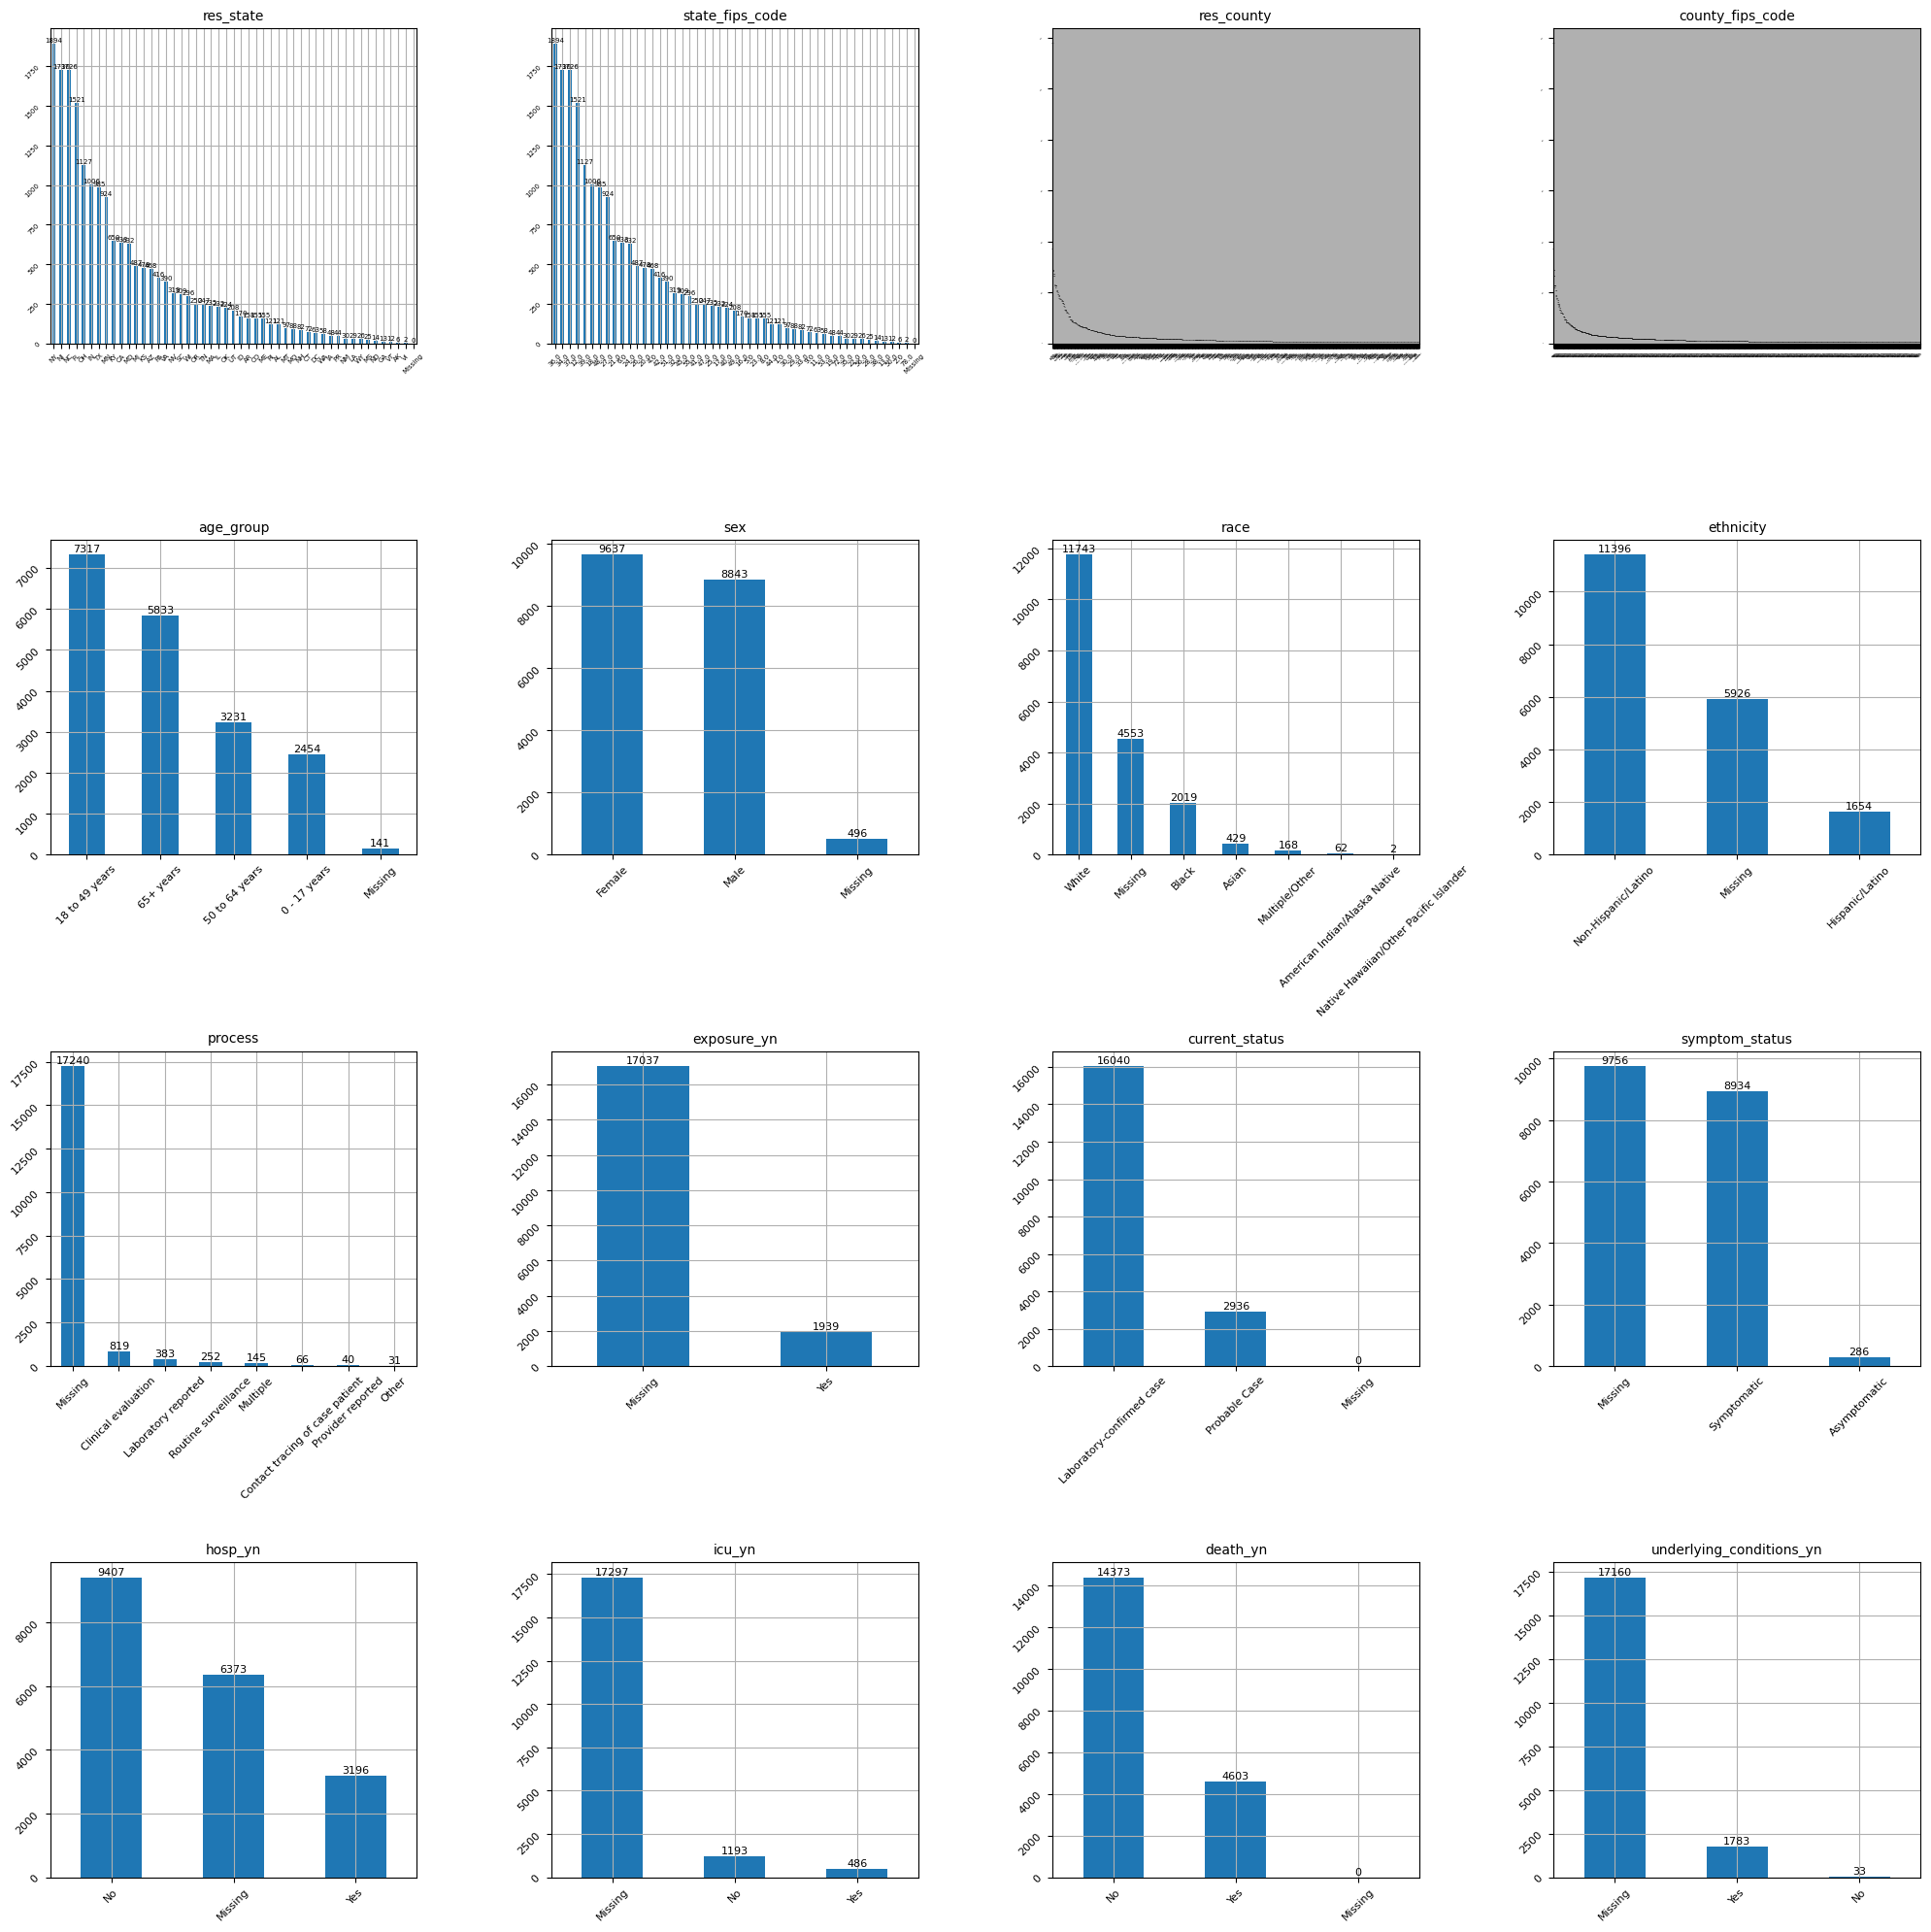

In [201]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(20,20), facecolor=facecolor)

for i, column in enumerate(categorical_data):

    # Draw the histogram for each column
    bar = data[column].value_counts().plot.bar(ax=axs[i//4][i%4], grid=True) 

    if 50 > len(data[column].value_counts().index.tolist())> 10:
        bar.bar_label(bar.containers[0], fontsize=5)
        bar.tick_params(labelsize=5, rotation=45)


    elif len(data[column].value_counts().index.tolist())> 50:
        bar.bar_label(bar.containers[0], fontsize=1)
        bar.tick_params(labelsize=1, rotation=45)

    else:
        bar.bar_label(bar.containers[0], fontsize=8)
        bar.tick_params(labelsize=8, rotation=45) 
        
    # Set the title and labels for the boxplot
    bar.set_title(column, fontsize=10)

plt.tight_layout(w_pad=3)

plt.savefig('histograms.pdf')


for s in axs:
    for a in s:
        a.set_facecolor(facecolor)

# Exercise 2 - Prepare a **Data Quality Plan** for the cleaned CSV file. 

## List of Features and Handling Strategies

| Feature Name | Data Quality Issue | Handling Strategy | 
|--------------|--------------------|-------------------|
| case_month | None | Keep as Is |
| res_state| Redundant | Drop Feature |
| state_fips_code | Redundant | Drop Feature|
| res_county | Redundant and Ambiguous | Drop Feature |
| county_fips_code | Missing Data | Impute using state_fips_code values * 1000 to generate new county_fips_codes when missing|
| age_group | Missing Data |Impute using k-nearest neighbor algorithm |
| sex | Missing Data |Impute using k-nearest neighbor algorithm |
| race | Missing Data |Impute using k-nearest neighbor algorithm |
| ethnicity | Missing Data |Impute using k-nearest neighbor algorithm |
| case_positive_specimen_interval | Invalid Data | Take the absolute value of the data to make all values positive |
| case_positive_specimen_interval | Not Applicable Data | Distinguish between 'Missing' values when the number is not applicable, versus when the number was truly not present in the set.|
| case_positive_specimen_interval | Missing Data | Impute using k-nearest neighbor algorithm |
| case_positive_specimen_interval | Outliers | Keep as is for now, after cleaning the data, re-evaluate|
| case_onset_interval | Invalid Data | Take the absolute value of the data to make all values positive |
| case_onset_interval | Not Applicable Data | Distinguish between 'Missing' values when the number is not applicable, versus when the number was truly not present in the set |
| case_onset_interval | Missing Data | Impute using k-nearest neighbor algorithm |
| case_onset_interval | Outliers | Keep as is for now, after cleaning the data, re-evaluate |
| process | 90%+ Missing | Drop Feature |
| exposure_yn | 90%+ Missing | Drop Feature 
| current_status | Illogical Data | Replace with 'Laboratory-confirmed case' if 'case_positive_specimen_interval' is not Null |
| symptom_status | Illogical Data | Replace with 'Yes' if 'hospital_yn' is 'Yes', 'icu_yn' is 'Yes', or 'death_yn' is 'Yes'; Replace with 'Yes if 'case_onset_interval' is not Null |
| symptom_status | Missing Data | Impute using k-nearest neighbor algorithm |
| hosp_yn | Illogical Data | Replace with 'Yes' if 'icu_yn' is 'Yes |
| hosp_yn | Missing Data | Impute using k-nearest neighbor algorithm |
| icu_yn | 90%+ Missing | Drop Feature |
| underlying_conditions_yn | 90%+ missing | Drop Feature |

## Implementing the Handling Strategies

### Round 1: Address problems identifited in the logical integrity tests, remove redundant features, and remove features with over 90% missing data.

The initial list of issues as identified in the **18389156_Data Quality_Report.pdf** and summarized in the Action Plan above:  

0. Null and duplicate values: already addressed
1. Replace all negative ‘case_positive_specimen_interval’ and ‘case_onset_interval’ values with their absolute values.
2. Replace all ‘hospital_yn’ values with ‘Yes’ if ‘icu_yn’ is ‘Yes’
3. Replace all ‘symptom_status’ values with ‘Symptomatic’ if ‘hospital_yn’,  ‘icu_yn’, or ‘death_yn’ values are ‘Yes’
4. Replace all ‘symptom_status’ values with ‘Symptomatic’ if ‘case_onset_interval’ is not Null
5. Replace all ‘current_status’ values with ‘Laboratory_confirmed_case’ if ‘case_positive_specimen_interval’ is not Null.
6. Drop ‘res_county’, ‘res_state’, and ‘state_fips_code’, and replace with a modified ‘county_fips_code’
7. Drop ‘process’, ‘exposure_yn’, ‘icu_yn’, and ‘underlying_conditions_yn’ features, with over 90% missing data.



In [202]:
# Instead of importing the .csv generated from the Data Quality Report, we will make a copy of it in its final state.
# This saves us from some work having to re-assigning categories and types.
data_action = data.copy()

In [203]:
# Get shape of data without nulls and duplicates.T
getShape(data_action)

The dataset has 18976 entries, with 19 features per entry.


In [204]:
class implementHandlingStrategies():
    def __init__(self, dataFrame, expression, columnToModify, newColumnName):
        self.dataFrame = dataFrame.copy()
        self.testingExpression = expression
        self.columnToModify = columnToModify
        self.newColumnName = newColumnName
    
    def applyToRowsAndAppend(self):
        self.tempDataSet = applyToRowsAndAppend(self.dataFrame, self.testingExpression, self.newColumnName)
        return self.tempDataSet
    
    def castToInt(self, columns=None):
        assert self.tempDataSet is not None
        if columns == None:
            columns = [self.columnToModify, self.newColumnName]
        self.tempDataSet[columns] = self.tempDataSet[columns].astype('Int64')
        return self.tempDataSet
    
    def castToCat(self, columns=None):
        assert self.tempDataSet is not None
        if columns == None:
            columns = [self.columnToModify, self.newColumnName] 
        self.tempDataSet[columns] = self.tempDataSet[columns].astype('category')
        return self.tempDataSet
    
    def castWithDictionary(self, dictionary):
        assert self.tempDataSet is not None
        self.tempDataSet[[dictionary.keys()]].astype(dictionary)
        return self.tempDataSet

    def getContDescriptiveStatistics(self, contFeatures=None):
        assert self.tempDataSet is not None
        if contFeatures == None:
            contFeatures = [self.columnToModify, self.newColumnName] 
        self.tempDataSetStats = getDescriptiveStatisticsForContinuousFeatures(self.tempDataSet[contFeatures])
        print("Comparison of the before and after features:")
        return self.tempDataSetStats
    
    def getCatDescriptiveStatistics(self, catFeatures=None):
        assert self.tempDataSet is not None
        if catFeatures == None:
            catFeatures = [self.columnToModify, self.newColumnName] 
        self.tempDataSetStats = getDescriptiveStatisticsForCategoricalFeatures(self.tempDataSet[catFeatures])
        print("Comparison of the before and after features:")
        return self.tempDataSetStats
    
    def compareOldandNewDatasets(self, test_orig_exp, test_new_exp):
        # Generate validity column and count the number of new invalid entries
        print("Original dataset:")
        test_orig_exp = getValidityColumn(self.tempDataSet, test_orig_exp)
        print("\nNew dataset:")
        test_new_exp = getValidityColumn(self.tempDataSet, test_new_exp)

    def updateTable(self, dataFrame):
        dataFrame[self.columnToModify] = self.tempDataSet[self.newColumnName] 
        return dataFrame

#### 1. Negative 'case_positive_specimen_interval' and 'case_onset_interval' values  
As discussed in the DQR, the choice was made to to take the absolute value of these two intervals, and use these instead of their original properties. It is likely that in filling out the PUI form, two dates were flipped and the values were computed as negatives rather than positives.

In [205]:
# Define an expression to apply to the columns to correct
exp_abs_case_pos_spec = lambda row: abs(row['case_positive_specimen_interval'])

# Apply expression, append to the temporary data set
abs_case_pos_spec = implementHandlingStrategies(data_action, exp_abs_case_pos_spec, 'case_positive_specimen_interval', 'abs_case_positive_specimen_interval')
abs_case_pos_spec.applyToRowsAndAppend()

# Cast the data to Int64
abs_case_pos_spec.castToInt()

# Get descriptive statistics
abs_case_pos_spec_stats = abs_case_pos_spec.getContDescriptiveStatistics()
abs_case_pos_spec_stats

Comparison of the before and after features:


count      mean       std   min  25%  \
case_positive_specimen_interval      10195.0  0.179696  2.120946 -62.0  0.0   
abs_case_positive_specimen_interval  10195.0  0.260912  2.112492   0.0  0.0   

                                     50%  75%   max  # missing  % missing  \
case_positive_specimen_interval      0.0  0.0  70.0     8781.0  46.274241   
abs_case_positive_specimen_interval  0.0  0.0  70.0     8781.0  46.274241   

                                     1th mode  1th mode freq  2th mode  \
case_positive_specimen_interval           0.0         8998.0       1.0   
abs_case_positive_specimen_interval       0.0         8998.0       1.0   

                                     2th mode freq  cardinality  
case_positive_specimen_interval              950.0         47.0  
abs_case_positive_specimen_interval          977.0         38.0

In [206]:
# Define an expression to apply to the columns to correct
exp_abs_case_onset = lambda row: abs(row['case_onset_interval'])

# Instantiate class to implement handling strategies
abs_case_onset_interval = implementHandlingStrategies(data_action, exp_abs_case_onset, 'case_onset_interval', 'abs_case_onset_interval')
abs_case_onset_interval.applyToRowsAndAppend()

# Cast the data to Int64
abs_case_onset_interval.castToInt()

# Get descriptive statistics, mode, second mode, and cardinality
abs_case_onset_stats = abs_case_onset_interval.getContDescriptiveStatistics()
abs_case_onset_stats


Comparison of the before and after features:


count      mean       std   min  25%  50%  75%  \
case_onset_interval      8498.0 -0.015062  1.574111 -50.0  0.0  0.0  0.0   
abs_case_onset_interval  8498.0  0.134385  1.568435   0.0  0.0  0.0  0.0   

                          max  # missing  % missing  1th mode  1th mode freq  \
case_onset_interval      52.0    10478.0  55.217116       0.0         8195.0   
abs_case_onset_interval  52.0    10478.0  55.217116       0.0         8195.0   

                         2th mode  2th mode freq  cardinality  
case_onset_interval          -1.0          164.0         36.0  
abs_case_onset_interval       1.0          181.0         28.0

**Running Analysis**  
Making all of values positive has not had a large impact on the descriptive statistics for our features.
* The minimum value has become 0, which makes sense, but in the case of both of the new features, the 25%, 50%, and 75% value remain unchanged.
* The mean, median, mode, and second modes are now all positive values.
* The cardinality has change slightly, as expected, since we have removed all negative values.

In [207]:
# Update the table.
data_action = abs_case_pos_spec.updateTable(data_action)
data_action = abs_case_onset_interval.updateTable(data_action)

# Preview the table
data_action

case_month res_state state_fips_code res_county county_fips_code  \
0     2020-12-01        MD            24.0  FREDERICK          24021.0   
1     2021-12-01        CA             6.0     ORANGE           6059.0   
2     2020-01-01        GA            13.0    Missing          Missing   
3     2020-11-01        KS            20.0   SEDGWICK          20173.0   
4     2020-07-01        TX            48.0     HARRIS          48201.0   
...          ...       ...             ...        ...              ...   
19995 2021-12-01        FL            12.0    BROWARD          12011.0   
19996 2021-01-01        WI            55.0  OUTAGAMIE          55087.0   
19997 2021-03-01        FL            12.0       LEON          12073.0   
19998 2021-12-01        TN            47.0   DAVIDSON          47037.0   
19999 2021-04-01        AZ             4.0   MARICOPA           4013.0   

            age_group      sex     race            ethnicity  \
0           65+ years     Male    White  Non-Hispanic/Latino   
1           65+ years     Male    White  Non-Hispanic/Latino   
2             Missing  Missing  Missing              Missing   
3           65+ years     Male  Missing              Missing   
4           65+ years     Male    White  Non-Hispanic/Latino   
...               ...      ...      ...                  ...   
19995  18 to 49 years     Male    Black  Non-Hispanic/Latino   
19996  50 to 64 years   Female    White  Non-Hispanic/Latino   
19997  18 to 49 years   Female    White      Hispanic/Latino   
19998    0 - 17 years   Female  Missing              Missing   
19999  18 to 49 years   Female    Asian  Non-Hispanic/Latino   

       case_positive_specimen_interval  case_onset_interval  \
0                                 <NA>                 <NA>   
1                                 <NA>                 <NA>   
2                                 <NA>                 <NA>   
3                                 <NA>                    0   
4                                 <NA>                 <NA>   
...                                ...                  ...   
19995                                0                    0   
19996                             <NA>                    0   
19997                             <NA>                 <NA>   
19998                                1                    0   
19999                             <NA>                    0   

                   process exposure_yn             current_status  \
0                  Missing     Missing  Laboratory-confirmed case   
1                  Missing     Missing  Laboratory-confirmed case   
2                  Missing     Missing  Laboratory-confirmed case   
3      Laboratory reported         Yes  Laboratory-confirmed case   
4                  Missing     Missing  Laboratory-confirmed case   
...                    ...         ...                        ...   
19995              Missing     Missing  Laboratory-confirmed case   
19996              Missing     Missing  Laboratory-confirmed case   
19997              Missing     Missing  Laboratory-confirmed case   
19998              Missing     Missing  Laboratory-confirmed case   
19999              Missing     Missing  Laboratory-confirmed case   

      symptom_status  hosp_yn   icu_yn death_yn underlying_conditions_yn  
0            Missing  Missing  Missing      Yes                  Missing  
1        Symptomatic      Yes  Missing      Yes                  Missing  
2            Missing  Missing  Missing      Yes                  Missing  
3        Symptomatic      Yes      Yes      Yes                  Missing  
4            Missing      Yes  Missing      Yes                  Missing  
...              ...      ...      ...      ...                      ...  
19995    Symptomatic       No  Missing       No                  Missing  
19996    Symptomatic       No  Missing       No                  Missing  
19997        Missing       No  Missing       No                  Missing  
19998    Sym

#### 2. Replace all ‘hospital_yn’ values with ‘Yes’ if ‘icu_yn’ is ‘Yes’  
As discussed in the DQR, we have identified that some entries in the 'hospital_yn' field do not match the corresponding value in the 'icu_yn' field. In order to maintain as much data as possible, we will update the 'hospital_yn' values to 'Yes' when 'icu_yn' is 'Yes', rather than dropping these entries entirely. This approach will prevent data loss while also ensuring that the data is consistent and accurate. It is reasonable to assume that individuals filling out the form may have marked off one field and not the other because the truth of one is implied in the other.

In [208]:
# Define an expression to apply to the columns to correct
exp_hosp_icu = lambda row: 'Yes' if row['icu_yn'] == 'Yes' else row['hosp_yn']

# Apply expression, append to the temporary data set
data_action_hosp_icu = implementHandlingStrategies(data_action, exp_hosp_icu, 'hosp_yn', 'corrected_hosp_yn')
data_action_hosp_icu.applyToRowsAndAppend()

# Cast the data to Categorical
data_action_hosp_icu.castToCat(['hosp_yn', 'corrected_hosp_yn'])

# Get descriptive statistics, mode, second mode, and cardinality
data_action_hosp_icu_stats = data_action_hosp_icu.getCatDescriptiveStatistics()

data_action_hosp_icu_stats

Comparison of the before and after features:


count unique top  freq # missing  % missing 2th mode  \
hosp_yn            18976      3  No  9407      6373  33.584528  Missing   
corrected_hosp_yn  18976      3  No  9407      6373  33.584528  Missing   

                  2th mode freq  
hosp_yn                    6373  
corrected_hosp_yn          6373

In [209]:
# Define testing expressions
test_exp_hosp_icu_orig = lambda row: row['hosp_yn'] == 'Yes' if row['icu_yn'] == 'Yes' else True
test_exp_hosp_icu_new = lambda row: row['corrected_hosp_yn'] == 'Yes' if row['icu_yn'] == 'Yes' else True

# Compare data sets
data_action_hosp_icu.compareOldandNewDatasets(test_exp_hosp_icu_orig, test_exp_hosp_icu_new)

Original dataset:
The data passes the test.

New dataset:
The data passes the test.


**Running Analysis**  
The change has affected two rows in the data set, and has otherwise had little effect on descriptive statistics of the data.

In [210]:
# Update the table.
data_action = data_action_hosp_icu.updateTable(data_action)

# Preview the table
data_action

case_month res_state state_fips_code res_county county_fips_code  \
0     2020-12-01        MD            24.0  FREDERICK          24021.0   
1     2021-12-01        CA             6.0     ORANGE           6059.0   
2     2020-01-01        GA            13.0    Missing          Missing   
3     2020-11-01        KS            20.0   SEDGWICK          20173.0   
4     2020-07-01        TX            48.0     HARRIS          48201.0   
...          ...       ...             ...        ...              ...   
19995 2021-12-01        FL            12.0    BROWARD          12011.0   
19996 2021-01-01        WI            55.0  OUTAGAMIE          55087.0   
19997 2021-03-01        FL            12.0       LEON          12073.0   
19998 2021-12-01        TN            47.0   DAVIDSON          47037.0   
19999 2021-04-01        AZ             4.0   MARICOPA           4013.0   

            age_group      sex     race            ethnicity  \
0           65+ years     Male    White  Non-Hispanic/Latino   
1           65+ years     Male    White  Non-Hispanic/Latino   
2             Missing  Missing  Missing              Missing   
3           65+ years     Male  Missing              Missing   
4           65+ years     Male    White  Non-Hispanic/Latino   
...               ...      ...      ...                  ...   
19995  18 to 49 years     Male    Black  Non-Hispanic/Latino   
19996  50 to 64 years   Female    White  Non-Hispanic/Latino   
19997  18 to 49 years   Female    White      Hispanic/Latino   
19998    0 - 17 years   Female  Missing              Missing   
19999  18 to 49 years   Female    Asian  Non-Hispanic/Latino   

       case_positive_specimen_interval  case_onset_interval  \
0                                 <NA>                 <NA>   
1                                 <NA>                 <NA>   
2                                 <NA>                 <NA>   
3                                 <NA>                    0   
4                                 <NA>                 <NA>   
...                                ...                  ...   
19995                                0                    0   
19996                             <NA>                    0   
19997                             <NA>                 <NA>   
19998                                1                    0   
19999                             <NA>                    0   

                   process exposure_yn             current_status  \
0                  Missing     Missing  Laboratory-confirmed case   
1                  Missing     Missing  Laboratory-confirmed case   
2                  Missing     Missing  Laboratory-confirmed case   
3      Laboratory reported         Yes  Laboratory-confirmed case   
4                  Missing     Missing  Laboratory-confirmed case   
...                    ...         ...                        ...   
19995              Missing     Missing  Laboratory-confirmed case   
19996              Missing     Missing  Laboratory-confirmed case   
19997              Missing     Missing  Laboratory-confirmed case   
19998              Missing     Missing  Laboratory-confirmed case   
19999              Missing     Missing  Laboratory-confirmed case   

      symptom_status  hosp_yn   icu_yn death_yn underlying_conditions_yn  
0            Missing  Missing  Missing      Yes                  Missing  
1        Symptomatic      Yes  Missing      Yes                  Missing  
2            Missing  Missing  Missing      Yes                  Missing  
3        Symptomatic      Yes      Yes      Yes                  Missing  
4            Missing      Yes  Missing      Yes                  Missing  
...              ...      ...      ...      ...                      ...  
19995    Symptomatic       No  Missing       No                  Missing  
19996    Symptomatic       No  Missing       No                  Missing  
19997        Missing       No  Missing       No                  Missing  
19998    Sym

#### 3. Replace all ‘symptom_status’ values with ‘Symptomatic’ if ‘hospital_yn’,  ‘icu_yn’, or ‘death_yn’ values are ‘Yes’
As discussed in the DQR, we have identified that some entries in the 'symptom_status' field do not accurately reflect the value you would expect based on the values in the 'icu_yn', 'hospital_yn', or 'death_yn' field. In order to maintain as much data as possible, we will update the 'symptom_status' values to 'symptomatic' when any of 'icu_yn', 'hospital_yn', or 'death_yn' is 'Yes', rather than dropping these entries entirely. This approach will prevent data loss while also ensuring that the data is consistent and accurate. It is reasonable to assume that individuals filling out the form may have marked off one field and not the other because the truth of one is implied in the other.

In [211]:
# Define an expression to apply to the columns to correct
exp_symptom_icu_hosp_death = lambda row: 'Symptomatic' if (row['icu_yn'] == 'Yes' or row['hosp_yn'] == 'Yes' or row['death_yn'] == 'Yes') else row['symptom_status']

# Apply expression, append to the temporary data set
symptom_icu_hosp_death = implementHandlingStrategies(data_action, exp_symptom_icu_hosp_death, 'symptom_status', 'corrected_symptom_status')
symptom_icu_hosp_death.applyToRowsAndAppend()

# Cast the data to Categorical
symptom_icu_hosp_death.castToCat()

# Get descriptive statistics, mode, second mode, and cardinality
symptom_icu_hosp_death_stats = symptom_icu_hosp_death.getCatDescriptiveStatistics()

symptom_icu_hosp_death_stats

Comparison of the before and after features:


count unique          top   freq # missing  \
symptom_status            18976      3      Missing   9756      9756   
corrected_symptom_status  18976      3  Symptomatic  11768      6982   

                          % missing     2th mode 2th mode freq  
symptom_status             51.41231  Symptomatic          8934  
corrected_symptom_status  36.793845      Missing          6982

In [212]:
# Define testing expressions
test_exp_symptom_icu_hosp_death_orig = lambda row: row['symptom_status'] == 'Symptomatic' if (row['icu_yn'] == 'Yes' or row['hosp_yn'] == 'Yes' or row['death_yn'] == 'Yes') else True
test_exp_symptom_icu_hosp_death_new = lambda row: row['corrected_symptom_status'] == 'Symptomatic' if (row['icu_yn'] == 'Yes' or row['hosp_yn'] == 'Yes' or row['death_yn'] == 'Yes') else True

# Compare data sets
symptom_icu_hosp_death.compareOldandNewDatasets(test_exp_symptom_icu_hosp_death_orig, test_exp_symptom_icu_hosp_death_new)

Original dataset:
The data does not pass the test. 
2834 invalid entries.

New dataset:
The data passes the test.


**Running Analysis**  
The change has affected 2831 rows in the data set, updating over 14.9% of the entries. Because of this change, the most frequent entry in the 'symptom_status' feature will be 'Symptomatic' rather than 'Missing', and the % missing is down from 52% to 37%.

In [213]:
# Update the table.
data_action = symptom_icu_hosp_death.updateTable(data_action)

# Preview the table
data_action

case_month res_state state_fips_code res_county county_fips_code  \
0     2020-12-01        MD            24.0  FREDERICK          24021.0   
1     2021-12-01        CA             6.0     ORANGE           6059.0   
2     2020-01-01        GA            13.0    Missing          Missing   
3     2020-11-01        KS            20.0   SEDGWICK          20173.0   
4     2020-07-01        TX            48.0     HARRIS          48201.0   
...          ...       ...             ...        ...              ...   
19995 2021-12-01        FL            12.0    BROWARD          12011.0   
19996 2021-01-01        WI            55.0  OUTAGAMIE          55087.0   
19997 2021-03-01        FL            12.0       LEON          12073.0   
19998 2021-12-01        TN            47.0   DAVIDSON          47037.0   
19999 2021-04-01        AZ             4.0   MARICOPA           4013.0   

            age_group      sex     race            ethnicity  \
0           65+ years     Male    White  Non-Hispanic/Latino   
1           65+ years     Male    White  Non-Hispanic/Latino   
2             Missing  Missing  Missing              Missing   
3           65+ years     Male  Missing              Missing   
4           65+ years     Male    White  Non-Hispanic/Latino   
...               ...      ...      ...                  ...   
19995  18 to 49 years     Male    Black  Non-Hispanic/Latino   
19996  50 to 64 years   Female    White  Non-Hispanic/Latino   
19997  18 to 49 years   Female    White      Hispanic/Latino   
19998    0 - 17 years   Female  Missing              Missing   
19999  18 to 49 years   Female    Asian  Non-Hispanic/Latino   

       case_positive_specimen_interval  case_onset_interval  \
0                                 <NA>                 <NA>   
1                                 <NA>                 <NA>   
2                                 <NA>                 <NA>   
3                                 <NA>                    0   
4                                 <NA>                 <NA>   
...                                ...                  ...   
19995                                0                    0   
19996                             <NA>                    0   
19997                             <NA>                 <NA>   
19998                                1                    0   
19999                             <NA>                    0   

                   process exposure_yn             current_status  \
0                  Missing     Missing  Laboratory-confirmed case   
1                  Missing     Missing  Laboratory-confirmed case   
2                  Missing     Missing  Laboratory-confirmed case   
3      Laboratory reported         Yes  Laboratory-confirmed case   
4                  Missing     Missing  Laboratory-confirmed case   
...                    ...         ...                        ...   
19995              Missing     Missing  Laboratory-confirmed case   
19996              Missing     Missing  Laboratory-confirmed case   
19997              Missing     Missing  Laboratory-confirmed case   
19998              Missing     Missing  Laboratory-confirmed case   
19999              Missing     Missing  Laboratory-confirmed case   

      symptom_status  hosp_yn   icu_yn death_yn underlying_conditions_yn  
0        Symptomatic  Missing  Missing      Yes                  Missing  
1        Symptomatic      Yes  Missing      Yes                  Missing  
2        Symptomatic  Missing  Missing      Yes                  Missing  
3        Symptomatic      Yes      Yes      Yes                  Missing  
4        Symptomatic      Yes  Missing      Yes                  Missing  
...              ...      ...      ...      ...                      ...  
19995    Symptomatic       No  Missing       No                  Missing  
19996    Symptomatic       No  Missing       No                  Missing  
19997        Missing       No  Missing       No                  Missing  
19998    Sym

#### 4. Replace all ‘symptom_status’ values with ‘Symptomatic’ if ‘case_onset_interval’ is not Null
As per the DQR, we have found that some data in the 'symptom_status' field is inconsistent with the 'case_onset_interval' data. To minimize data loss, we will update the 'case_onset_interval' values to 'Yes' when they are not Null, instead of dropping the entries altogether. This approach ensures that the data remains accurate and consistent. We suspect that the discrepancies between 'symptom_status' and 'case_onset_interval' data are due to human error or oversight during data entry. It is more likely that the responsee missed checking the box to indicate symptom status than that they wrongly entered a date for the onset of symptoms. Nevertheless, we will perform an analysis to determine whether outliers in 'case_onset_interval' tend to be associated with entries marked as 'Symptomatic' to validate this assumption.

In [214]:
# Count values that are greater than 4 weeks (double the CDC suggestion that it may take up to 2 weeks for symptoms to manifest) in the original data set
count_outliers = data_action.loc[data_action['case_onset_interval'] > 4]
print(f"In the original data set, there were {count_outliers['case_month'].count()} entries with onset_interval greater than 4 weeks.")

count_outliers_ns = count_outliers.loc[count_outliers['symptom_status'] != 'Symtomatic']
print(f"Of these, {count_outliers_ns['case_month'].count()}, ({count_outliers_ns['case_month'].count()/count_outliers['case_month'].count()}%) are entries with a 'symptom_status' other than 'Symptmatic'.")

In the original data set, there were 51 entries with onset_interval greater than 4 weeks.
Of these, 51, (1.0%) are entries with a 'symptom_status' other than 'Symptmatic'.


There is no strong correlation with 'case_onset_interval' and a value other than 'Symtomatic' for 'symptom_status', confirming our decision to update 'symtpom_status' to 'Symptomatic' wherever there is a not null 'case_onset_interval'

In [215]:
# Define an expression to apply to the columns to correct
exp_case_onset_symp = lambda row: 'Symptomatic' if type(row['case_onset_interval']) == int else row['symptom_status']

# Apply expression, append to the temporary data set
case_onset_symp = implementHandlingStrategies(data_action, exp_case_onset_symp, 'symptom_status', 'corrected_symptom_status')
case_onset_symp.applyToRowsAndAppend()

# Cast the data to Categorical
case_onset_symp.castToCat()

# Get descriptive statistics, mode, second mode, and cardinality
case_onset_symp_stats = case_onset_symp.getCatDescriptiveStatistics()

case_onset_symp_stats

Comparison of the before and after features:


count unique          top   freq # missing  \
symptom_status            18976      3  Symptomatic  11768      6982   
corrected_symptom_status  18976      3  Symptomatic  11770      6980   

                          % missing 2th mode 2th mode freq  
symptom_status            36.793845  Missing          6982  
corrected_symptom_status  36.783305  Missing          6980

In [216]:
# Define testing expressions
test_exp_case_onset_symp_orig = lambda row: row['symptom_status'] == 'Symptomatic' if type(row['case_onset_interval']) == int else True
test_exp_case_onset_symp_new = lambda row: row['corrected_symptom_status'] == 'Symptomatic' if type(row['case_onset_interval']) == int else True

# Compare data sets
case_onset_symp.compareOldandNewDatasets(test_exp_case_onset_symp_orig, test_exp_case_onset_symp_new)

Original dataset:
The data does not pass the test. 
2 invalid entries.

New dataset:
The data passes the test.


**Running Analysis**  
The change has affected two rows in the data set, and has otherwise had little effect on descriptive statistics of the data. This is because much of the data has already been altered with the update of the 'symptom_status' entries in the previous step.

In [217]:
# Update the table.
data_action = case_onset_symp.updateTable(data_action)

# Preview the table
data_action

case_month res_state state_fips_code res_county county_fips_code  \
0     2020-12-01        MD            24.0  FREDERICK          24021.0   
1     2021-12-01        CA             6.0     ORANGE           6059.0   
2     2020-01-01        GA            13.0    Missing          Missing   
3     2020-11-01        KS            20.0   SEDGWICK          20173.0   
4     2020-07-01        TX            48.0     HARRIS          48201.0   
...          ...       ...             ...        ...              ...   
19995 2021-12-01        FL            12.0    BROWARD          12011.0   
19996 2021-01-01        WI            55.0  OUTAGAMIE          55087.0   
19997 2021-03-01        FL            12.0       LEON          12073.0   
19998 2021-12-01        TN            47.0   DAVIDSON          47037.0   
19999 2021-04-01        AZ             4.0   MARICOPA           4013.0   

            age_group      sex     race            ethnicity  \
0           65+ years     Male    White  Non-Hispanic/Latino   
1           65+ years     Male    White  Non-Hispanic/Latino   
2             Missing  Missing  Missing              Missing   
3           65+ years     Male  Missing              Missing   
4           65+ years     Male    White  Non-Hispanic/Latino   
...               ...      ...      ...                  ...   
19995  18 to 49 years     Male    Black  Non-Hispanic/Latino   
19996  50 to 64 years   Female    White  Non-Hispanic/Latino   
19997  18 to 49 years   Female    White      Hispanic/Latino   
19998    0 - 17 years   Female  Missing              Missing   
19999  18 to 49 years   Female    Asian  Non-Hispanic/Latino   

       case_positive_specimen_interval  case_onset_interval  \
0                                 <NA>                 <NA>   
1                                 <NA>                 <NA>   
2                                 <NA>                 <NA>   
3                                 <NA>                    0   
4                                 <NA>                 <NA>   
...                                ...                  ...   
19995                                0                    0   
19996                             <NA>                    0   
19997                             <NA>                 <NA>   
19998                                1                    0   
19999                             <NA>                    0   

                   process exposure_yn             current_status  \
0                  Missing     Missing  Laboratory-confirmed case   
1                  Missing     Missing  Laboratory-confirmed case   
2                  Missing     Missing  Laboratory-confirmed case   
3      Laboratory reported         Yes  Laboratory-confirmed case   
4                  Missing     Missing  Laboratory-confirmed case   
...                    ...         ...                        ...   
19995              Missing     Missing  Laboratory-confirmed case   
19996              Missing     Missing  Laboratory-confirmed case   
19997              Missing     Missing  Laboratory-confirmed case   
19998              Missing     Missing  Laboratory-confirmed case   
19999              Missing     Missing  Laboratory-confirmed case   

      symptom_status  hosp_yn   icu_yn death_yn underlying_conditions_yn  
0        Symptomatic  Missing  Missing      Yes                  Missing  
1        Symptomatic      Yes  Missing      Yes                  Missing  
2        Symptomatic  Missing  Missing      Yes                  Missing  
3        Symptomatic      Yes      Yes      Yes                  Missing  
4        Symptomatic      Yes  Missing      Yes                  Missing  
...              ...      ...      ...      ...                      ...  
19995    Symptomatic       No  Missing       No                  Missing  
19996    Symptomatic       No  Missing       No                  Missing  
19997        Missing       No  Missing       No                  Missing  
19998    Sym

#### 5. Replace all ‘current_status’ values with ‘Laboratory_confirmed_case’ if ‘case_positive_specimen_interval’ is not Null.
As discussed in the DQR, we have identified that some entries in the 'current_status' field do not accurately reflect the value you would expect based on the values in the 'case_positive_specimen' field. In order to maintain as much data as possible, we will update the 'current_status' values to 'Laboratory-confirmed case' when 'case_positive_specimen' is not Null, rather than dropping these entries entirely. This approach will prevent data loss while also ensuring that the data is consistent and accurate. Making similiar assumptions to those we made in the last step, it is more likely that the responsee missed checking the box to indicate 'current_status' than that they wrongly entered the date that a positive specimen was confirmed. Nevertheless, we will again perform an analysis to determine whether outliers in 'case_positive_specimen_interval' tend to be associated with entries marked as 'Laboratory-confirmed case' to validate this assumption.

In [218]:
# Count values that are greater than 4 weeks (double the CDC suggestion that it may take up to 2 weeks for symptoms to manifest) in the original data set
count_outliers = data_action.loc[data_action['case_positive_specimen_interval'] > 4]
print(f"In the original data set, there were {count_outliers['case_month'].count()} entries with positive_specimen_interval greater than 4 weeks.")

count_outliers_ns = count_outliers.loc[count_outliers['current_status'] != 'Laboratory-confirmed case']
print(f"Of these, {count_outliers_ns['case_month'].count()}, ({count_outliers_ns['case_month'].count()/count_outliers['case_month'].count()}%) are entries with a 'current_status' other than 'Laboratory-confirmed case'.")

In the original data set, there were 66 entries with positive_specimen_interval greater than 4 weeks.
Of these, 7, (0.10606060606060606%) are entries with a 'current_status' other than 'Laboratory-confirmed case'.


Again, there is no strong correlation with 'case_positive_specimen_interval' and a value other than 'Laboratory-confirmed case' for 'current_status', confirming our decision to update 'current_status' to 'Laboratory-confirmed case' wherever there is a not null 'case_positive_specimen_interval'

In [219]:
# Define an expression to apply to the columns to correct
exp_case_pos_lab = lambda row: 'Laboratory-confirmed case' if type(row['case_positive_specimen_interval']) == int else row['current_status']

# Apply expression, append to the temporary data set
case_pos_lab = implementHandlingStrategies(data_action, exp_case_pos_lab, 'current_status', 'corrected_current_status')
case_pos_lab.applyToRowsAndAppend()

# Cast the data to Categorical
case_pos_lab.castToCat()

# Get descriptive statistics, mode, second mode, and cardinality
case_pos_lab_stats = case_pos_lab.getCatDescriptiveStatistics()

case_pos_lab_stats

Comparison of the before and after features:


count unique                        top   freq  \
current_status            18976      2  Laboratory-confirmed case  16040   
corrected_current_status  18976      2  Laboratory-confirmed case  17733   

                         # missing % missing       2th mode 2th mode freq  
current_status                   0       0.0  Probable Case          2936  
corrected_current_status         0       0.0  Probable Case          1243

In [220]:
# Define testing expressions
test_exp_case_pos_lab_orig = lambda row: row['current_status'] == 'Laboratory-confirmed case' if type(row['case_positive_specimen_interval']) == int else True
test_exp_case_pos_lab_new = lambda row: row['corrected_current_status'] == 'Laboratory-confirmed case' if type(row['case_positive_specimen_interval']) == int else True

# Generate validity column and count the number of new invalid entries
case_pos_lab.compareOldandNewDatasets(test_exp_case_pos_lab_orig, test_exp_case_pos_lab_new)

Original dataset:
The data does not pass the test. 
1693 invalid entries.

New dataset:
The data passes the test.


**Running Analysis**  
The change has affected 1647 rows in the data set, updating 8.6% of the entries.

In [221]:
# Update the table.
data_action = case_pos_lab.updateTable(data_action)

# Preview the table
data_action

case_month res_state state_fips_code res_county county_fips_code  \
0     2020-12-01        MD            24.0  FREDERICK          24021.0   
1     2021-12-01        CA             6.0     ORANGE           6059.0   
2     2020-01-01        GA            13.0    Missing          Missing   
3     2020-11-01        KS            20.0   SEDGWICK          20173.0   
4     2020-07-01        TX            48.0     HARRIS          48201.0   
...          ...       ...             ...        ...              ...   
19995 2021-12-01        FL            12.0    BROWARD          12011.0   
19996 2021-01-01        WI            55.0  OUTAGAMIE          55087.0   
19997 2021-03-01        FL            12.0       LEON          12073.0   
19998 2021-12-01        TN            47.0   DAVIDSON          47037.0   
19999 2021-04-01        AZ             4.0   MARICOPA           4013.0   

            age_group      sex     race            ethnicity  \
0           65+ years     Male    White  Non-Hispanic/Latino   
1           65+ years     Male    White  Non-Hispanic/Latino   
2             Missing  Missing  Missing              Missing   
3           65+ years     Male  Missing              Missing   
4           65+ years     Male    White  Non-Hispanic/Latino   
...               ...      ...      ...                  ...   
19995  18 to 49 years     Male    Black  Non-Hispanic/Latino   
19996  50 to 64 years   Female    White  Non-Hispanic/Latino   
19997  18 to 49 years   Female    White      Hispanic/Latino   
19998    0 - 17 years   Female  Missing              Missing   
19999  18 to 49 years   Female    Asian  Non-Hispanic/Latino   

       case_positive_specimen_interval  case_onset_interval  \
0                                 <NA>                 <NA>   
1                                 <NA>                 <NA>   
2                                 <NA>                 <NA>   
3                                 <NA>                    0   
4                                 <NA>                 <NA>   
...                                ...                  ...   
19995                                0                    0   
19996                             <NA>                    0   
19997                             <NA>                 <NA>   
19998                                1                    0   
19999                             <NA>                    0   

                   process exposure_yn             current_status  \
0                  Missing     Missing  Laboratory-confirmed case   
1                  Missing     Missing  Laboratory-confirmed case   
2                  Missing     Missing  Laboratory-confirmed case   
3      Laboratory reported         Yes  Laboratory-confirmed case   
4                  Missing     Missing  Laboratory-confirmed case   
...                    ...         ...                        ...   
19995              Missing     Missing  Laboratory-confirmed case   
19996              Missing     Missing  Laboratory-confirmed case   
19997              Missing     Missing  Laboratory-confirmed case   
19998              Missing     Missing  Laboratory-confirmed case   
19999              Missing     Missing  Laboratory-confirmed case   

      symptom_status  hosp_yn   icu_yn death_yn underlying_conditions_yn  
0        Symptomatic  Missing  Missing      Yes                  Missing  
1        Symptomatic      Yes  Missing      Yes                  Missing  
2        Symptomatic  Missing  Missing      Yes                  Missing  
3        Symptomatic      Yes      Yes      Yes                  Missing  
4        Symptomatic      Yes  Missing      Yes                  Missing  
...              ...      ...      ...      ...                      ...  
19995    Symptomatic       No  Missing       No                  Missing  
19996    Symptomatic       No  Missing       No                  Missing  
19997        Missing       No  Missing       No                  Missing  
19998    Sym

#### 6. Drop ‘res_county’, ‘res_state’, and ‘state_fips_code’, and replace with a modified ‘county_fips_code’
As discussed in the DQR, we have decided to remove the 'res_state', 'res_county', and 'state_fips_code' columns from our data to reduce redundancy and simplify our dataset. All of the information contained in these columns is already encoded in the 'county_fips_code' column. This approach will help to streamline our data and make it more manageable, while still retaining all the necessary information. Furthermore, we will use the 'state_fips_code' to impute missing values in the 'county_fips_code' by multiplying by 1000 before dropping it, which is a viable strategy for replacing the data. This will help to reduce the risk of errors or inconsistencies in the data, as we will only need to maintain one column containing this information. Refer to the more in depth analysis performed during the Logical Integrity Test for more information on the viability of this approach.

In [222]:
# Drop the columns that we don't need for Impute using k-nearest neighbor algorithm
data_action = data_action.drop(columns=['res_county', 'res_state'])

data_action

case_month state_fips_code county_fips_code       age_group      sex  \
0     2020-12-01            24.0          24021.0       65+ years     Male   
1     2021-12-01             6.0           6059.0       65+ years     Male   
2     2020-01-01            13.0          Missing         Missing  Missing   
3     2020-11-01            20.0          20173.0       65+ years     Male   
4     2020-07-01            48.0          48201.0       65+ years     Male   
...          ...             ...              ...             ...      ...   
19995 2021-12-01            12.0          12011.0  18 to 49 years     Male   
19996 2021-01-01            55.0          55087.0  50 to 64 years   Female   
19997 2021-03-01            12.0          12073.0  18 to 49 years   Female   
19998 2021-12-01            47.0          47037.0    0 - 17 years   Female   
19999 2021-04-01             4.0           4013.0  18 to 49 years   Female   

          race            ethnicity  case_positive_specimen_interval  \
0        White  Non-Hispanic/Latino                             <NA>   
1        White  Non-Hispanic/Latino                             <NA>   
2      Missing              Missing                             <NA>   
3      Missing              Missing                             <NA>   
4        White  Non-Hispanic/Latino                             <NA>   
...        ...                  ...                              ...   
19995    Black  Non-Hispanic/Latino                                0   
19996    White  Non-Hispanic/Latino                             <NA>   
19997    White      Hispanic/Latino                             <NA>   
19998  Missing              Missing                                1   
19999    Asian  Non-Hispanic/Latino                             <NA>   

       case_onset_interval              process exposure_yn  \
0                     <NA>              Missing     Missing   
1                     <NA>              Missing     Missing   
2                     <NA>              Missing     Missing   
3                        0  Laboratory reported         Yes   
4                     <NA>              Missing     Missing   
...                    ...                  ...         ...   
19995                    0              Missing     Missing   
19996                    0              Missing     Missing   
19997                 <NA>              Missing     Missing   
19998                    0              Missing     Missing   
19999                    0              Missing     Missing   

                  current_status symptom_status  hosp_yn   icu_yn death_yn  \
0      Laboratory-confirmed case    Symptomatic  Missing  Missing      Yes   
1      Laboratory-confirmed case    Symptomatic      Yes  Missing      Yes   
2      Laboratory-confirmed case    Symptomatic  Missing  Missing      Yes   
3      Laboratory-confirmed case    Symptomatic      Yes      Yes      Yes   
4      Laboratory-confirmed case    Symptomatic      Yes  Missing      Yes   
...                          ...            ...      ...      ...      ...   
19995  Laboratory-confirmed case    Symptomatic       No  Missing       No   
19996  Laboratory-confirmed case    Symptomatic       No  Missing       No   
19997  Laboratory-confirmed case        Missing       No  Missing       No   
19998  Laboratory-confirmed case    Symptomatic       No  Missing       No   
19999  Laboratory-confirmed case    Symptomatic       No  Missing       No   

      underlying_conditions_yn  
0                      Missing  
1                      Missing  
2                      Missing  
3                      Missing  
4                      Missing  
...                        ...  
19995                  Missing  
19996                  Missing  
19997                  Missing  
19998                  Missing  
19999                  Missing  

[18976 rows x 17 columns]

In [223]:
# Define an expression to apply to the columns to correct
exp_state_county_fips = lambda row: row['state_fips_code'] * 1000 if row['county_fips_code'] == 'Missing' else row['county_fips_code']

# Apply expression, append to the temporary data set
state_county_fips = implementHandlingStrategies(data_action, exp_state_county_fips, 'county_fips_code', 'impute_county_fips_code')
state_county_fips.applyToRowsAndAppend()

# Cast the data to Categorical
state_county_fips.castToCat()

# Get descriptive statistics, mode, second mode, and cardinality
state_county_fips_stats = state_county_fips.getCatDescriptiveStatistics()

state_county_fips_stats

Comparison of the before and after features:


count  unique      top   freq # missing % missing  \
county_fips_code           18976    1200  Missing   1177      1177  6.202572   
impute_county_fips_code  18976.0  1240.0  12086.0  367.0       0.0       0.0   

                        2th mode 2th mode freq  
county_fips_code         12086.0           367  
impute_county_fips_code   4013.0         283.0

In [224]:
# Define testing expressions
exp_state_county_fips_orig = lambda row: False if row['county_fips_code'] == 'Missing' else row['county_fips_code'] // 1000 == row['state_fips_code']
exp_state_county_fips_new = lambda row: False if row['impute_county_fips_code'] == 'Missing' else row['impute_county_fips_code'] // 1000 == row['state_fips_code']

# Generate validity column and count the number of new invalid entries
state_county_fips.compareOldandNewDatasets(exp_state_county_fips_orig, exp_state_county_fips_new)

Original dataset:
The data does not pass the test. 
1177 invalid entries.

New dataset:
The data passes the test.


**Running Analysis**  
The change has affected 1103 entries in the data, making the most frequent value one of the 1243 county codes and eliminating the 5.8% of missing values.

In [225]:
# Update the table.
data_action = state_county_fips.updateTable(data_action)

# Drop the state_fips_code which is no longer necessary
data_action = data_action.drop(columns=['state_fips_code'])

# Preview the table
data_action

case_month county_fips_code       age_group      sex     race  \
0     2020-12-01          24021.0       65+ years     Male    White   
1     2021-12-01           6059.0       65+ years     Male    White   
2     2020-01-01          13000.0         Missing  Missing  Missing   
3     2020-11-01          20173.0       65+ years     Male  Missing   
4     2020-07-01          48201.0       65+ years     Male    White   
...          ...              ...             ...      ...      ...   
19995 2021-12-01          12011.0  18 to 49 years     Male    Black   
19996 2021-01-01          55087.0  50 to 64 years   Female    White   
19997 2021-03-01          12073.0  18 to 49 years   Female    White   
19998 2021-12-01          47037.0    0 - 17 years   Female  Missing   
19999 2021-04-01           4013.0  18 to 49 years   Female    Asian   

                 ethnicity  case_positive_specimen_interval  \
0      Non-Hispanic/Latino                             <NA>   
1      Non-Hispanic/Latino                             <NA>   
2                  Missing                             <NA>   
3                  Missing                             <NA>   
4      Non-Hispanic/Latino                             <NA>   
...                    ...                              ...   
19995  Non-Hispanic/Latino                                0   
19996  Non-Hispanic/Latino                             <NA>   
19997      Hispanic/Latino                             <NA>   
19998              Missing                                1   
19999  Non-Hispanic/Latino                             <NA>   

       case_onset_interval              process exposure_yn  \
0                     <NA>              Missing     Missing   
1                     <NA>              Missing     Missing   
2                     <NA>              Missing     Missing   
3                        0  Laboratory reported         Yes   
4                     <NA>              Missing     Missing   
...                    ...                  ...         ...   
19995                    0              Missing     Missing   
19996                    0              Missing     Missing   
19997                 <NA>              Missing     Missing   
19998                    0              Missing     Missing   
19999                    0              Missing     Missing   

                  current_status symptom_status  hosp_yn   icu_yn death_yn  \
0      Laboratory-confirmed case    Symptomatic  Missing  Missing      Yes   
1      Laboratory-confirmed case    Symptomatic      Yes  Missing      Yes   
2      Laboratory-confirmed case    Symptomatic  Missing  Missing      Yes   
3      Laboratory-confirmed case    Symptomatic      Yes      Yes      Yes   
4      Laboratory-confirmed case    Symptomatic      Yes  Missing      Yes   
...                          ...            ...      ...      ...      ...   
19995  Laboratory-confirmed case    Symptomatic       No  Missing       No   
19996  Laboratory-confirmed case    Symptomatic       No  Missing       No   
19997  Laboratory-confirmed case        Missing       No  Missing       No   
19998  Laboratory-confirmed case    Symptomatic       No  Missing       No   
19999  Laboratory-confirmed case    Symptomatic       No  Missing       No   

      underlying_conditions_yn  
0                      Missing  
1                      Missing  
2                      Missing  
3                      Missing  
4                      Missing  
...                        ...  
19995                  Missing  
19996                  Missing  
19997                  Missing  
19998                  Missing  
19999                  Missing  

[18976 rows x 16 columns]

#### 7. Drop ‘process’, ‘exposure_yn’, ‘icu_yn’, and ‘underlying_conditions_yn’ features, with over 90% missing data
As discussed in the DQR, we are dropping 'process', 'exposure_yn', 'icu_yn', and 'underlying_conditions_yn' from our dataset because they had over 90% missing data. Although some of these features could be helpful for predicting mortality, there wasn't enough information in them to use them in our model. By removing them, we can focus on the remaining data and gain clearer insights to make better predictions.

In [226]:
# Drop the columns that we don't need for Impute using k-nearest neighbor algorithm
data_action = data_action.drop(columns=['process', 'exposure_yn', 'icu_yn', 'underlying_conditions_yn'])

data_action

case_month county_fips_code       age_group      sex     race  \
0     2020-12-01          24021.0       65+ years     Male    White   
1     2021-12-01           6059.0       65+ years     Male    White   
2     2020-01-01          13000.0         Missing  Missing  Missing   
3     2020-11-01          20173.0       65+ years     Male  Missing   
4     2020-07-01          48201.0       65+ years     Male    White   
...          ...              ...             ...      ...      ...   
19995 2021-12-01          12011.0  18 to 49 years     Male    Black   
19996 2021-01-01          55087.0  50 to 64 years   Female    White   
19997 2021-03-01          12073.0  18 to 49 years   Female    White   
19998 2021-12-01          47037.0    0 - 17 years   Female  Missing   
19999 2021-04-01           4013.0  18 to 49 years   Female    Asian   

                 ethnicity  case_positive_specimen_interval  \
0      Non-Hispanic/Latino                             <NA>   
1      Non-Hispanic/Latino                             <NA>   
2                  Missing                             <NA>   
3                  Missing                             <NA>   
4      Non-Hispanic/Latino                             <NA>   
...                    ...                              ...   
19995  Non-Hispanic/Latino                                0   
19996  Non-Hispanic/Latino                             <NA>   
19997      Hispanic/Latino                             <NA>   
19998              Missing                                1   
19999  Non-Hispanic/Latino                             <NA>   

       case_onset_interval             current_status symptom_status  hosp_yn  \
0                     <NA>  Laboratory-confirmed case    Symptomatic  Missing   
1                     <NA>  Laboratory-confirmed case    Symptomatic      Yes   
2                     <NA>  Laboratory-confirmed case    Symptomatic  Missing   
3                        0  Laboratory-confirmed case    Symptomatic      Yes   
4                     <NA>  Laboratory-confirmed case    Symptomatic      Yes   
...                    ...                        ...            ...      ...   
19995                    0  Laboratory-confirmed case    Symptomatic       No   
19996                    0  Laboratory-confirmed case    Symptomatic       No   
19997                 <NA>  Laboratory-confirmed case        Missing       No   
19998                    0  Laboratory-confirmed case    Symptomatic       No   
19999                    0  Laboratory-confirmed case    Symptomatic       No   

      death_yn  
0          Yes  
1          Yes  
2          Yes  
3          Yes  
4          Yes  
...        ...  
19995       No  
19996       No  
19997       No  
19998       No  
19999       No  

[18976 rows x 12 columns]

In [227]:
# Display the set of descriptive statistics for each categorical feature
action_categorical_data = data_action.select_dtypes(include=['category']).columns.tolist()

stats = getDescriptiveStatisticsForCategoricalFeatures(data_action[action_categorical_data])
stats.sort_values(by=['% missing'], ascending=False)

count  unique                        top   freq # missing  \
symptom_status      18976       3                Symptomatic  11770      6980   
hosp_yn             18976       3                         No   9407      6373   
ethnicity           18976       3        Non-Hispanic/Latino  11396      5926   
race                18976       7                      White  11743      4553   
sex                 18976       3                     Female   9637       496   
age_group           18976       5             18 to 49 years   7317       141   
county_fips_code  18976.0  1240.0                    12086.0  367.0         0   
current_status      18976       2  Laboratory-confirmed case  17733         0   
death_yn            18976       2                         No  14373         0   

                  % missing       2th mode 2th mode freq  
symptom_status    36.783305        Missing          6980  
hosp_yn           33.584528        Missing          6373  
ethnicity         31.228921        Missing          5926  
race              23.993465        Missing          4553  
sex                2.613828           Male          8843  
age_group          0.743044      65+ years          5833  
county_fips_code        0.0         4013.0           283  
current_status          0.0  Probable Case          1243  
death_yn                0.0            Yes          4603

In [228]:
# Display the set of descriptive statistics for each continuous feature
action_continuous_data = data_action.select_dtypes(include=['number', 'datetime']).columns.tolist()

data_action[action_continuous_data]

stats = getDescriptiveStatisticsForContinuousFeatures(data_action[action_continuous_data])
stats.sort_values(by=['% missing'], ascending=False)

count                           mean  \
case_onset_interval               8498.0                       0.134385   
case_positive_specimen_interval  10195.0                       0.260912   
case_month                         18976  2021-06-05 13:42:08.499156992   

                                                 min                  25%  \
case_onset_interval                              0.0                  0.0   
case_positive_specimen_interval                  0.0                  0.0   
case_month                       2020-01-01 00:00:00  2020-12-01 00:00:00   

                                                 50%                  75%  \
case_onset_interval                              0.0                  0.0   
case_positive_specimen_interval                  0.0                  0.0   
case_month                       2021-07-01 00:00:00  2022-01-01 00:00:00   

                                                 max       std # missing  \
case_onset_interval                             52.0  1.568435     10478   
case_positive_specimen_interval                 70.0  2.112492      8781   
case_month                       2022-11-01 00:00:00       NaN         0   

                                 % missing             1th mode 1th mode freq  \
case_onset_interval              55.217116                    0          8195   
case_positive_specimen_interval  46.274241                    0          8998   
case_month                             0.0  2022-01-01 00:00:00          2417   

                                            2th mode 2th mode freq cardinality  
case_onset_interval                                1           181          28  
case_positive_specimen_interval                    1           977          38  
case_month                       2020-12-01 00:00:00          1547          35

**Running Analysis**  
* We have managed to reduce our model to 8 categorical features and 3 continuous features. Still left to do is to tackle the missing values in both the categorical features and the continuous features, and think about the outliers present in the continuous features. But we have improved the data set to make sure that all of the values currently present in the set make sense from a logical perspective and dropped all values that had very little chance of helping the model make an accurate determination of chance of death by Covid-19.

In [229]:
# Save a copy of the current data set
data_action.to_csv('data\covid19-cdc-18389156_cleaned_01.csv')

### Round 2: Address problems of missing data.

In [230]:
# Instead of importing the .csv generated from the Data Quality Report, we will make a copy of it in its final state.
# This saves us from some work having to re-assigning categories and types.
data_action2 = data_action.copy()

Categorical Features: Demographic Data

As discussed in the DQR, we will use data imputation to fill out the rest of the missing values. For demographic features, it seems imprecise to simply use the most mode to fill in all of the missing values. This is why we will use a simplified k-nearest neighbor algorithm to estimate the likely values of the missing data.

In [231]:
class MyImputer():
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.columnCount = self.dataFrame.shape[1]
        self.encodedDataFrame = None
        self.decodedDataFrame = None
        self.imputer = None
        self.ready = self.prepareImputer()
        self.encoded = None

    
    def prepareImputer(self):
        self.cardinalityRange = []
        self.decodeDictionary = []
        self.encodeDictionary = []

        for column in self.dataFrame:
            if self.dataFrame[column].dtype == 'category':
                self.cardinalityRange.append(self.dataFrame[column].nunique())

                decDic = self.dataFrame[column].unique().tolist()
                if 'Missing' in decDic:
                    decDic.remove('Missing')
                decDic = dict(enumerate(decDic))
                encDic = {v: k for k, v in decDic.items()}

                self.decodeDictionary.append(decDic)
                self.encodeDictionary.append(encDic)
            else:
                self.cardinalityRange.append(self.dataFrame[column].max()-self.dataFrame[column].min())
                self.decodeDictionary.append({})
                self.encodeDictionary.append({})

        ready = True                
       
        return ready
    
    def _encodeCategoricalData(self, value, column):
        if value in self.encodeDictionary[column].keys():
            encodeValue = int(self.encodeDictionary[column].get(value))
        else:
            encodeValue = int(-1)
        return encodeValue
    
    def _encodeContinuousData(self, value, column):
        if (not isinstance(value, int)) and (not isinstance(value, float)):
            encodeValue = -1
        else:
            encodeValue = value
        return encodeValue

    def _decodeCategoricalData(self, value, column):
        decodeValue = self.decodeDictionary[column].get(value)
        return decodeValue
    
    def _decodeContinuousData(self, value, column):
        decodeValue = np.int64(round(value))
        return decodeValue
   
    def _getEncodedDataFrame(self):
        self.encodedDataFrame = pd.DataFrame().reindex_like(self.dataFrame)
        for i, column in enumerate(self.dataFrame):
            if self.dataFrame[column].dtype == 'category':
                encoded = self.dataFrame[column].apply(lambda value: self._encodeCategoricalData(value, i))
                self.encodedDataFrame[column] = encoded
            else:
                encoded = self.dataFrame[column].apply(lambda value: self._encodeContinuousData(value, i))
                self.encodedDataFrame[column] = encoded

        self.encodedDataFrame = self.encodedDataFrame.astype('Int64')
        self.encoded = True
        return self.encodedDataFrame
        
    def _getDecodedDataFrame(self, dataFrametoDecode):
        self.decodedDataFrame = pd.DataFrame().reindex_like(dataFrametoDecode)
        for i, column in enumerate(dataFrametoDecode):
            if dataFrametoDecode[column].dtype == 'category':
                decoded = dataFrametoDecode[column].apply(lambda value: self._decodeCategoricalData(round(value), i))
                self.decodedDataFrame[column] = decoded
            else:
                decoded = dataFrametoDecode[column].apply(lambda value: self._decodeContinuousData(round(value), i))
                self.decodedDataFrame[column] = decoded

        return self.decodedDataFrame

    def initalizeImputer(self, neighborCount):
        assert self.ready, "Need to call prepareImputer"
        self._getEncodedDataFrame()
        assert self.encoded, "Dataframe not properly encoded"
        self.imputer = KNNImputer(n_neighbors=neighborCount, missing_values = -1)

    def fitAndTransform(self, datatypes):
        assert self.imputer is not None, "First initialize the imputer using the initializeImputer() method"
        imputedDataFrame = self.imputer.fit_transform(self.encodedDataFrame)
        imputedDataFrame = pd.DataFrame(imputedDataFrame, columns= self.dataFrame.columns, index = self.dataFrame.index)
        imputedDataFrame = imputedDataFrame.astype(datatypes)
        resultingDataFrame = self._getDecodedDataFrame(imputedDataFrame)
        return resultingDataFrame

In [232]:
# Impute the demographic features based on distribution of other demographic features
demographic_types = {'county_fips_code': 'int32', 'age_group': 'category', 'sex': 'category', 'race': 'category', 'ethnicity': 'category'}
demographics = data_action2[['county_fips_code','age_group', 'sex', 'race', 'ethnicity']].astype(demographic_types)

# Initilize the imputer
demoImputer = MyImputer(demographics)

# Call the methods to run the imputer
demoImputer.prepareImputer()
demoImputer.initalizeImputer(5)
imputatedDemographics = demoImputer.fitAndTransform(demographic_types)

In [233]:
first_impute = data_action2
first_impute[['county_fips_code','age_group', 'sex', 'race', 'ethnicity']] = imputatedDemographics[['county_fips_code','age_group', 'sex', 'race', 'ethnicity']]

In [234]:
all_categorical_types = {'county_fips_code': 'int32', 'age_group': 'category', 'sex': 'category', 'race': 'category', 'ethnicity': 'category', 'current_status': 'category', 'symptom_status': 'category', 'hosp_yn' : 'category'}
all_categorical = first_impute[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'current_status', 'symptom_status', 'hosp_yn']].astype(all_categorical_types)

# Initilize the imputer
catImputer = MyImputer(all_categorical)

# Call the methods to run the imputer
catImputer.prepareImputer()
catImputer.initalizeImputer(5)
imputedCategoricals = catImputer.fitAndTransform(all_categorical_types)

In [235]:
second_impute = first_impute
second_impute[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'current_status', 'symptom_status', 'hosp_yn']] = imputedCategoricals[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'current_status', 'symptom_status', 'hosp_yn']]

We need to address any gaps in logical integrity that have been created by the imputation, namely the scenario where we've introduced a conflicting data entry, where 'symptom_status' is 'Asymptomatic' and 'hosp_yn' is 'Yes'.

In [236]:
# Define an expression to apply to the columns to correct
exp_symptom_hosp = lambda row: 'Symptomatic' if row['hosp_yn'] == 'Yes' else row['symptom_status']

# Apply expression, append to the temporary data set
symptom_hosp = implementHandlingStrategies(second_impute, exp_symptom_hosp, 'symptom_status', 'corrected_symptom_status')
symptom_hosp.applyToRowsAndAppend()

# Cast the data to Categorical
symptom_hosp.castToCat()

# Get descriptive statistics, mode, second mode, and cardinality
symptom_hosp_stats = symptom_hosp.getCatDescriptiveStatistics()

symptom_hosp_stats

Comparison of the before and after features:


count unique          top   freq # missing  \
symptom_status            18976      2  Symptomatic  18728         0   
corrected_symptom_status  18976      2  Symptomatic  18734         0   

                         % missing      2th mode 2th mode freq  
symptom_status                 0.0  Asymptomatic           248  
corrected_symptom_status       0.0  Asymptomatic           242

In [237]:
# Define testing expressions
test_exp_symptom_hosp_orig = lambda row: row['symptom_status'] == 'Symptomatic' if (row['hosp_yn'] == 'Yes') else True
test_exp_symptom_hosp_new = lambda row: row['corrected_symptom_status'] == 'Symptomatic' if (row['hosp_yn'] == 'Yes') else True

# Compare data sets
symptom_hosp.compareOldandNewDatasets(test_exp_symptom_hosp_orig, test_exp_symptom_hosp_new)

Original dataset:
The data does not pass the test. 
6 invalid entries.

New dataset:
The data passes the test.


The cleaning had introduced a total of 3 illogical entries, but we have applied the same logic as earlier in the report to fix it.

In [238]:
second_impute = symptom_hosp.updateTable(second_impute)

data_action2 = second_impute

In [239]:
# Display the set of descriptive statistics for each categorical feature
action2_categorical_data = data_action2.select_dtypes(include=['category']).columns.tolist()

stats2 = getDescriptiveStatisticsForCategoricalFeatures(data_action2[action2_categorical_data])
stats2.sort_values(by=['% missing'], ascending=False)

count unique                        top   freq # missing  \
age_group       18976      4             18 to 49 years   7396         0   
sex             18976      2                     Female   9918         0   
race            18976      6                      White  14748         0   
ethnicity       18976      2        Non-Hispanic/Latino  16797         0   
current_status  18976      2  Laboratory-confirmed case  17733         0   
symptom_status  18976      2                Symptomatic  18734         0   
death_yn        18976      2                         No  14373         0   

               % missing         2th mode 2th mode freq  
age_group            0.0        65+ years          5844  
sex                  0.0             Male          9058  
race                 0.0            Black          2210  
ethnicity            0.0  Hispanic/Latino          2179  
current_status       0.0    Probable Case          1243  
symptom_status       0.0     Asymptomatic           242  
death_yn             0.0              Yes          4603

In [240]:
# Display the set of descriptive statistics for each continuous feature
action2_continuous_data = data_action2.select_dtypes(include=['number', 'datetime']).columns.tolist()

data_action2[action2_continuous_data]

stats2 = getDescriptiveStatisticsForContinuousFeatures(data_action2[action2_continuous_data])
stats2.sort_values(by=['% missing'], ascending=False)

count                           mean  \
case_onset_interval               8498.0                       0.134385   
case_positive_specimen_interval  10195.0                       0.260912   
case_month                         18976  2021-06-05 13:42:08.499156992   
county_fips_code                 18976.0                   29818.870784   

                                                 min                  25%  \
case_onset_interval                              0.0                  0.0   
case_positive_specimen_interval                  0.0                  0.0   
case_month                       2020-01-01 00:00:00  2020-12-01 00:00:00   
county_fips_code                              1000.0              20000.0   

                                                 50%                  75%  \
case_onset_interval                              0.0                  0.0   
case_positive_specimen_interval                  0.0                  0.0   
case_month                       2021-07-01 00:00:00  2022-01-01 00:00:00   
county_fips_code                             34013.0              37195.0   

                                                 max           std # missing  \
case_onset_interval                             52.0      1.568435     10478   
case_positive_specimen_interval                 70.0      2.112492      8781   
case_month                       2022-11-01 00:00:00           NaN         0   
county_fips_code                             78000.0  13260.777527         0   

                                 % missing             1th mode 1th mode freq  \
case_onset_interval              55.217116                    0          8195   
case_positive_specimen_interval  46.274241                    0          8998   
case_month                             0.0  2022-01-01 00:00:00          2417   
county_fips_code                       0.0                12086           367   

                                            2th mode 2th mode freq cardinality  
case_onset_interval                                1           181          28  
case_positive_specimen_interval                    1           977          38  
case_month                       2020-12-01 00:00:00          1547          35  
county_fips_code                                4013           283        1240

**Running Analysis**
* Using imputation techniques to fill in missing data, we have reduced the % missing in all of the categorical data features to 0.
* Still to do is to do the same with the continuous data features, but in a more careful way where we avoid creating logical integrity flaws and carefully decide where we want to indicate that there is data that is 'Not Applicable'.

In [241]:
# Save a copy of the current data set
data_action2.to_csv('data\covid19-cdc-18389156_cleaned_02.csv')

### Round 3: Distinguish Between 'Missing' and N/A values for 'case_onset_interval' and 'case_positive_specimen_interval' values.

In [242]:
# Instead of importing the .csv generated from the Data Quality Report, we will make a copy of it in its final state.
# This saves us from some work having to re-assigning categories and types.
data_action3 = data_action2.copy()

Now that most of our 'Missing' data has been filled for all of our categorical data, we need to fill the 'Missing' data for 'case_positive_specimen_interval' and 'case_onset_interval'. However, for some of these entries, the data is not applicable. This is the case for these two specific scenarios:
* 'case_positive_specimen_interval' should be Null for entries where 'current_status' is not 'Laboratory-confirmed case'
* 'case_onset_interval' should be Null for entries where 'sysmptom_status' is Asymptomatic

To address this, we will identify every patient who meets the criteria for each of these scenarios, and assign them the Special Value of -9. Then, to fill in the missing data for each feature, we will remove the entries with the special value in that feature, and perform an another imputation on the set.

#### Identify NA's and Impute 'case_positive_specimen_interval'

In [243]:
data_action3_pos = data_action3.copy()

# Define an expression to apply to the columns to correct
na_values_positive_spec_exp = lambda row:  -9 if row['current_status'] == 'Probable Case' else row['case_positive_specimen_interval']

# Instantiate class to implement handling strategies
na_values_positive_spec = implementHandlingStrategies(data_action3_pos, na_values_positive_spec_exp, 'case_positive_specimen_interval', 'na_case_positive_specimen')
na_values_positive_spec_df = na_values_positive_spec.applyToRowsAndAppend()

data_action3_pos['case_positive_specimen_interval'] = na_values_positive_spec_df['na_case_positive_specimen']

#filter columns
filtered_data_action3_pos_T = data_action3_pos.loc[data_action3_pos['case_positive_specimen_interval'] != -9]
filtered_data_action3_pos_F = data_action3_pos.loc[data_action3_pos['case_positive_specimen_interval'] == -9]

filtered_data_action3_pos_T

case_month  county_fips_code       age_group     sex   race  \
0     2020-12-01             24021       65+ years    Male  White   
1     2021-12-01              6059       65+ years    Male  White   
2     2020-01-01             13000       65+ years    Male  White   
3     2020-11-01             20173       65+ years    Male  White   
4     2020-07-01             48201       65+ years    Male  White   
...          ...               ...             ...     ...    ...   
19995 2021-12-01             12011  18 to 49 years    Male  Black   
19996 2021-01-01             55087  50 to 64 years  Female  White   
19997 2021-03-01             12073  18 to 49 years  Female  White   
19998 2021-12-01             47037    0 - 17 years  Female  White   
19999 2021-04-01              4013  18 to 49 years  Female  Asian   

                 ethnicity case_positive_specimen_interval  \
0      Non-Hispanic/Latino                             NaN   
1      Non-Hispanic/Latino                             NaN   
2      Non-Hispanic/Latino                             NaN   
3      Non-Hispanic/Latino                             NaN   
4      Non-Hispanic/Latino                             NaN   
...                    ...                             ...   
19995  Non-Hispanic/Latino                               0   
19996  Non-Hispanic/Latino                            <NA>   
19997      Hispanic/Latino                            <NA>   
19998  Non-Hispanic/Latino                               1   
19999  Non-Hispanic/Latino                            <NA>   

       case_onset_interval             current_status symptom_status hosp_yn  \
0                     <NA>  Laboratory-confirmed case    Symptomatic      No   
1                     <NA>  Laboratory-confirmed case    Symptomatic     Yes   
2                     <NA>  Laboratory-confirmed case    Symptomatic     Yes   
3                        0  Laboratory-confirmed case    Symptomatic     Yes   
4                     <NA>  Laboratory-confirmed case    Symptomatic     Yes   
...                    ...                        ...            ...     ...   
19995                    0  Laboratory-confirmed case    Symptomatic      No   
19996                    0  Laboratory-confirmed case    Symptomatic      No   
19997                 <NA>  Laboratory-confirmed case    Symptomatic      No   
19998                    0  Laboratory-confirmed case    Symptomatic      No   
19999                    0  Laboratory-confirmed case    Symptomatic      No   

      death_yn  
0          Yes  
1          Yes  
2          Yes  
3          Yes  
4          Yes  
...        ...  
19995       No  
19996       No  
19997       No  
19998       No  
19999       No  

[17733 rows x 12 columns]

In [244]:
# Extract values for the imputation
filtered_data_action3_pos_temp_types = {'county_fips_code': 'Int32', 'age_group': 'category', 'sex': 'category', 'race': 'category', 'ethnicity': 'category', 'case_positive_specimen_interval': 'Float64', 'current_status': 'category', 'symptom_status': 'category', 'hosp_yn' : 'category'}

filtered_data_action3_pos_temp = filtered_data_action3_pos_T[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_positive_specimen_interval','current_status', 'symptom_status', 'hosp_yn']].astype(filtered_data_action3_pos_temp_types)

# Initilize the imputer
positiveSpecImputer = MyImputer(filtered_data_action3_pos_temp)

# Call the methods to run the imputer
positiveSpecImputer.prepareImputer()
positiveSpecImputer.initalizeImputer(5)
imputedPositiveSpecimen = positiveSpecImputer.fitAndTransform(filtered_data_action3_pos_temp_types)

In [245]:
filtered_data_action3_pos_T[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_positive_specimen_interval','current_status', 'symptom_status', 'hosp_yn']] = imputedPositiveSpecimen[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_positive_specimen_interval','current_status', 'symptom_status', 'hosp_yn']]

data_action3 = pd.concat([filtered_data_action3_pos_T, filtered_data_action3_pos_F])

data_action3

C:\Users\UCD Account\AppData\Local\Temp\ipykernel_20088\3726548125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_action3_pos_T[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_positive_specimen_interval','current_status', 'symptom_status', 'hosp_yn']] = imputedPositiveSpecimen[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_positive_specimen_interval','current_status', 'symptom_status', 'hosp_yn']]


case_month  county_fips_code       age_group     sex   race  \
0     2020-12-01             24021       65+ years    Male  White   
1     2021-12-01              6059       65+ years    Male  White   
2     2020-01-01             13000       65+ years    Male  White   
3     2020-11-01             20173       65+ years    Male  White   
4     2020-07-01             48201       65+ years    Male  White   
...          ...               ...             ...     ...    ...   
19911 2020-08-01             26147  18 to 49 years    Male  White   
19912 2021-11-01             45051       65+ years  Female  White   
19940 2021-11-01             26075    0 - 17 years    Male  White   
19961 2022-07-01             24021  50 to 64 years    Male  White   
19966 2022-01-01             20173    0 - 17 years  Female  White   

                 ethnicity case_positive_specimen_interval  \
0      Non-Hispanic/Latino                               0   
1      Non-Hispanic/Latino                               0   
2      Non-Hispanic/Latino                               0   
3      Non-Hispanic/Latino                               0   
4      Non-Hispanic/Latino                               0   
...                    ...                             ...   
19911  Non-Hispanic/Latino                              -9   
19912  Non-Hispanic/Latino                              -9   
19940  Non-Hispanic/Latino                              -9   
19961  Non-Hispanic/Latino                              -9   
19966  Non-Hispanic/Latino                              -9   

       case_onset_interval             current_status symptom_status hosp_yn  \
0                     <NA>  Laboratory-confirmed case    Symptomatic      No   
1                     <NA>  Laboratory-confirmed case    Symptomatic     Yes   
2                     <NA>  Laboratory-confirmed case    Symptomatic     Yes   
3                        0  Laboratory-confirmed case    Symptomatic     Yes   
4                     <NA>  Laboratory-confirmed case    Symptomatic     Yes   
...                    ...                        ...            ...     ...   
19911                    0              Probable Case    Symptomatic      No   
19912                    0              Probable Case    Symptomatic      No   
19940                    0              Probable Case    Symptomatic      No   
19961                 <NA>              Probable Case    Symptomatic      No   
19966                    0              Probable Case    Symptomatic      No   

      death_yn  
0          Yes  
1          Yes  
2          Yes  
3          Yes  
4          Yes  
...        ...  
19911       No  
19912       No  
19940       No  
19961       No  
19966       No  

[18976 rows x 12 columns]

#### Identify NA's and Impute 'case_onset_interval'

In [246]:
data_action3_symp = data_action3.copy()

# Define an expression to apply to the columns to correct
na_values_symp_onset_exp = lambda row:  -9 if row['symptom_status'] == 'Asymptomatic' else row['case_onset_interval']

# Instantiate class to implement handling strategies
na_values_symp_onset = implementHandlingStrategies(data_action3_symp, na_values_symp_onset_exp, 'case_onset_interval', 'na_case_onset_interval')
na_values_symp_onset_df = na_values_symp_onset.applyToRowsAndAppend()

data_action3_symp['case_onset_interval'] = na_values_symp_onset_df['na_case_onset_interval']

#filter columns
filtered_data_action3_symp_T = data_action3_symp.loc[data_action3_symp['case_onset_interval'] != -9]
filtered_data_action3_symp_F = data_action3_symp.loc[data_action3_symp['case_onset_interval'] == -9]

filtered_data_action3_symp_T

case_month  county_fips_code       age_group     sex   race  \
0     2020-12-01             24021       65+ years    Male  White   
1     2021-12-01              6059       65+ years    Male  White   
2     2020-01-01             13000       65+ years    Male  White   
3     2020-11-01             20173       65+ years    Male  White   
4     2020-07-01             48201       65+ years    Male  White   
...          ...               ...             ...     ...    ...   
19911 2020-08-01             26147  18 to 49 years    Male  White   
19912 2021-11-01             45051       65+ years  Female  White   
19940 2021-11-01             26075    0 - 17 years    Male  White   
19961 2022-07-01             24021  50 to 64 years    Male  White   
19966 2022-01-01             20173    0 - 17 years  Female  White   

                 ethnicity case_positive_specimen_interval  \
0      Non-Hispanic/Latino                               0   
1      Non-Hispanic/Latino                               0   
2      Non-Hispanic/Latino                               0   
3      Non-Hispanic/Latino                               0   
4      Non-Hispanic/Latino                               0   
...                    ...                             ...   
19911  Non-Hispanic/Latino                              -9   
19912  Non-Hispanic/Latino                              -9   
19940  Non-Hispanic/Latino                              -9   
19961  Non-Hispanic/Latino                              -9   
19966  Non-Hispanic/Latino                              -9   

      case_onset_interval             current_status symptom_status hosp_yn  \
0                    <NA>  Laboratory-confirmed case    Symptomatic      No   
1                    <NA>  Laboratory-confirmed case    Symptomatic     Yes   
2                    <NA>  Laboratory-confirmed case    Symptomatic     Yes   
3                       0  Laboratory-confirmed case    Symptomatic     Yes   
4                    <NA>  Laboratory-confirmed case    Symptomatic     Yes   
...                   ...                        ...            ...     ...   
19911                   0              Probable Case    Symptomatic      No   
19912                   0              Probable Case    Symptomatic      No   
19940                   0              Probable Case    Symptomatic      No   
19961                <NA>              Probable Case    Symptomatic      No   
19966                   0              Probable Case    Symptomatic      No   

      death_yn  
0          Yes  
1          Yes  
2          Yes  
3          Yes  
4          Yes  
...        ...  
19911       No  
19912       No  
19940       No  
19961       No  
19966       No  

[18734 rows x 12 columns]

In [247]:
# Extract values for the imputation
filtered_data_action3_symp_temp_types = {'county_fips_code': 'Int32', 'age_group': 'category', 'sex': 'category', 'race': 'category', 'ethnicity': 'category', 'case_onset_interval': 'Float64', 'current_status': 'category', 'symptom_status': 'category', 'hosp_yn' : 'category'}

filtered_data_action3_symp_temp = filtered_data_action3_symp_T[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_onset_interval','current_status', 'symptom_status', 'hosp_yn']].astype(filtered_data_action3_symp_temp_types)

# Initilize the imputer
symptomOnsetImputer = MyImputer(filtered_data_action3_symp_temp)

# Call the methods to run the imputer
symptomOnsetImputer.prepareImputer()
symptomOnsetImputer.initalizeImputer(5)
imputedSymptomOnset = symptomOnsetImputer.fitAndTransform(filtered_data_action3_symp_temp_types)

In [248]:
filtered_data_action3_symp_T[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_onset_interval','current_status', 'symptom_status', 'hosp_yn']] = imputedSymptomOnset[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_onset_interval','current_status', 'symptom_status', 'hosp_yn']]

data_action3 = pd.concat([filtered_data_action3_symp_T, filtered_data_action3_symp_F])

data_action3

C:\Users\UCD Account\AppData\Local\Temp\ipykernel_20088\503604985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_action3_symp_T[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_onset_interval','current_status', 'symptom_status', 'hosp_yn']] = imputedSymptomOnset[['county_fips_code','age_group', 'sex', 'race', 'ethnicity', 'case_onset_interval','current_status', 'symptom_status', 'hosp_yn']]


case_month  county_fips_code       age_group     sex   race  \
0     2020-12-01             24021       65+ years    Male  White   
1     2021-12-01              6059       65+ years    Male  White   
2     2020-01-01             13000       65+ years    Male  White   
3     2020-11-01             20173       65+ years    Male  White   
4     2020-07-01             48201       65+ years    Male  White   
...          ...               ...             ...     ...    ...   
10278 2020-12-01             40115       65+ years  Female  Asian   
11552 2020-10-01             40017    0 - 17 years  Female  White   
14120 2021-01-01             39139  18 to 49 years    Male  White   
15777 2020-12-01             40041    0 - 17 years  Female  Asian   
19257 2020-11-01             40000       65+ years    Male  White   

                 ethnicity case_positive_specimen_interval  \
0      Non-Hispanic/Latino                               0   
1      Non-Hispanic/Latino                               0   
2      Non-Hispanic/Latino                               0   
3      Non-Hispanic/Latino                               0   
4      Non-Hispanic/Latino                               0   
...                    ...                             ...   
10278  Non-Hispanic/Latino                              -9   
11552  Non-Hispanic/Latino                              -9   
14120  Non-Hispanic/Latino                              -9   
15777  Non-Hispanic/Latino                              -9   
19257  Non-Hispanic/Latino                              -9   

      case_onset_interval             current_status symptom_status hosp_yn  \
0                       0  Laboratory-confirmed case    Symptomatic      No   
1                      10  Laboratory-confirmed case    Symptomatic     Yes   
2                       0  Laboratory-confirmed case    Symptomatic     Yes   
3                       0  Laboratory-confirmed case    Symptomatic     Yes   
4                       3  Laboratory-confirmed case    Symptomatic     Yes   
...                   ...                        ...            ...     ...   
10278                  -9              Probable Case   Asymptomatic      No   
11552                  -9              Probable Case   Asymptomatic      No   
14120                  -9              Probable Case   Asymptomatic      No   
15777                  -9              Probable Case   Asymptomatic      No   
19257                  -9              Probable Case   Asymptomatic      No   

      death_yn  
0          Yes  
1          Yes  
2          Yes  
3          Yes  
4          Yes  
...        ...  
10278       No  
11552       No  
14120       No  
15777       No  
19257       No  

[18976 rows x 12 columns]

In [249]:
# Reapply feature types to the dataframe
categorical_data_3 = data_action3[['county_fips_code', 'age_group', 'sex', 'race', 'ethnicity', 'current_status', 'symptom_status', 'hosp_yn','death_yn']].columns
continuous_data_ints_3 = data_action3[['case_positive_specimen_interval', 'case_onset_interval']].columns
continuous_data_dates_3 = data_action3[['case_month']].columns

for column in categorical_data_3:
    data_action3[column] = data_action3[column].astype('category')

for column in continuous_data_ints_3:
    data_action3[column] = data_action3[column].astype('Int64')

After finalizing the cleaning, take a look at the descriptive statistics to make sure there are no missing values and everything is as expected.

In [250]:
# Display the set of descriptive statistics for each categorical feature
action3_categorical_data = data_action3.select_dtypes(include=['category']).columns.tolist()

stats3 = getDescriptiveStatisticsForCategoricalFeatures(data_action3[action3_categorical_data])
stats3.sort_values(by=['% missing'], ascending=False)

count unique                        top   freq # missing  \
county_fips_code  18976   1240                      12086    367         0   
age_group         18976      4             18 to 49 years   7396         0   
sex               18976      2                     Female   9918         0   
race              18976      6                      White  14748         0   
ethnicity         18976      2        Non-Hispanic/Latino  16797         0   
current_status    18976      2  Laboratory-confirmed case  17733         0   
symptom_status    18976      2                Symptomatic  18734         0   
hosp_yn           18976      2                         No  13930         0   
death_yn          18976      2                         No  14373         0   

                 % missing         2th mode 2th mode freq  
county_fips_code       0.0             4013           283  
age_group              0.0        65+ years          5844  
sex                    0.0             Male          9058  
race                   0.0            Black          2210  
ethnicity              0.0  Hispanic/Latino          2179  
current_status         0.0    Probable Case          1243  
symptom_status         0.0     Asymptomatic           242  
hosp_yn                0.0              Yes          5046  
death_yn               0.0              Yes          4603

Now that no values are 'Missing', we can remove the 'Missing' category from the data.

In [251]:
for column in action3_categorical_data:
    if 'Missing' not in data_action3[column] and 'Missing' in data_action3[column].cat.categories.to_list():
        data_action3[column] = data_action3[column].cat.remove_categories(['Missing'])

In [252]:
# Display the set of descriptive statistics for each continuous feature
action3_continuous_data = data_action3.select_dtypes(include=['number', 'datetime']).columns.tolist()

data_action3[action3_continuous_data]

stats3 = getDescriptiveStatisticsForContinuousFeatures(data_action3[action3_continuous_data])
stats3.sort_values(by=['% missing'], ascending=False)

count                           mean  \
case_month                         18976  2021-06-05 13:42:08.499156992   
case_positive_specimen_interval  18976.0                      -0.300221   
case_onset_interval              18976.0                       0.054859   

                                                 min                  25%  \
case_month                       2020-01-01 00:00:00  2020-12-01 00:00:00   
case_positive_specimen_interval                 -9.0                  0.0   
case_onset_interval                             -9.0                  0.0   

                                                 50%                  75%  \
case_month                       2021-07-01 00:00:00  2022-01-01 00:00:00   
case_positive_specimen_interval                  0.0                  0.0   
case_onset_interval                              0.0                  0.0   

                                                 max       std # missing  \
case_month                       2022-11-01 00:00:00       NaN         0   
case_positive_specimen_interval                 70.0  2.916028         0   
case_onset_interval                             52.0  1.617622         0   

                                % missing             1th mode 1th mode freq  \
case_month                            0.0  2022-01-01 00:00:00          2417   
case_positive_specimen_interval       0.0                    0         15384   
case_onset_interval                   0.0                    0         17628   

                                            2th mode 2th mode freq cardinality  
case_month                       2020-12-01 00:00:00          1547          35  
case_positive_specimen_interval                    1          1746          39  
case_onset_interval                                1           484          29

Replace the special value that we created to work with the imputation with Null again, so that Pandas is able to read it as N/A and not confuse -9 with an accurate numerical value.

In [253]:
# Replace -9 with NaN
data_action3 = data_action3.replace(to_replace=-9, value=np.NaN)

stats3 = getDescriptiveStatisticsForContinuousFeatures(data_action3[action3_continuous_data])
stats3.sort_values(by=['% missing'], ascending=False)

count                           mean  \
case_positive_specimen_interval  17733.0                       0.309592   
case_onset_interval              18734.0                       0.171827   
case_month                         18976  2021-06-05 13:42:08.499156992   

                                                 min                  25%  \
case_positive_specimen_interval                  0.0                  0.0   
case_onset_interval                              0.0                  0.0   
case_month                       2020-01-01 00:00:00  2020-12-01 00:00:00   

                                                 50%                  75%  \
case_positive_specimen_interval                  0.0                  0.0   
case_onset_interval                              0.0                  0.0   
case_month                       2021-07-01 00:00:00  2022-01-01 00:00:00   

                                                 max       std # missing  \
case_positive_specimen_interval                 70.0  1.849826      1243   
case_onset_interval                             52.0  1.256041       242   
case_month                       2022-11-01 00:00:00       NaN         0   

                                % missing             1th mode 1th mode freq  \
case_positive_specimen_interval  6.550379                    0         15384   
case_onset_interval              1.275295                    0         17628   
case_month                            0.0  2022-01-01 00:00:00          2417   

                                            2th mode 2th mode freq cardinality  
case_positive_specimen_interval                    1          1746          38  
case_onset_interval                                1           484          28  
case_month                       2020-12-01 00:00:00          1547          35

In [254]:
for column in categorical_data:
    if 'Missing' not in data[column].cat.categories.to_list():
        data[column] = data[column].cat.add_categories(['Missing'])

In [255]:
# Save a copy of the final data set
data_action3.to_csv('data\covid19-cdc-18389156_cleaned_03.csv')

# Exercise 3 - Exploring Feature Pair Relationships

The next exercise is to explore feature pairs. The code below is used to generate visualizations of feature pairs for categorical and continuous datatypes. We first generate a matrix comparing all of the features to one another, and then dive into more interesting relationships. The analysis of correlation between pairs is given at the very end.

In [256]:
clean_data = data_action3.copy()

In [257]:
def getUniqueValueCounts(data):
    x, y = data.columns
    unique_values = data[y].unique().tolist()
    new_data = pd.DataFrame()

    for val in unique_values:
        # Select only the rows that match the criteria for this row.
        data_vc = data.loc[lambda row: row[y] == val][x].value_counts()
        # Get the distribution of values in column_y for each unique_value from column_x
        data_counts = list(map(lambda count: round(
            count / sum(data_vc), 2), data_vc.tolist()))
        data_values = data_vc.index.tolist()
        # Generate a new row entry to be inserted into the table for this category
        data_vc = pd.DataFrame(data_counts, data_values, columns=[val]).T

        # Add the row to the table for this graph
        new_data = pd.concat([new_data, data_vc])
    return new_data

In [258]:
def createStackedBarChart(data, column_x, column_y, axs=None, i=None, j=None):
    stacked_bar = data[[column_x, column_y]]

    stacked_bars = getUniqueValueCounts(stacked_bar)

    # Create plots
    if type(axs) == 'NoneType' and (i == None and j == None):
        plot = stacked_bars.plot.bar(stacked=True, edgecolor='#111111')
    elif type(axs) != 'NoneType' and (i == None and j == None):
        plot = stacked_bars.plot.bar(
            stacked=True, ax=axs,  edgecolor='#111111')
    elif type(axs) != 'NoneType' and (i == None and j != None):
        plot = stacked_bars.plot.bar(
            stacked=True, ax=axs[j], edgecolor='#111111')
    else:
        plot = stacked_bars.plot.bar(
            stacked=True, ax=axs[i][j], edgecolor='#111111')

    # Label parameters
    label_text = []
    for label in plot.get_xticklabels():
        lt = label.get_text().replace("/", " / ")
        label_text.append("\n".join(textwrap.wrap(lt, width=20)))
    plot.set_xticklabels(label_text)
    plot.tick_params(labelsize=8, rotation=45)

    # Bar labels
    for cont in plot.containers:
        plot.bar_label(cont, fontsize=8, label_type='center')

    # Axis labels
    plot.set_xlabel(str(column_y).title().replace("_", " "))
    plot.set_ylabel("Frequency")

    # Split title text
    title = "\n".join(textwrap.wrap(
        (f"Frequency of {column_x} by {column_y}").upper().replace("_", " "), 20))
    plot.set_title(title, fontsize=24, pad=20, wrap=True)

    # Legend and grid
    plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot.grid(visible=True, which='minor',
              color='#999999', linestyle='-', alpha=0.2)
    plot.grid(visible=True, which='major', color='#666666', linestyle='-')

    # Subplot spacing
    plt.subplots_adjust(left=0.1,  # The position of the left edge of the subplots, as a fraction of the figure width.
                        # bottom=0.1, # The position of the bottom edge of the subplots, as a fraction of the figure height.
                        # The position of the right edge of the subplots, as a fraction of the figure width.
                        right=1.5,
                        # top=0.9,    # The position of the top edge of the subplots, as a fraction of the figure height.
                        # The width of the padding between subplots, as a fraction of the average Axes width.
                        wspace=1.5,
                        # The height of the padding between subplots, as a fraction of the average Axes height.
                        hspace=1.5
                        )

In [259]:
def createGroupedHistograms(data, group, to_count, bin_count=10, figsize=(15, 15), y_bounds=None):
    values = data[to_count]
    bin_range = range(values.min(), values.max(),
                      (values.max()-values.min())//bin_count)

    plots = data[to_count].hist(
        by=data[group], figsize=figsize, bins=bin_range, stacked=True)

    if y_bounds == None:
        ymax = data[to_count].value_counts().sort_index().sum()
        y_bounds = (0, ymax)

    # flatten list of list of plots to a list of plots
    plots = [plot for plotList in plots for plot in plotList]

    for plot in plots:
        plot.bar_label(plot.containers[0], fontsize=8, label_type='edge')

        plot.set_ylim(y_bounds)
        plot.grid(visible=True, which='major', color='#999999', linestyle='-')
        plot.set_xticks(bin_range)

        # Axis labels
        plot.set_xlabel(str(to_count).title().replace("_", " "), labelpad=20)
        plot.set_ylabel("Frequency", labelpad=20)

        title = plot.get_title()
        plot.set_title(title, fontsize=18, pad=20)

    plt.subplots_adjust(hspace=0.5)


In [260]:
def createStackedHistograms(data, group, to_count, bin_count=10, ax=None, i=None, j=None, filterExp=None, labelheights=None):
    # group the data by the specified column
    data = data.dropna()
    if filterExp != None:
        data = data.loc[data.apply(filterExp, axis=1)]
    if data[to_count].dtype == 'datetime64[ns]':
        data.loc[:, to_count] = (data[to_count].apply(lambda x: (x.year - data[to_count].min().year) * 12 + x.month))
    
    grouped_data = data.groupby(group)[to_count]

    values = data[to_count]
    bin_range = np.linspace(values.min(), values.max(), bin_count + 1)
    bin_width = bin_range[1]-bin_range[0]

    # Creae a list of zeros to be the bottom value of each histogram bar
    bottom_value = [0 for i in range(bin_count)]
    # Create a list of zeros to be a placeholder for number of bars too small to show text
    too_small_count = [0 for i in range(bin_count)]

    for name, group_data in grouped_data:
        # Get counts for histogram
        hist, _ = np.histogram(group_data, bins=bin_range)
        pct = hist / len(group_data) if len(group_data) != 0 else 0

        # Draw the histogram for the first group
        ax.bar(bin_range[:-1], pct, label=name, align='edge', width=bin_width,
               bottom=bottom_value, edgecolor='black', linewidth=0.5)
        ax.set_ylim(top=len(grouped_data))
        if labelheights == None:
            labelheights = (len(grouped_data) * 0.025,
                            len(grouped_data) * 0.025)

        # Count the values that will be too small to display in the center of the bar
        threshold = labelheights[0]
        if not isinstance(pct, np.ndarray):
            increment = 1 if 0 < pct < threshold else 0
            too_small_count = [tsc + increment for tsc in too_small_count]
            bottom_value = [bv + pct for bv in bottom_value]
        else:
            increment = list(map(lambda h: 1 if 0 < h < threshold else 0, pct))
            too_small_count = [tsc + i for tsc, i in zip(too_small_count, increment)]
            bottom_value += pct

        def createlabel(val):
            x = bin_range[i]+bin_width/2
            y = bottom_value[i]-val/2 + (too_small_count[i])*labelheights[1]
            text_name = textwrap.shorten(name.replace("/", " / ").replace("-"," - "), width=13, placeholder="...")
            val_text = int(round(val, 2)*100)
            ax.text(
                x=x, y=y, fontsize=6,
                s=f"{text_name}:\n {val_text}%",
                ha='center', va='center', zorder=4
            )

            rect = plt.Rectangle((x-bin_width*.9/2, y-(labelheights[1]*.8)/2),
                             width=bin_width*0.9, height=labelheights[1]*.8,
                             zorder=3, alpha=0.5, facecolor="white",
                             linewidth=0.5, edgecolor='black')
            ax.add_patch(rect)


        # Create text labels for each bar
        if not isinstance(pct, np.ndarray):
            val = pct
            if val != 0:
                createlabel(val)

        else:
            for i, val in enumerate(pct):
                if val != 0:
                    createlabel(val)
        
        # ax.grid(visible=True, which='major', color='#999999', linestyle='-')
        ax.set_xticks(bin_range)

        # Axis labels
        ax.set_xlabel(str(to_count).title().replace("_", " "), labelpad=20)
        ax.set_ylabel("Frequency", labelpad=20)

        title = f'{to_count} by {group}'.replace("_", " ").title()
        ax.set_title(title, fontsize=18, pad=20)
        ax.legend()


###  Continuous vs Categorical
We can create histograms charts comparing all of the categorical features to the continuous features and determine the most interesting relationships. They may allow us extra insight into who is more susceptible to falling ill and/or dying of Covid.

C:\Users\UCD Account\AppData\Local\Temp\ipykernel_20088\4262924601.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, to_count] = (data[to_count].apply(lambda x: (x.year - data[to_count].min().year) * 12 + x.month))
C:\Users\UCD Account\AppData\Local\Temp\ipykernel_20088\4262924601.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, to_count] = (data[to_count].apply(lambda x: (x.year - data[to_count].min().year) * 12 + x.month))
C:\Users\UCD Account\AppData\Local\Temp\ipykernel_2008

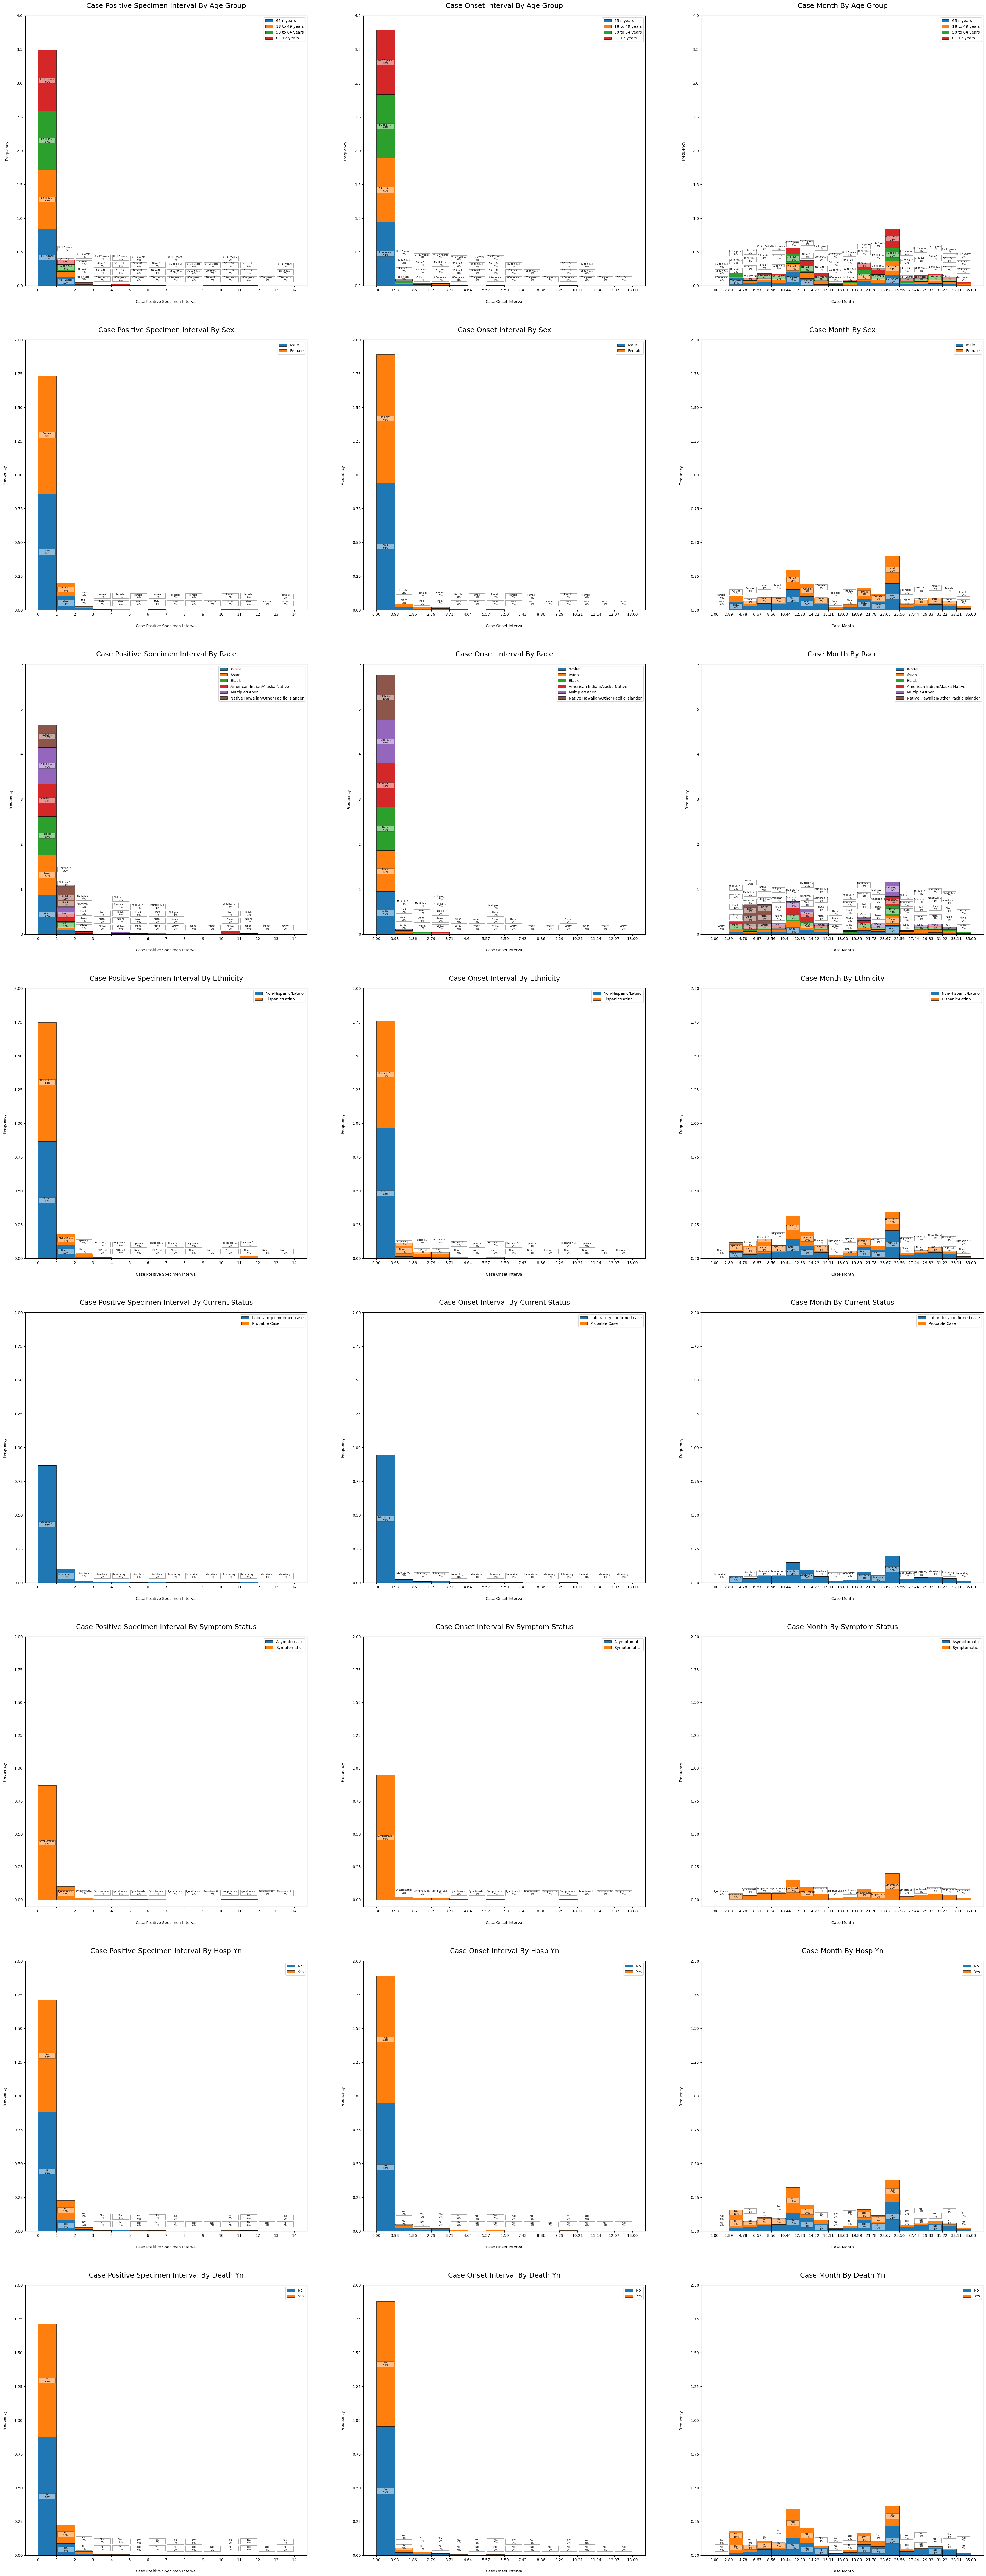

In [261]:
clean_categorical_data = ['age_group','sex','race','ethnicity','current_status','symptom_status','hosp_yn','death_yn']
clean_continuous_data = ['case_positive_specimen_interval','case_onset_interval', 'case_month']

clean_data['case_month'] = clean_data['case_month'].astype('datetime64[ns]')

fig, axs = plt.subplots(ncols=len(clean_continuous_data), nrows=len(clean_categorical_data), figsize=(45, 120), facecolor=facecolor)

for i, column in enumerate(clean_categorical_data):
    createStackedHistograms(clean_data, column, 'case_positive_specimen_interval', bin_count = 14, ax=axs[i][0], filterExp=lambda row: row['case_positive_specimen_interval'] <= 14)
    createStackedHistograms(clean_data, column, 'case_onset_interval', bin_count = 14, ax=axs[i][1], filterExp=lambda row: row['case_onset_interval'] <= 14)
    createStackedHistograms(clean_data, column, 'case_month', bin_count = 18, ax=axs[i][2])

### Categorical vs Categorical
We can create bar charts comparing all of the categorical features to each other and determine the most interesting relationships. They may allow us extra insight into who is more susceptible to falling ill and/or dying of Covid.

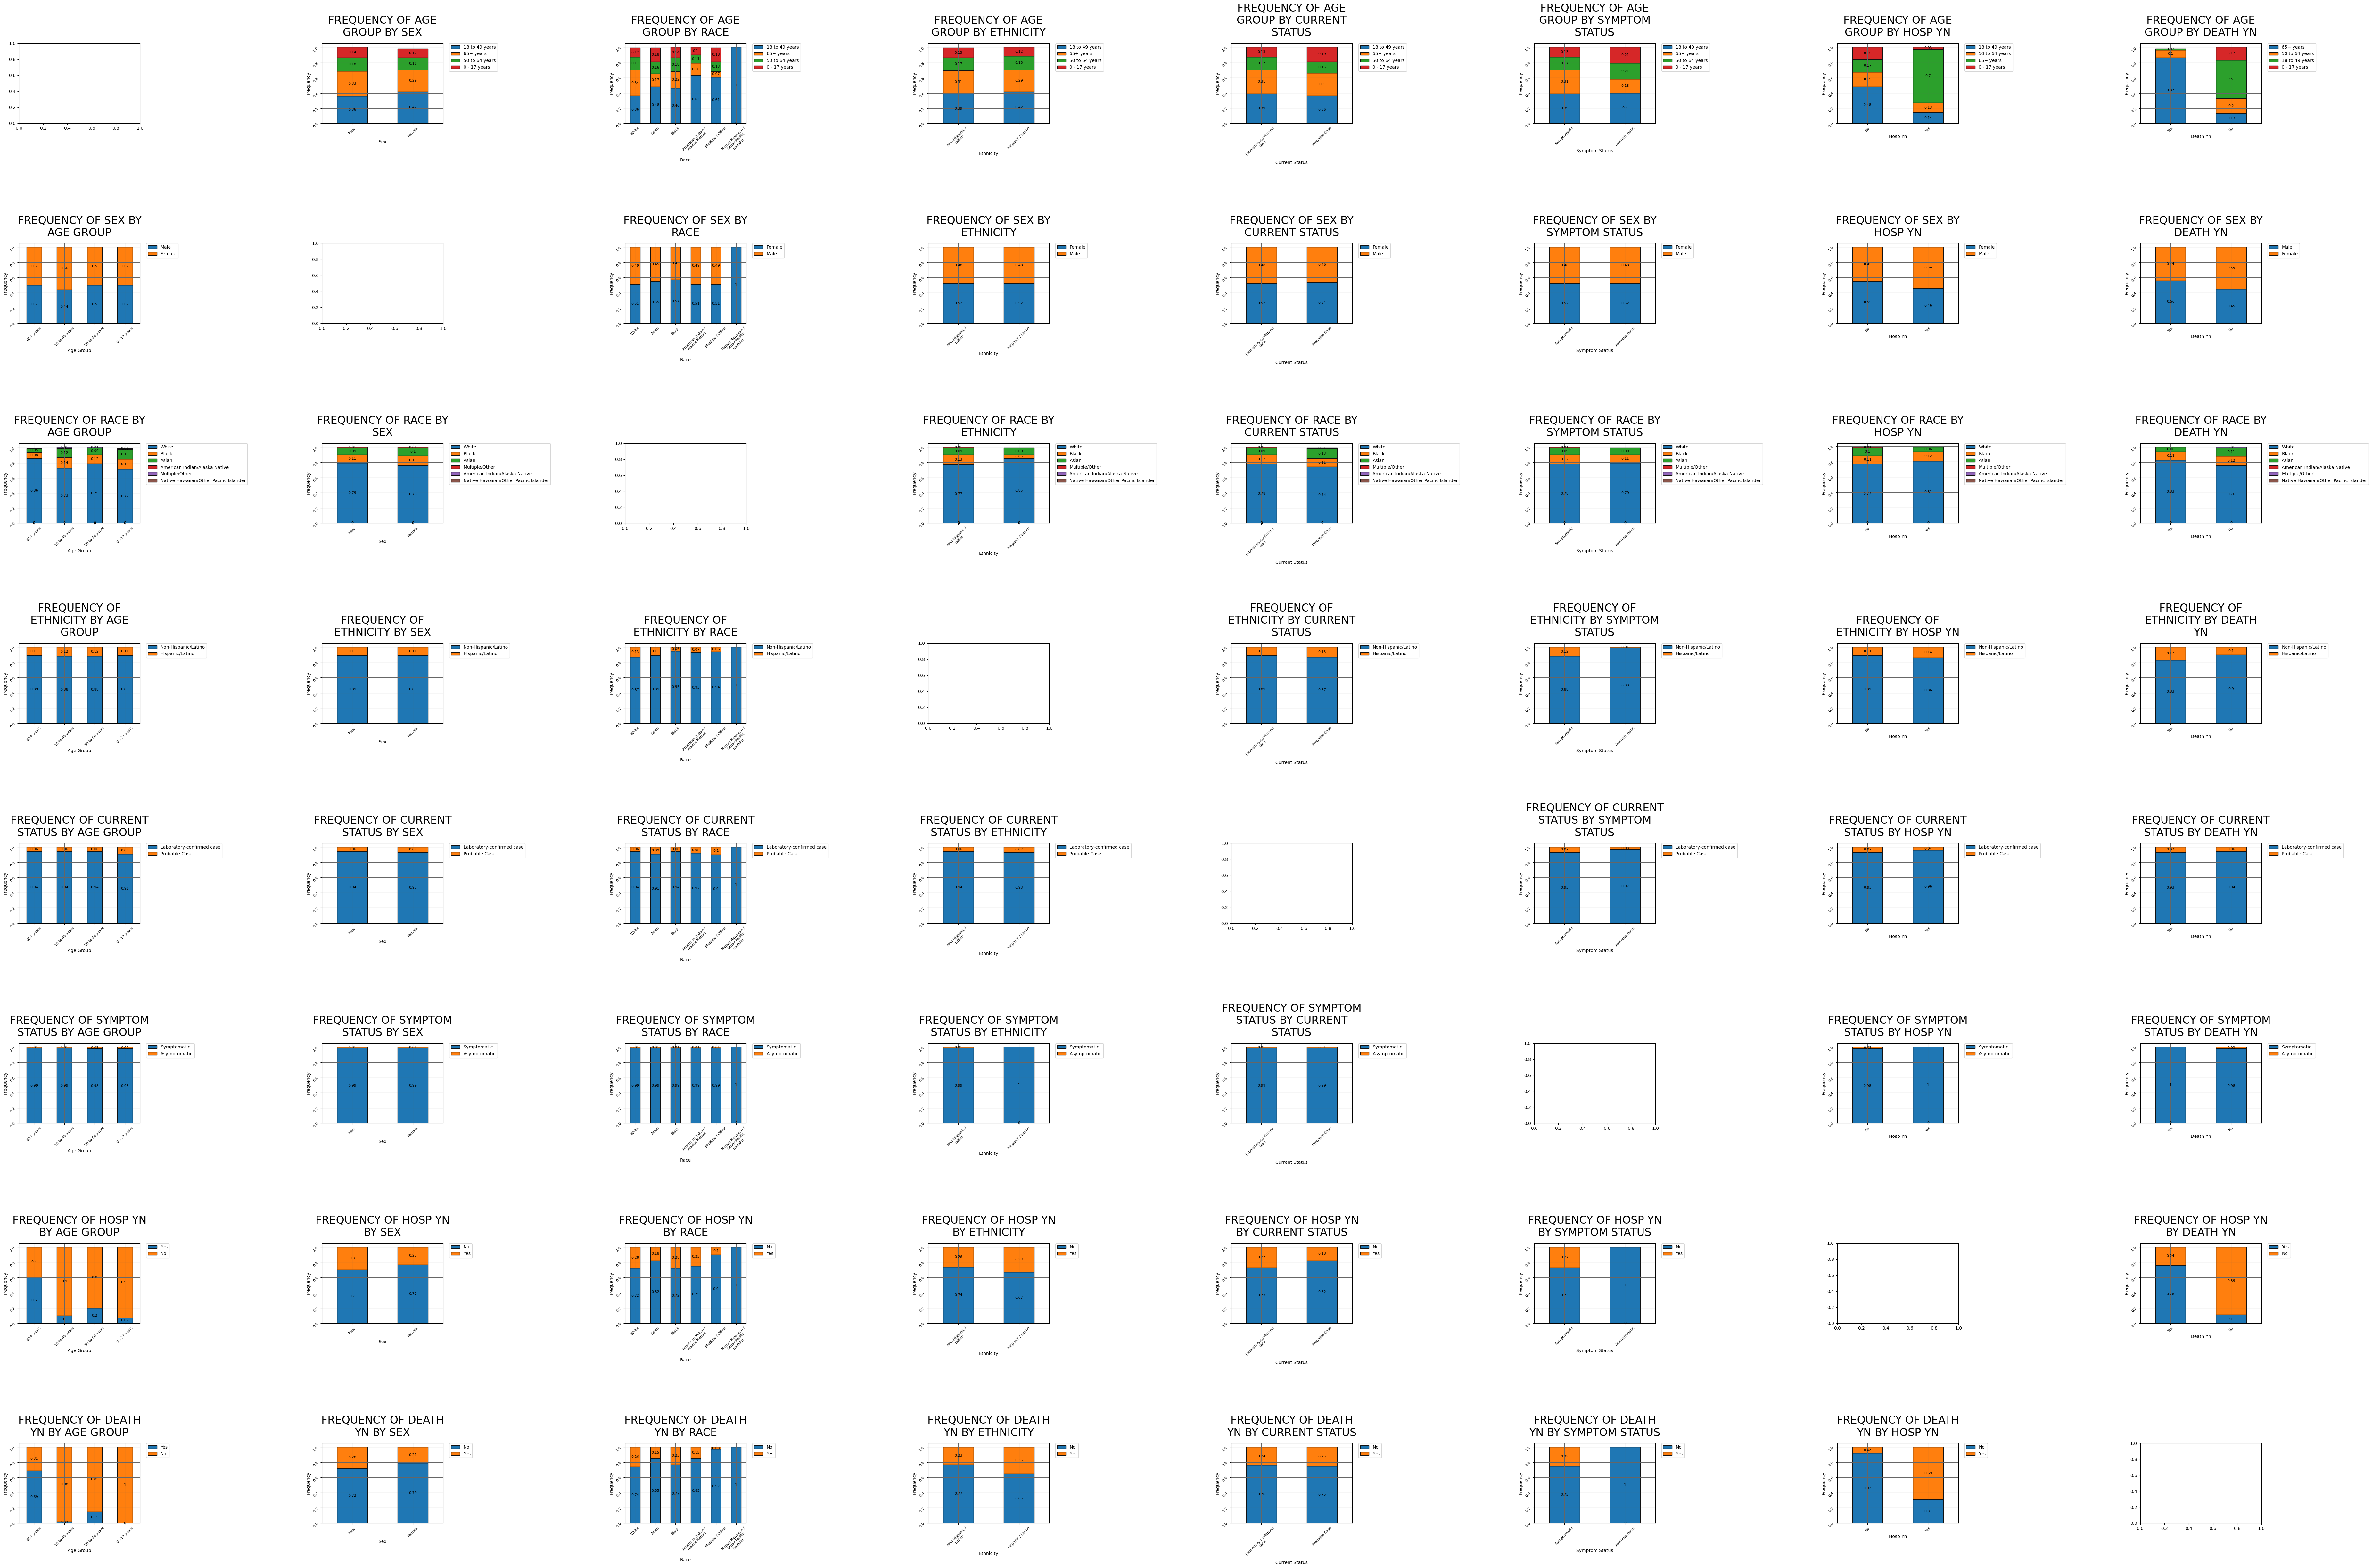

In [262]:
clean_categorical_data = ['age_group','sex','race','ethnicity','current_status','symptom_status','hosp_yn','death_yn']
n = len(clean_categorical_data)

fig, axs = plt.subplots(ncols=n, nrows=n, figsize=(50,60), facecolor=facecolor)

for i, column_x in enumerate(clean_categorical_data):
    for j, column_y in enumerate(clean_categorical_data):
        if i != j:
            createStackedBarChart(clean_data, column_x, column_y, axs, i, j)

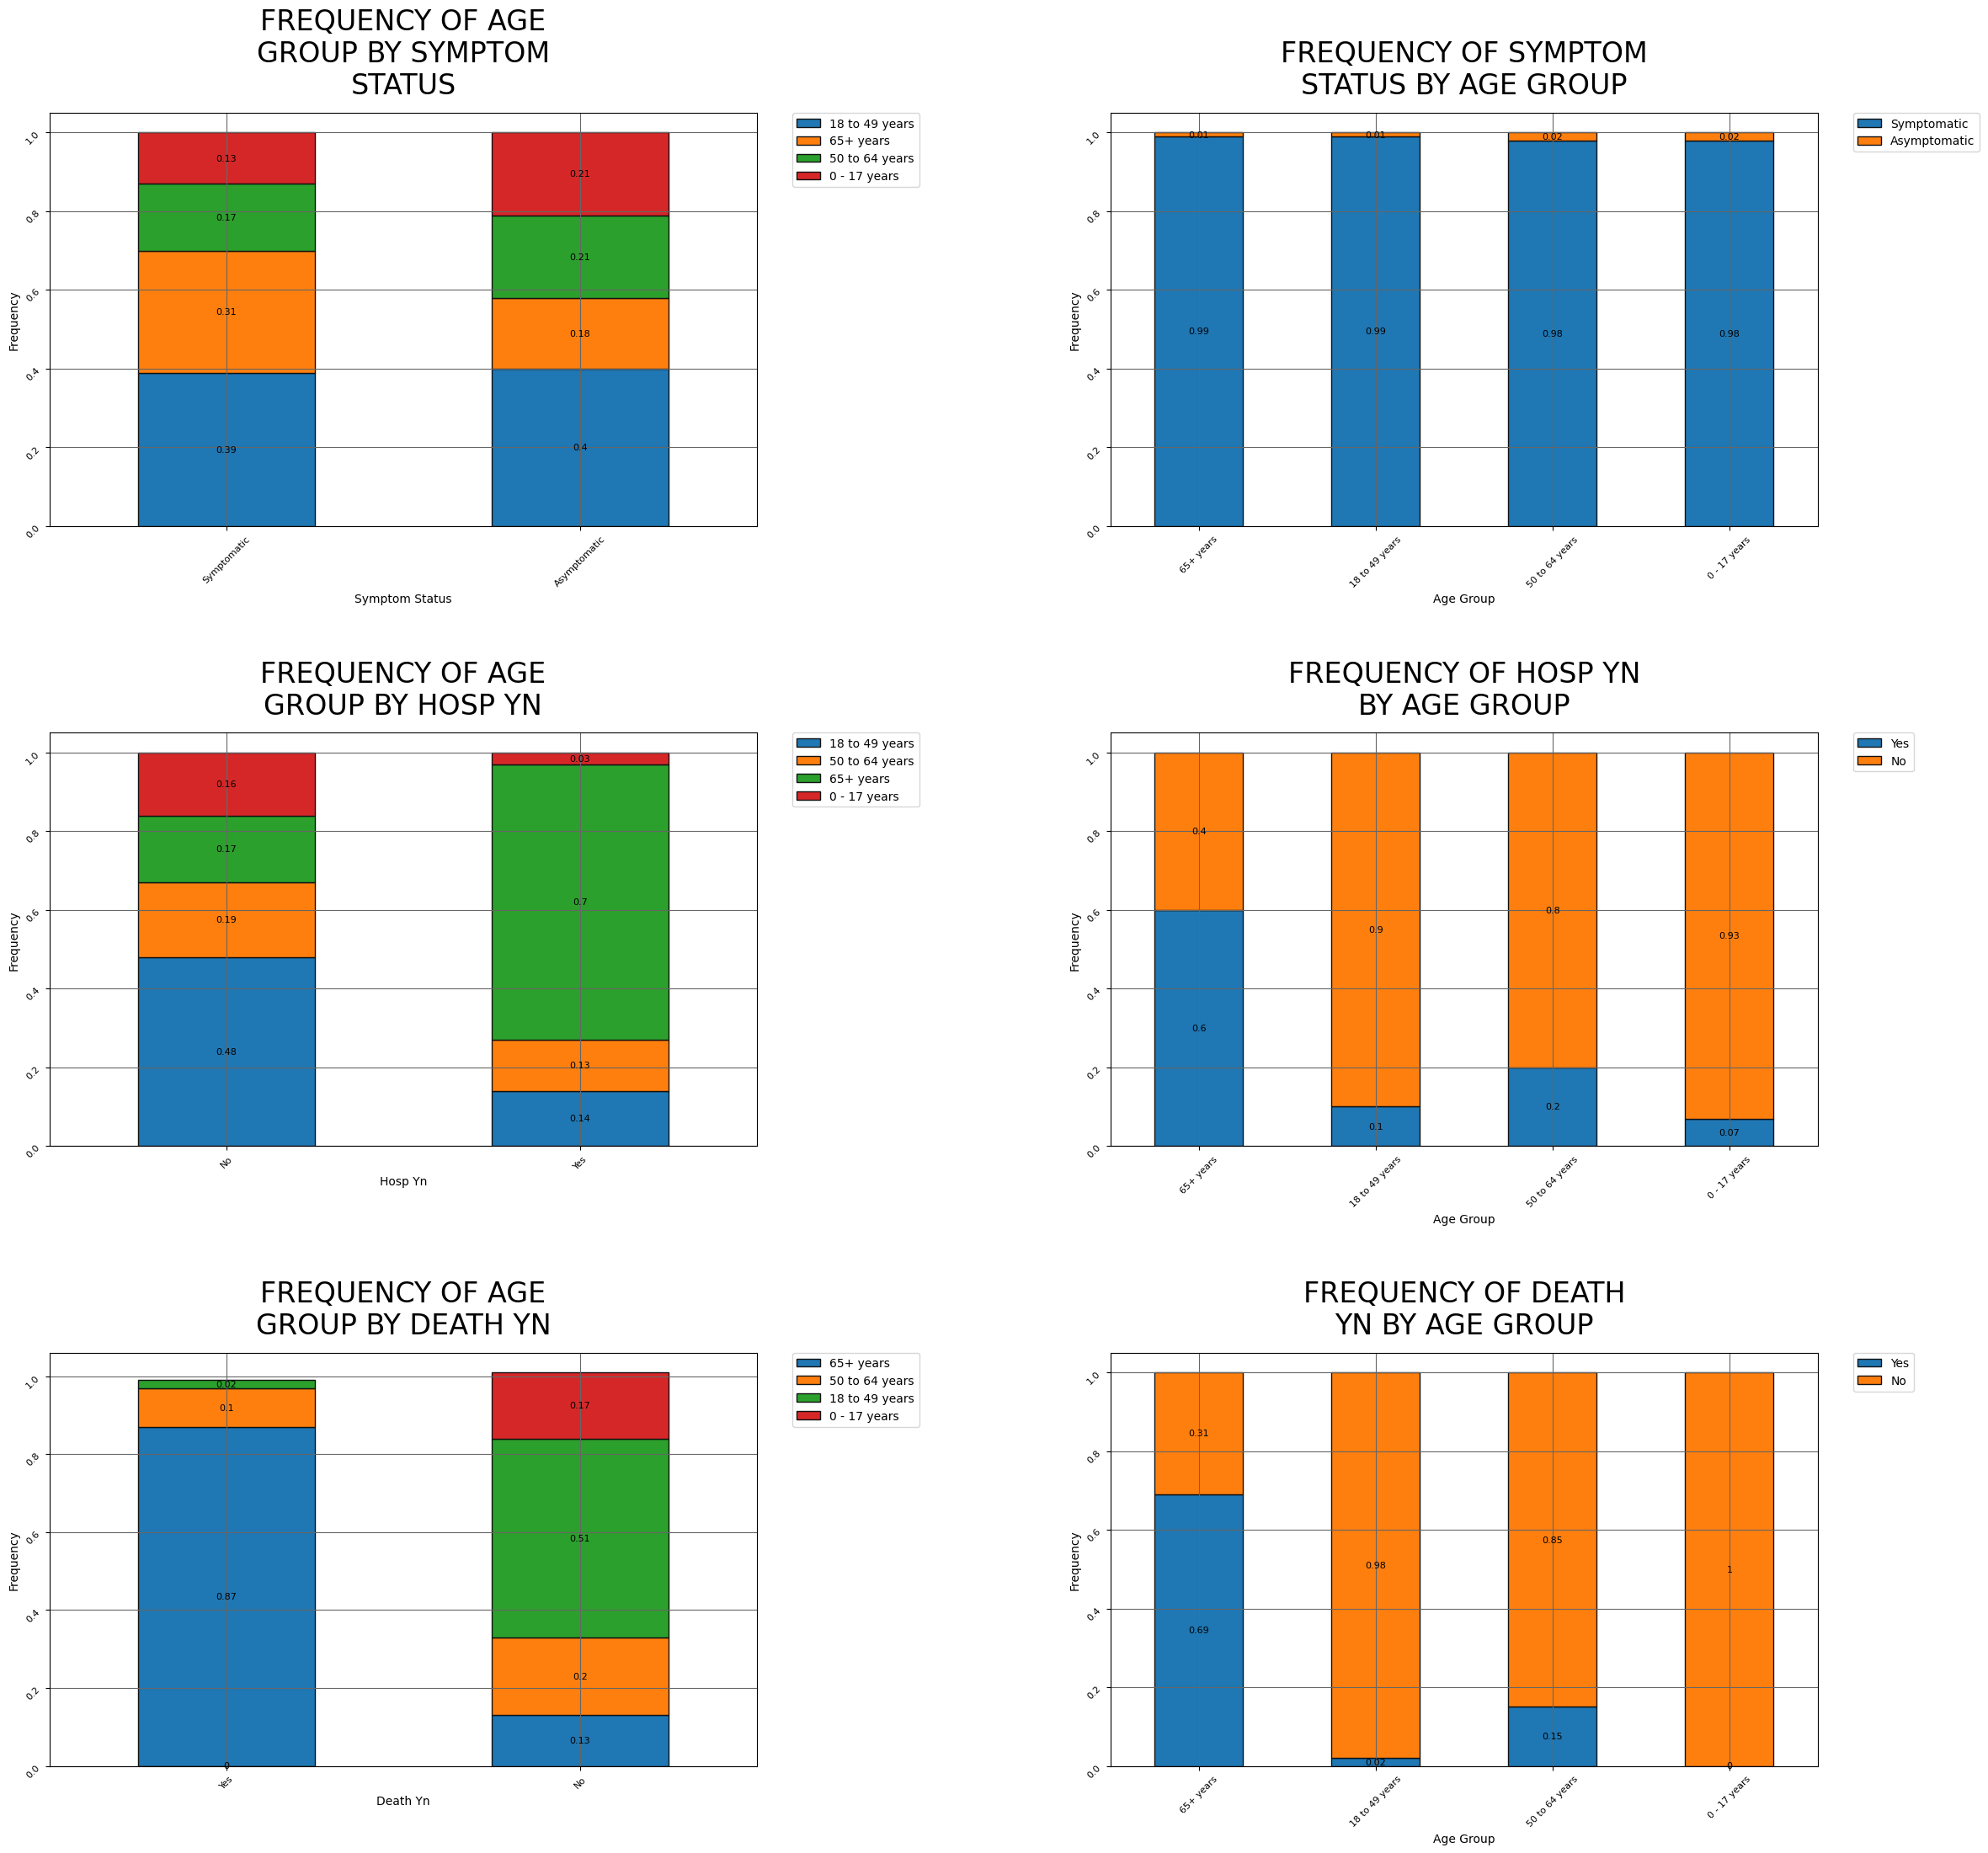

In [263]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 25.5), facecolor=facecolor)

createStackedBarChart(clean_data, 'age_group', 'symptom_status', axs=axs, i=0, j=0)
createStackedBarChart(clean_data, 'symptom_status', 'age_group', axs=axs, i=0, j=1)
createStackedBarChart(clean_data, 'age_group', 'hosp_yn', axs=axs, i=1, j=0)
createStackedBarChart(clean_data, 'hosp_yn', 'age_group', axs=axs, i=1, j=1)
createStackedBarChart(clean_data, 'age_group', 'death_yn', axs=axs, i=2, j=0)
createStackedBarChart(clean_data, 'death_yn', 'age_group', axs=axs, i=2, j=1)

plt.subplots_adjust(left=0.1, right=1.5, wspace=0.5, hspace=0.5)

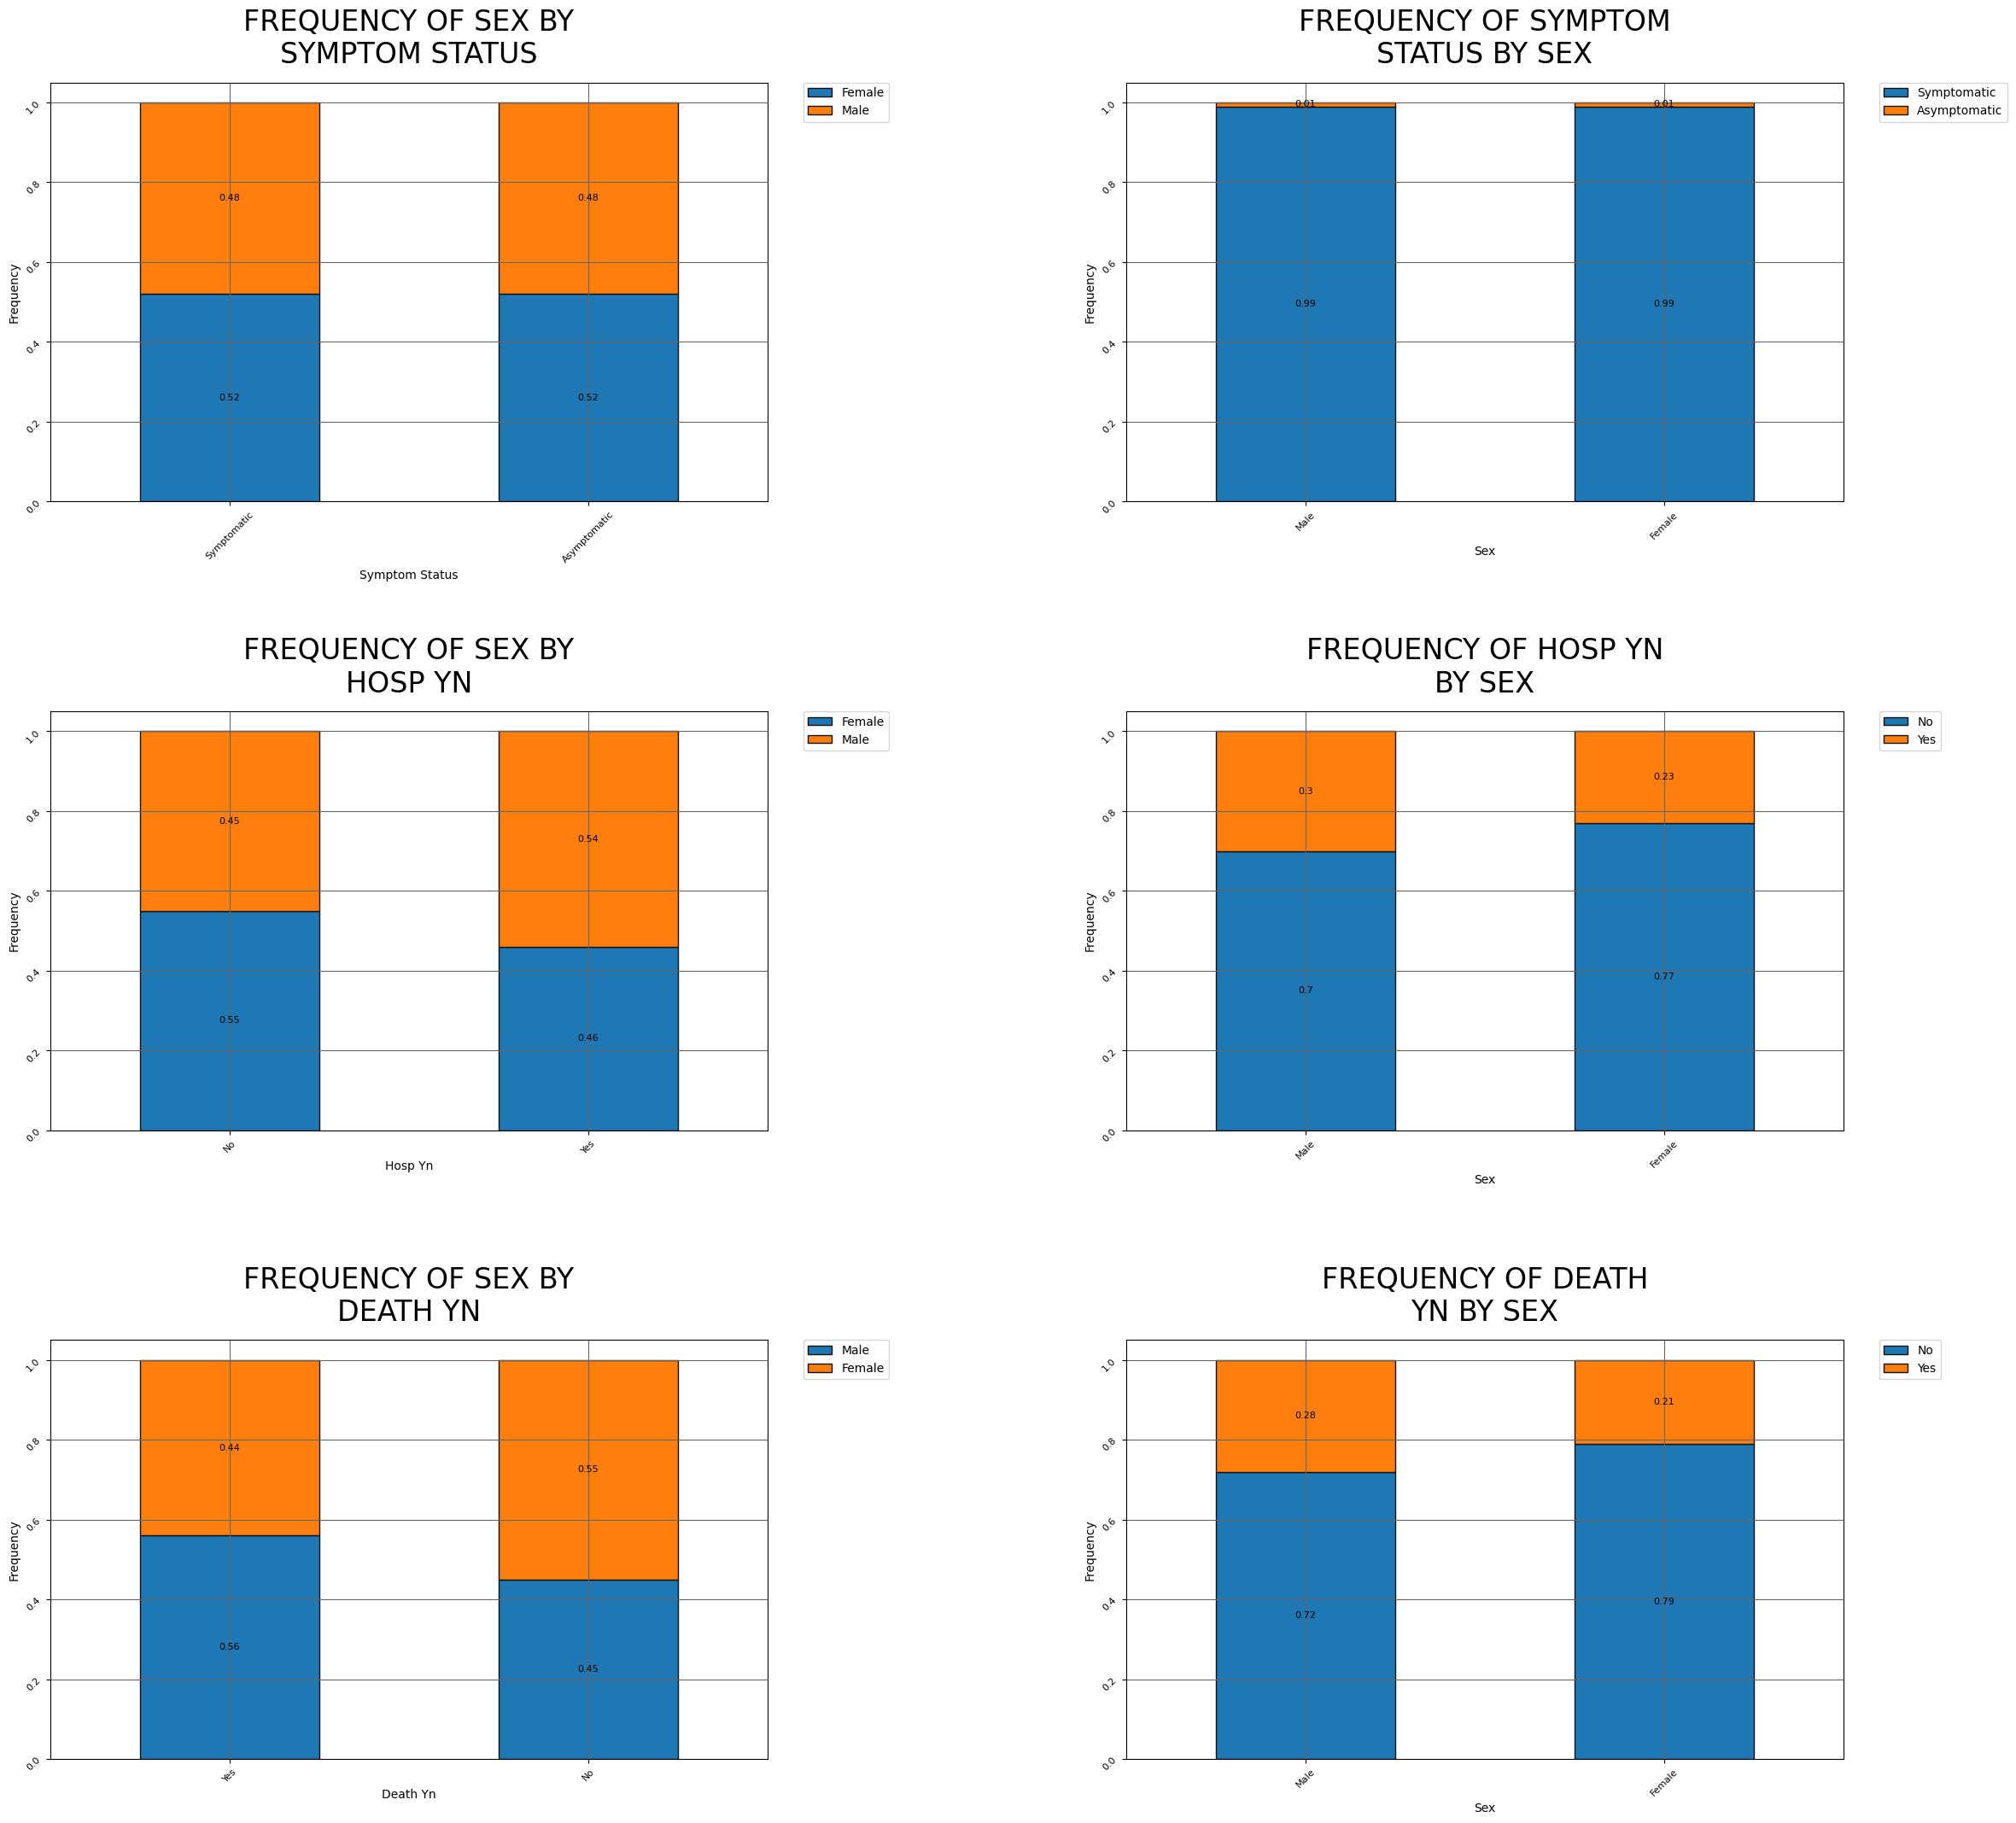

In [264]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 25.5), facecolor=facecolor)

createStackedBarChart(clean_data, 'sex', 'symptom_status', axs=axs, i=0, j=0)
createStackedBarChart(clean_data, 'symptom_status', 'sex', axs=axs, i=0, j=1)
createStackedBarChart(clean_data, 'sex', 'hosp_yn', axs=axs, i=1, j=0)
createStackedBarChart(clean_data, 'hosp_yn', 'sex', axs=axs, i=1, j=1)
createStackedBarChart(clean_data, 'sex', 'death_yn', axs=axs, i=2, j=0)
createStackedBarChart(clean_data, 'death_yn', 'sex', axs=axs, i=2, j=1)

plt.subplots_adjust(left=0.1, right=1.5, wspace=0.5, hspace=0.5)

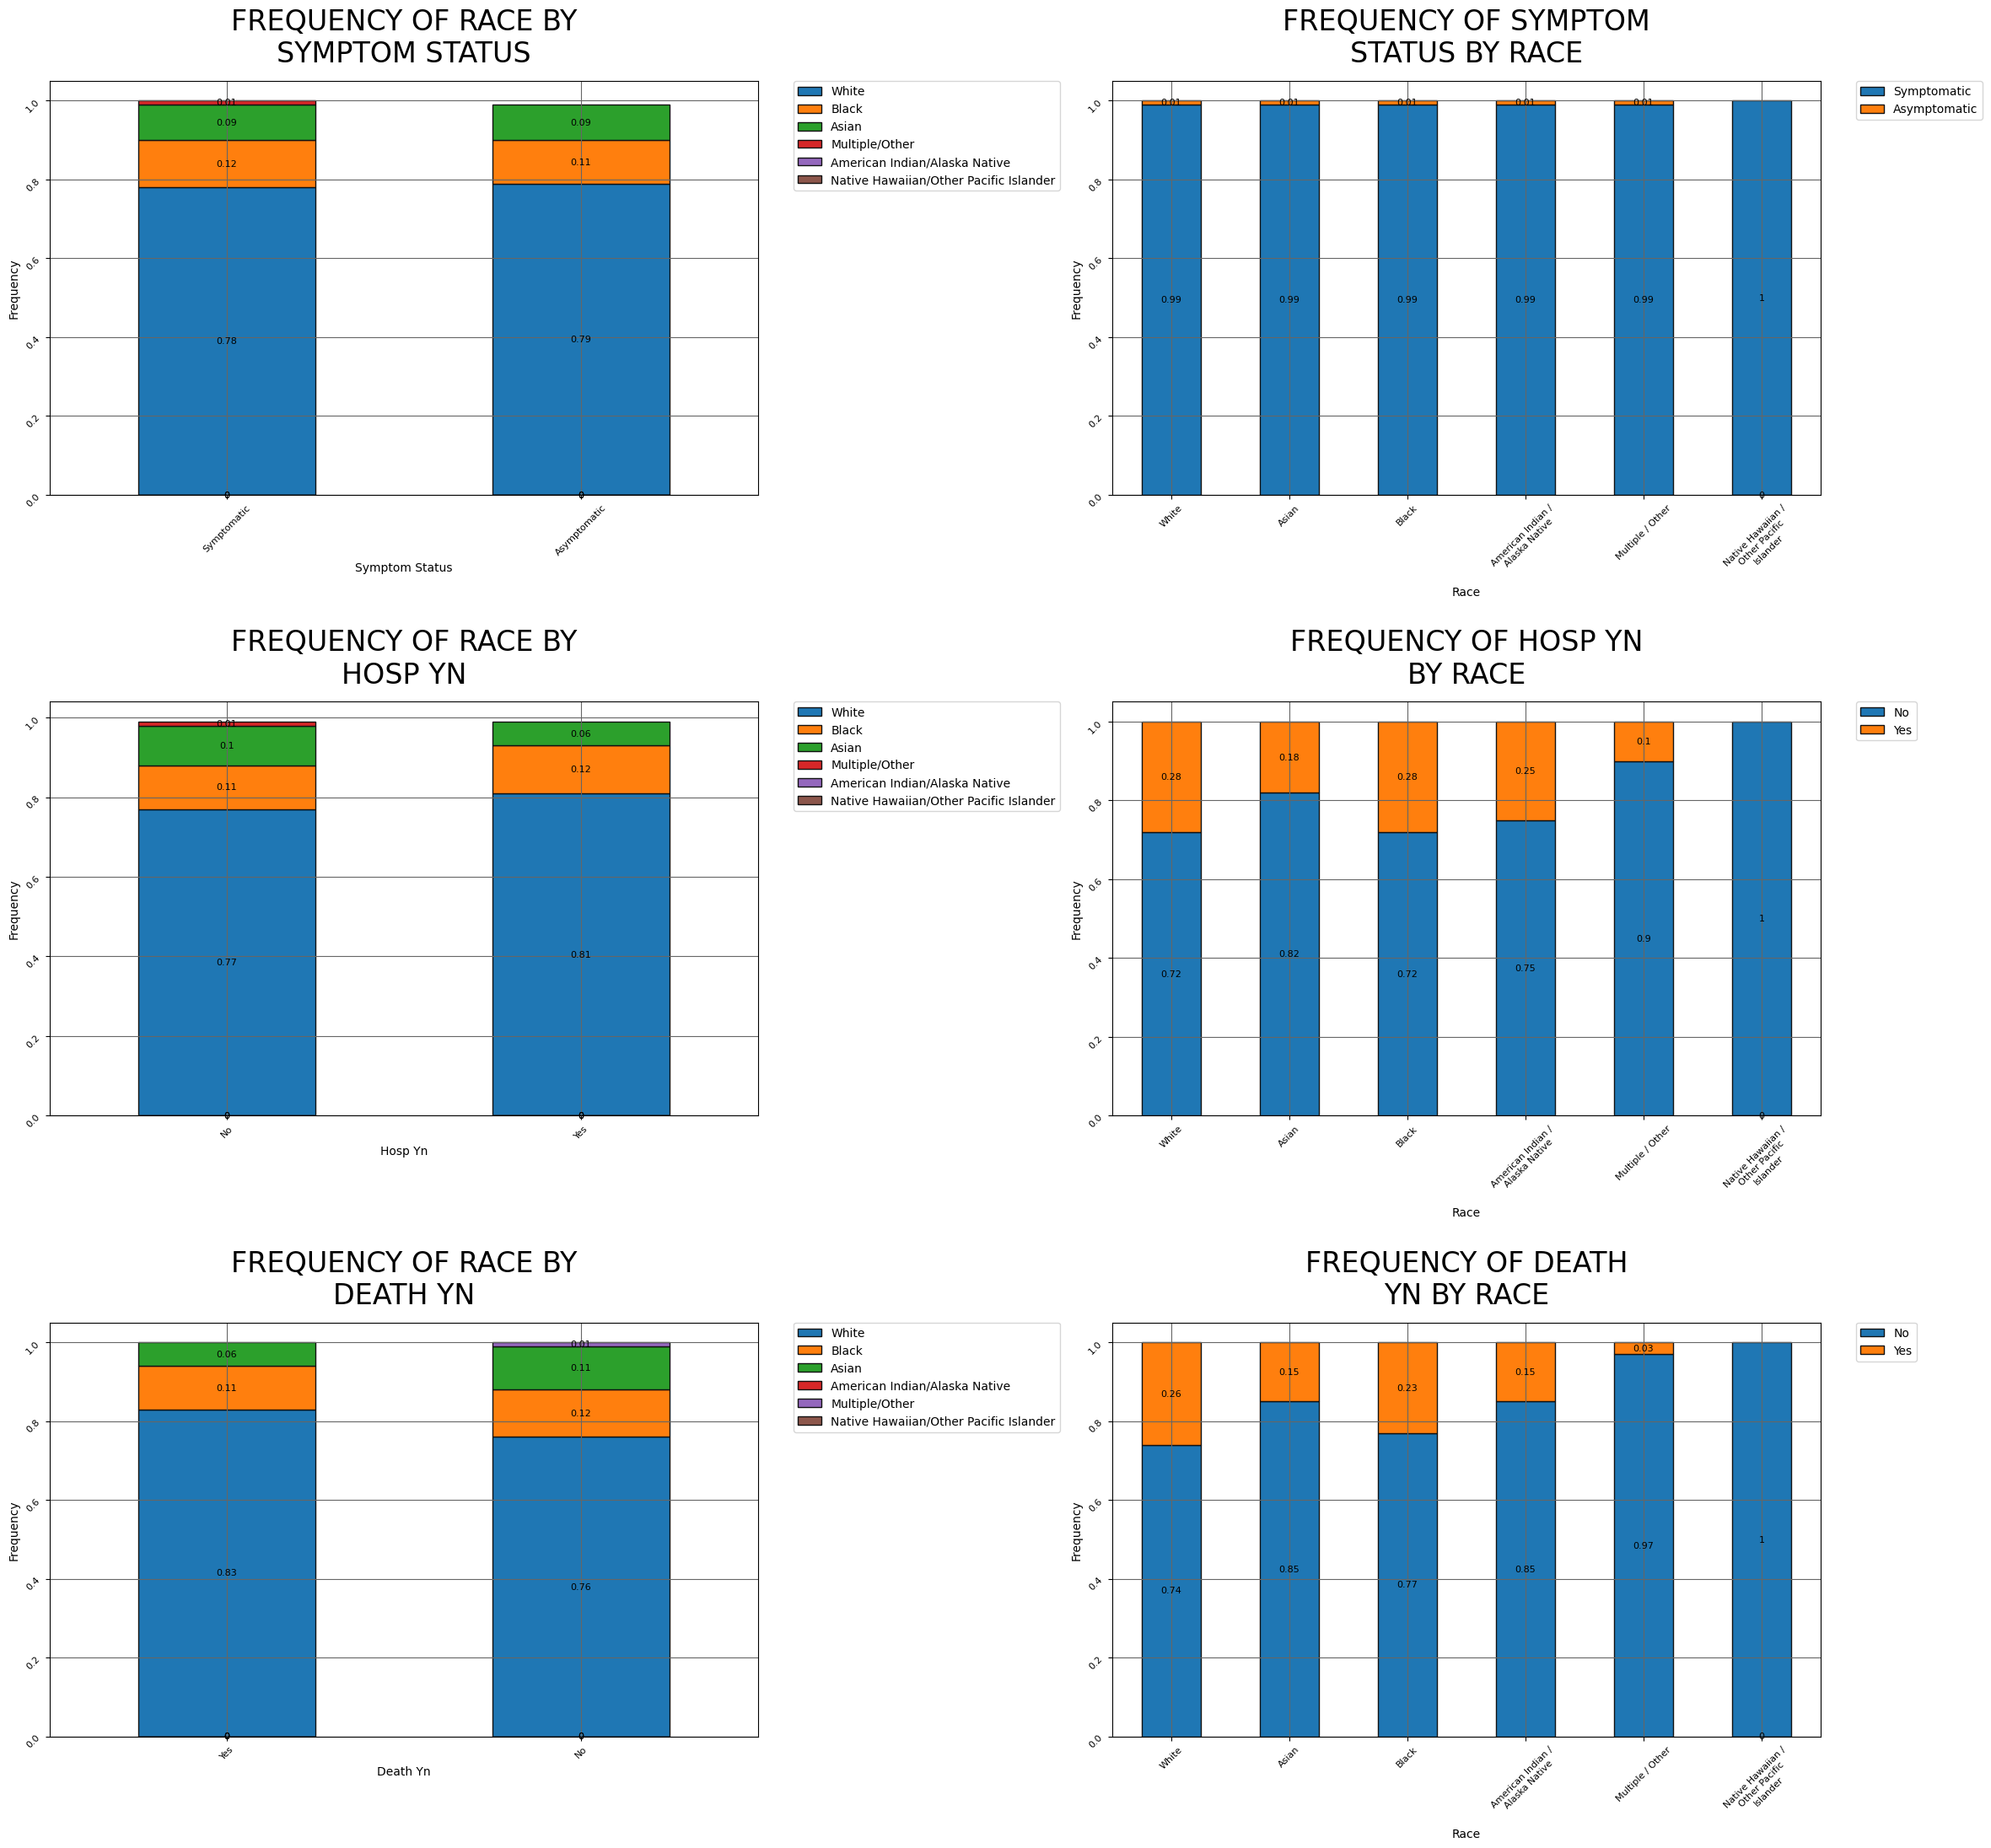

In [265]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 25.5), facecolor=facecolor)

createStackedBarChart(clean_data, 'race', 'symptom_status', axs=axs, i=0, j=0)
createStackedBarChart(clean_data, 'symptom_status', 'race', axs=axs, i=0, j=1)
createStackedBarChart(clean_data, 'race', 'hosp_yn', axs=axs, i=1, j=0)
createStackedBarChart(clean_data, 'hosp_yn', 'race', axs=axs, i=1, j=1)
createStackedBarChart(clean_data, 'race', 'death_yn', axs=axs, i=2, j=0)
createStackedBarChart(clean_data, 'death_yn', 'race', axs=axs, i=2, j=1)

plt.subplots_adjust(left=0.1, right=1.5, wspace=0.5, hspace=0.5)

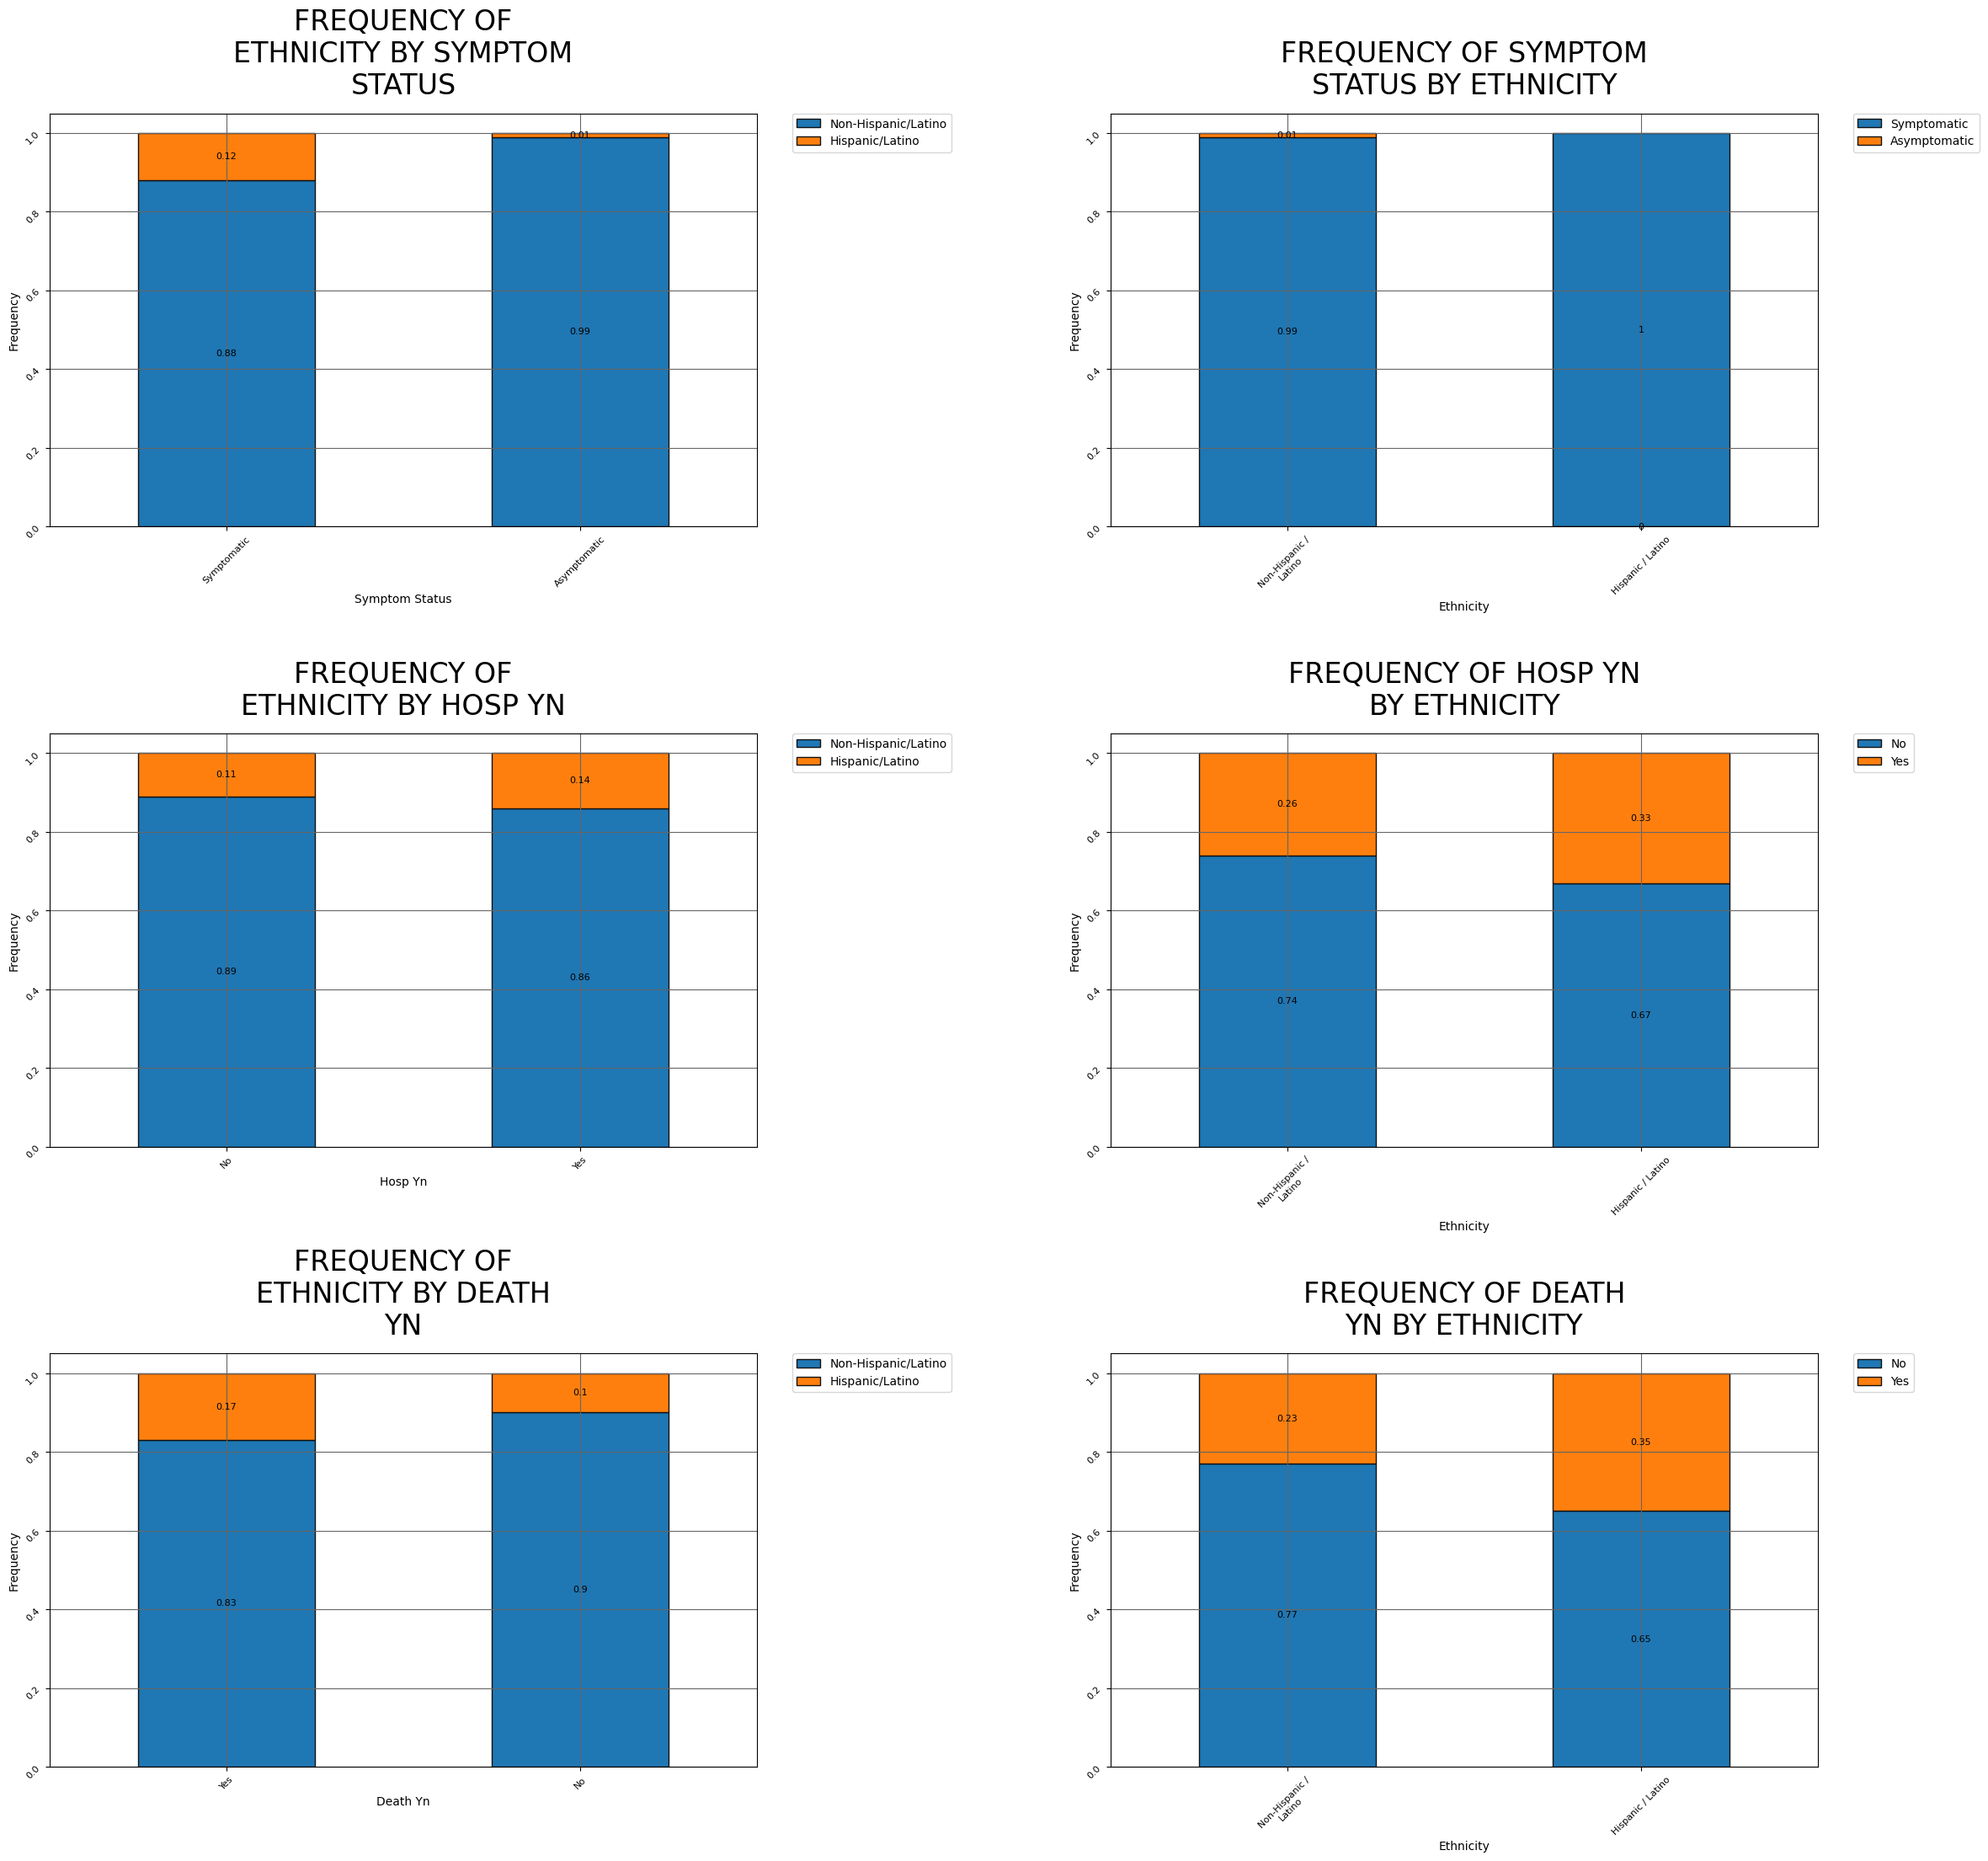

In [266]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 25.5), facecolor=facecolor)

createStackedBarChart(clean_data, 'ethnicity', 'symptom_status', axs=axs, i=0, j=0)
createStackedBarChart(clean_data, 'symptom_status', 'ethnicity', axs=axs, i=0, j=1)
createStackedBarChart(clean_data, 'ethnicity', 'hosp_yn', axs=axs, i=1, j=0)
createStackedBarChart(clean_data, 'hosp_yn', 'ethnicity', axs=axs, i=1, j=1)
createStackedBarChart(clean_data, 'ethnicity', 'death_yn', axs=axs, i=2, j=0)
createStackedBarChart(clean_data, 'death_yn', 'ethnicity', axs=axs, i=2, j=1)

plt.subplots_adjust(left=0.1, right=1.5, wspace=0.5, hspace=0.5)

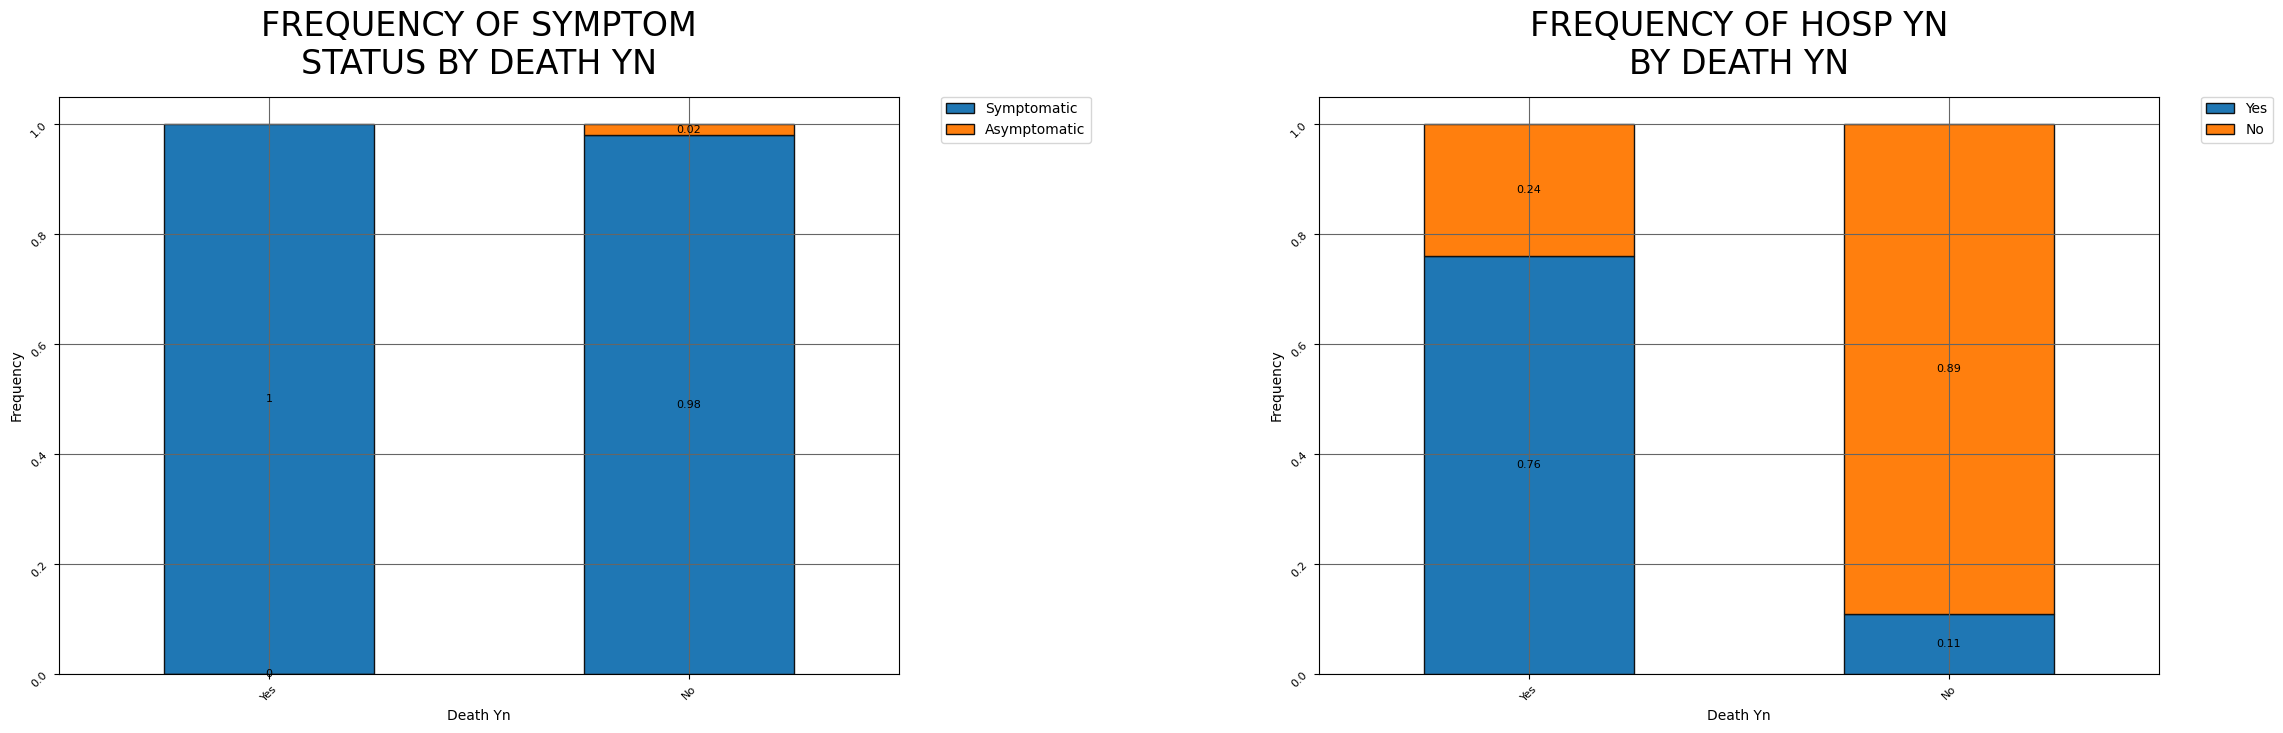

In [267]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7.5), facecolor=facecolor)

createStackedBarChart(clean_data, 'symptom_status', 'death_yn', axs=axs, j=0)
createStackedBarChart(clean_data, 'hosp_yn', 'death_yn', axs=axs, j=1)


plt.subplots_adjust(left=0.1, right=1.5, wspace=0.5, hspace=0.5)

### Running Assessment

#### Continuous vs Categorical

- There does not seem to be a strong correlation between the categorical and continuous data at our disposal.

#### Categorical vs Categorical

- We outlined a group of features that we thought might be indicative of a person's risk of death at the hands of Covid-19.
- The strongest correlation in features are those between demographics and outcomes. These are:
    * **Age_group vs outcome** Age is the strongest indicator of patient outcome. The older a patient, the greater the chances of showing symptoms, being hospitalized, and death.
    * 'age_group' vs 'symptom_status'
    * 'age_group' vs 'hosp_yn'
    * 'age_group' vs 'death_yn'  
    $~$
    * **Sex vs outcome** There seems to be a correlation with sex and patient death. A 'Male' patient is more likely to be hospitalized and to die than a 'Female' patient.
    * 'sex' vs 'hosp_yn'
    * 'sex' vs 'death_yn'  
    $~$
    * **Race vs outcome** There seems to be a correlation with race and patient death. A 'Black' patient is more likely to die of Covid than a 'White' patient.
    * 'race' vs 'death_yn'  
    $~$
    * **Ethnicity vs outcome** There seems to be a correlation with ethnicity and patient outcome. A 'Hispanic/Latino' patient is more likely to experience symptoms, to be hospitalized, and to die than a 'Non-Hispanic/Latino' patient.
    * 'ethnicity' vs 'symptom_status' status 
    * 'ethnicity' vs 'hosp_yn'
    * 'ethnicity' vs 'death_yn'  
$~$
- As expected there are also correlations between pairs of features that indicate a patient's status. These relationships are expected and not necessarily indicative of anything other than logical integrity because it follows that one would only happen after the other.
    * 'symtom_status' vs 'death_yn'
    * 'hosp_yn' vs 'death_yn'  
$~$

#### Continuos vs Continuous
* Continuous vs continuous feature plots were not compared, since the outcome feature is categorical. While there is likely a correlation between 'case_onset_interval' and 'case_symptom_onset_interval' (we know from background knowledge of the virus that symptom manifestation and lack thereof correlates with the results of a postive Covid test), neither of these are target features, and in both instances the vast majority of values are 0.

# Exercise 4 - Transform, extend or combine the existing features

* County Economic Status *https://www.openintro.org/data/?data=county_complete*
* Vaccination % *https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations/vaccinations.csv*
* 'High Risk Population' combined feature, 1 if part of the susceptible population, 0 if not

### Feature 1

The first additional feature we will look at is county median income level. There is likely some correlation between the amount of money some one has and their access to healthcare. To begin to examine this, we have imported county level income data from openintro.org. This data will not give us insight into the income level of the individual patient, but may be the county information is enough to begin to see a trend.

In [268]:
data_to_transform = clean_data.copy()

print(data_to_transform['county_fips_code'].nunique())
income_data = pd.read_csv('data/new-data/county_2019.csv', keep_default_na=True)
income_data = income_data[['fips', 'median_household_income']]

data_to_transform = pd.merge(data_to_transform, income_data, how = 'left', left_on='county_fips_code', right_on = 'fips')
data_to_transform = data_to_transform.drop('fips', axis=1)
data_to_transform = data_to_transform.rename(columns={'median_household_income': 'income'})

data_to_transform['income'] = data_to_transform['income'].astype('Int64')
mode_income = data_to_transform['income'].mode()[0] # get the mode value
data_to_transform['income'] = data_to_transform['income'].fillna(mode_income)

data_to_transform.head()

1240


case_month  county_fips_code  age_group   sex   race            ethnicity  \
0 2020-12-01             24021  65+ years  Male  White  Non-Hispanic/Latino   
1 2021-12-01              6059  65+ years  Male  White  Non-Hispanic/Latino   
2 2020-01-01             13000  65+ years  Male  White  Non-Hispanic/Latino   
3 2020-11-01             20173  65+ years  Male  White  Non-Hispanic/Latino   
4 2020-07-01             48201  65+ years  Male  White  Non-Hispanic/Latino   

   case_positive_specimen_interval  case_onset_interval  \
0                                0                    0   
1                                0                   10   
2                                0                    0   
3                                0                    0   
4                                0                    3   

              current_status symptom_status hosp_yn death_yn  income  
0  Laboratory-confirmed case    Symptomatic      No      Yes   97730  
1  Laboratory-confirmed case    Symptomatic     Yes      Yes   90234  
2  Laboratory-confirmed case    Symptomatic     Yes      Yes   51347  
3  Laboratory-confirmed case    Symptomatic     Yes      Yes   56524  
4  Laboratory-confirmed case    Symptomatic     Yes      Yes   61705

min: 26272 max 142299


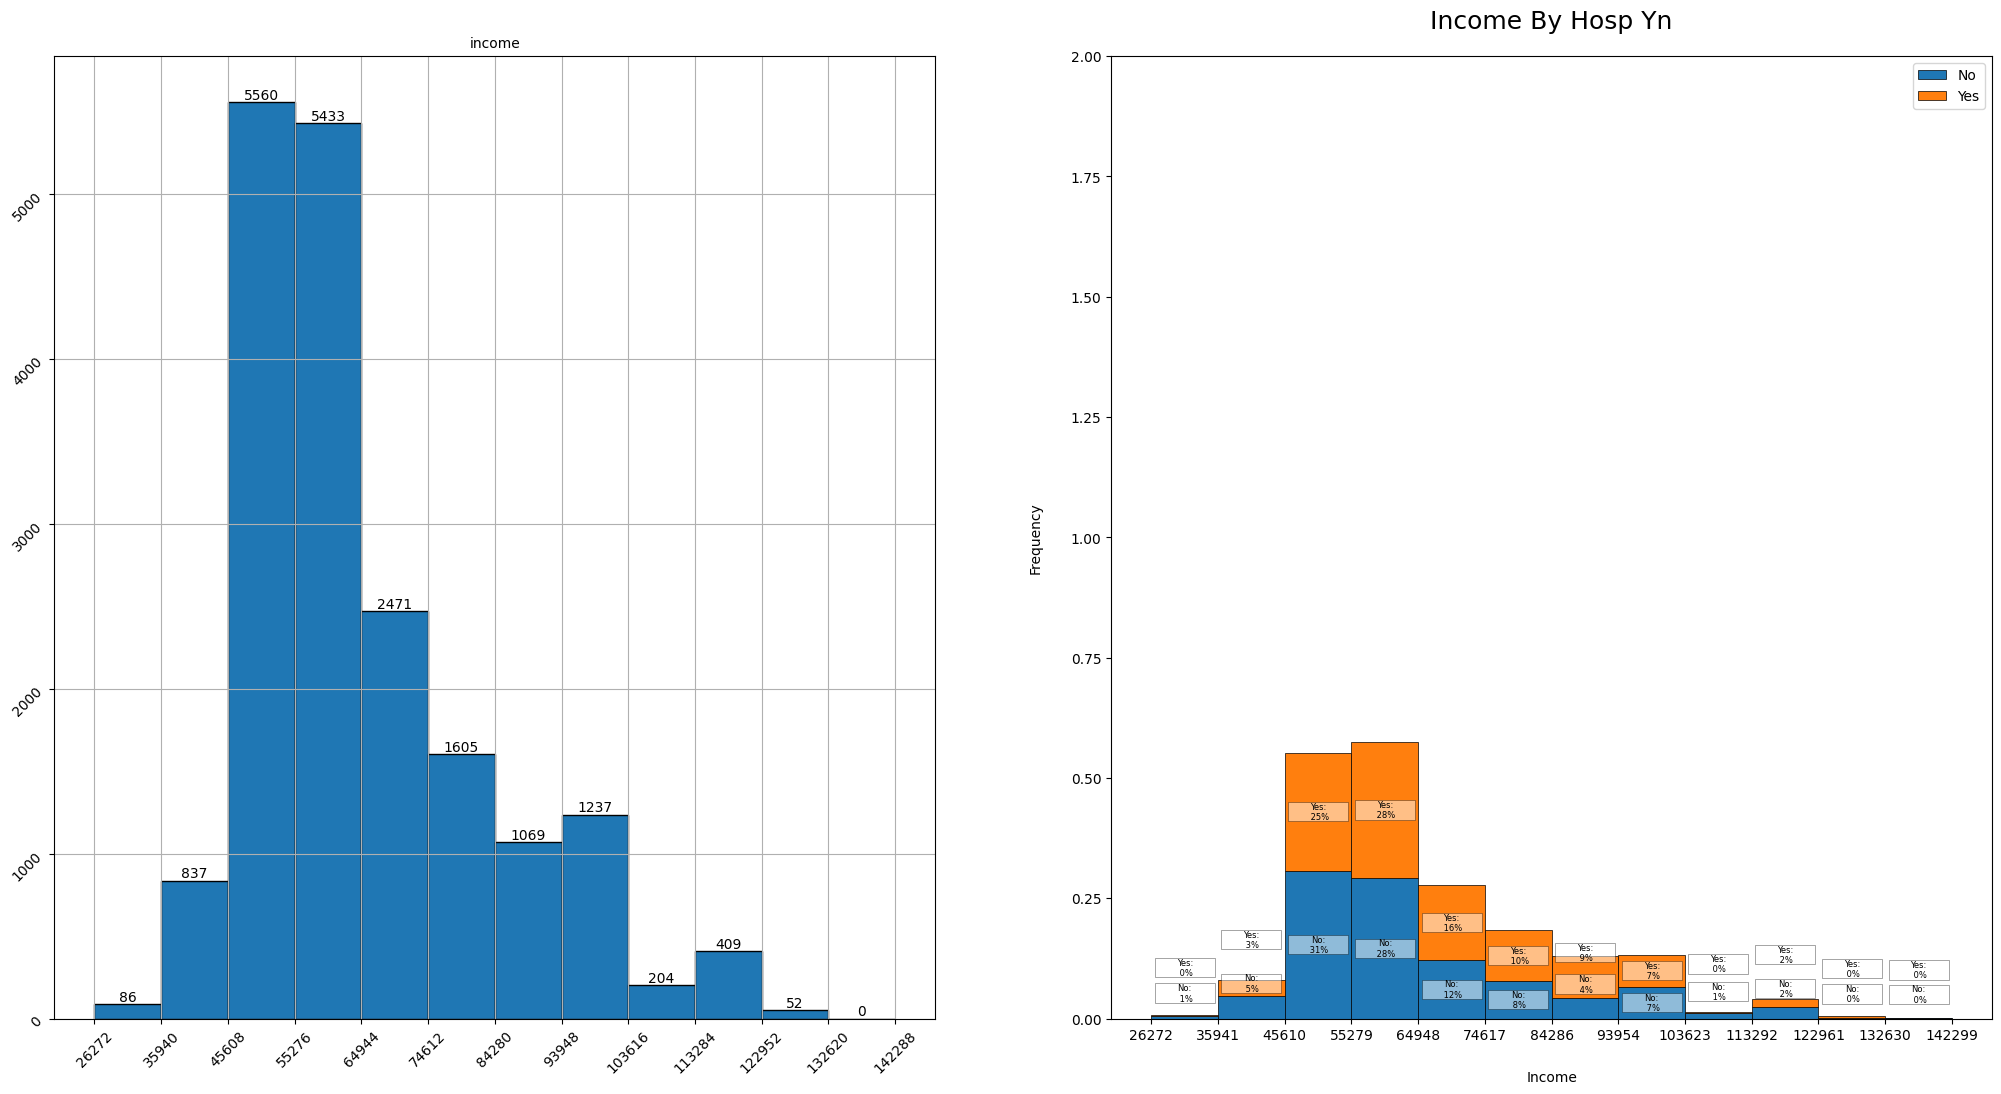

In [269]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 12.5), facecolor=facecolor)

createHistogram(data_to_transform, 'income', axs[0], bin_count =12)
createStackedHistograms(data_to_transform, 'hosp_yn', 'income', bin_count = 12, ax=axs[1])

There is not a very strong correlation between hospitalization and income, though this may change in the feature and could benefit from a more granular analysis. This income level is based on state, where other factors influence a patient's access to healthcare, and although the average income level of a county or state is lower, the average cost of healthcare is likely proportionally lower. A more benefitial metric could be income level of the patient vs average county income level.

### Feature 2

The next additional feature we want to incorporate in our dataset is correlation with the vaccination rates. We've downloaded some data on the number of vaccines administered worldwide, will filter out data from the United States, and append the total number of vaccinations by the 'case_month' to our table. This number should have a big influence on deadliness of the virus. Although the usefulness of this data from a predictive perspective is questionable, it can prove the utility of a 'vaccination_status' for the patient column for the dataset moving forward, since, as we may be about to see, there is likely a correlation with the advent of the vaccines and the number of deaths arising as a result of Covid-19.

In [270]:
data_to_transform2 = data_to_transform.copy()

vaccination_data = pd.read_csv('data/new-data/vaccinations.csv', keep_default_na=True)

vaccination_data = vaccination_data[['date', 'people_vaccinated']].loc[vaccination_data['location']=='United States']
vaccination_data['date'] = vaccination_data['date'].astype('datetime64[ns]')

vaccination_data['date'] = vaccination_data['date'].apply(lambda x: x.strftime('%Y-%m-01')).astype('datetime64[ns]')
vaccination_data = vaccination_data.groupby(vaccination_data['date']).agg({'people_vaccinated': 'max'}).reset_index()

data_to_transform2 = pd.merge(data_to_transform2, vaccination_data, how = 'left', left_on='case_month', right_on = 'date')
data_to_transform2 = data_to_transform2.drop('date', axis=1)
data_to_transform2['people_vaccinated'] = data_to_transform2['people_vaccinated'].fillna(0)
data_to_transform2['people_vaccinated'] = data_to_transform2['people_vaccinated'].astype('Int64')

min: 0 max 267676647


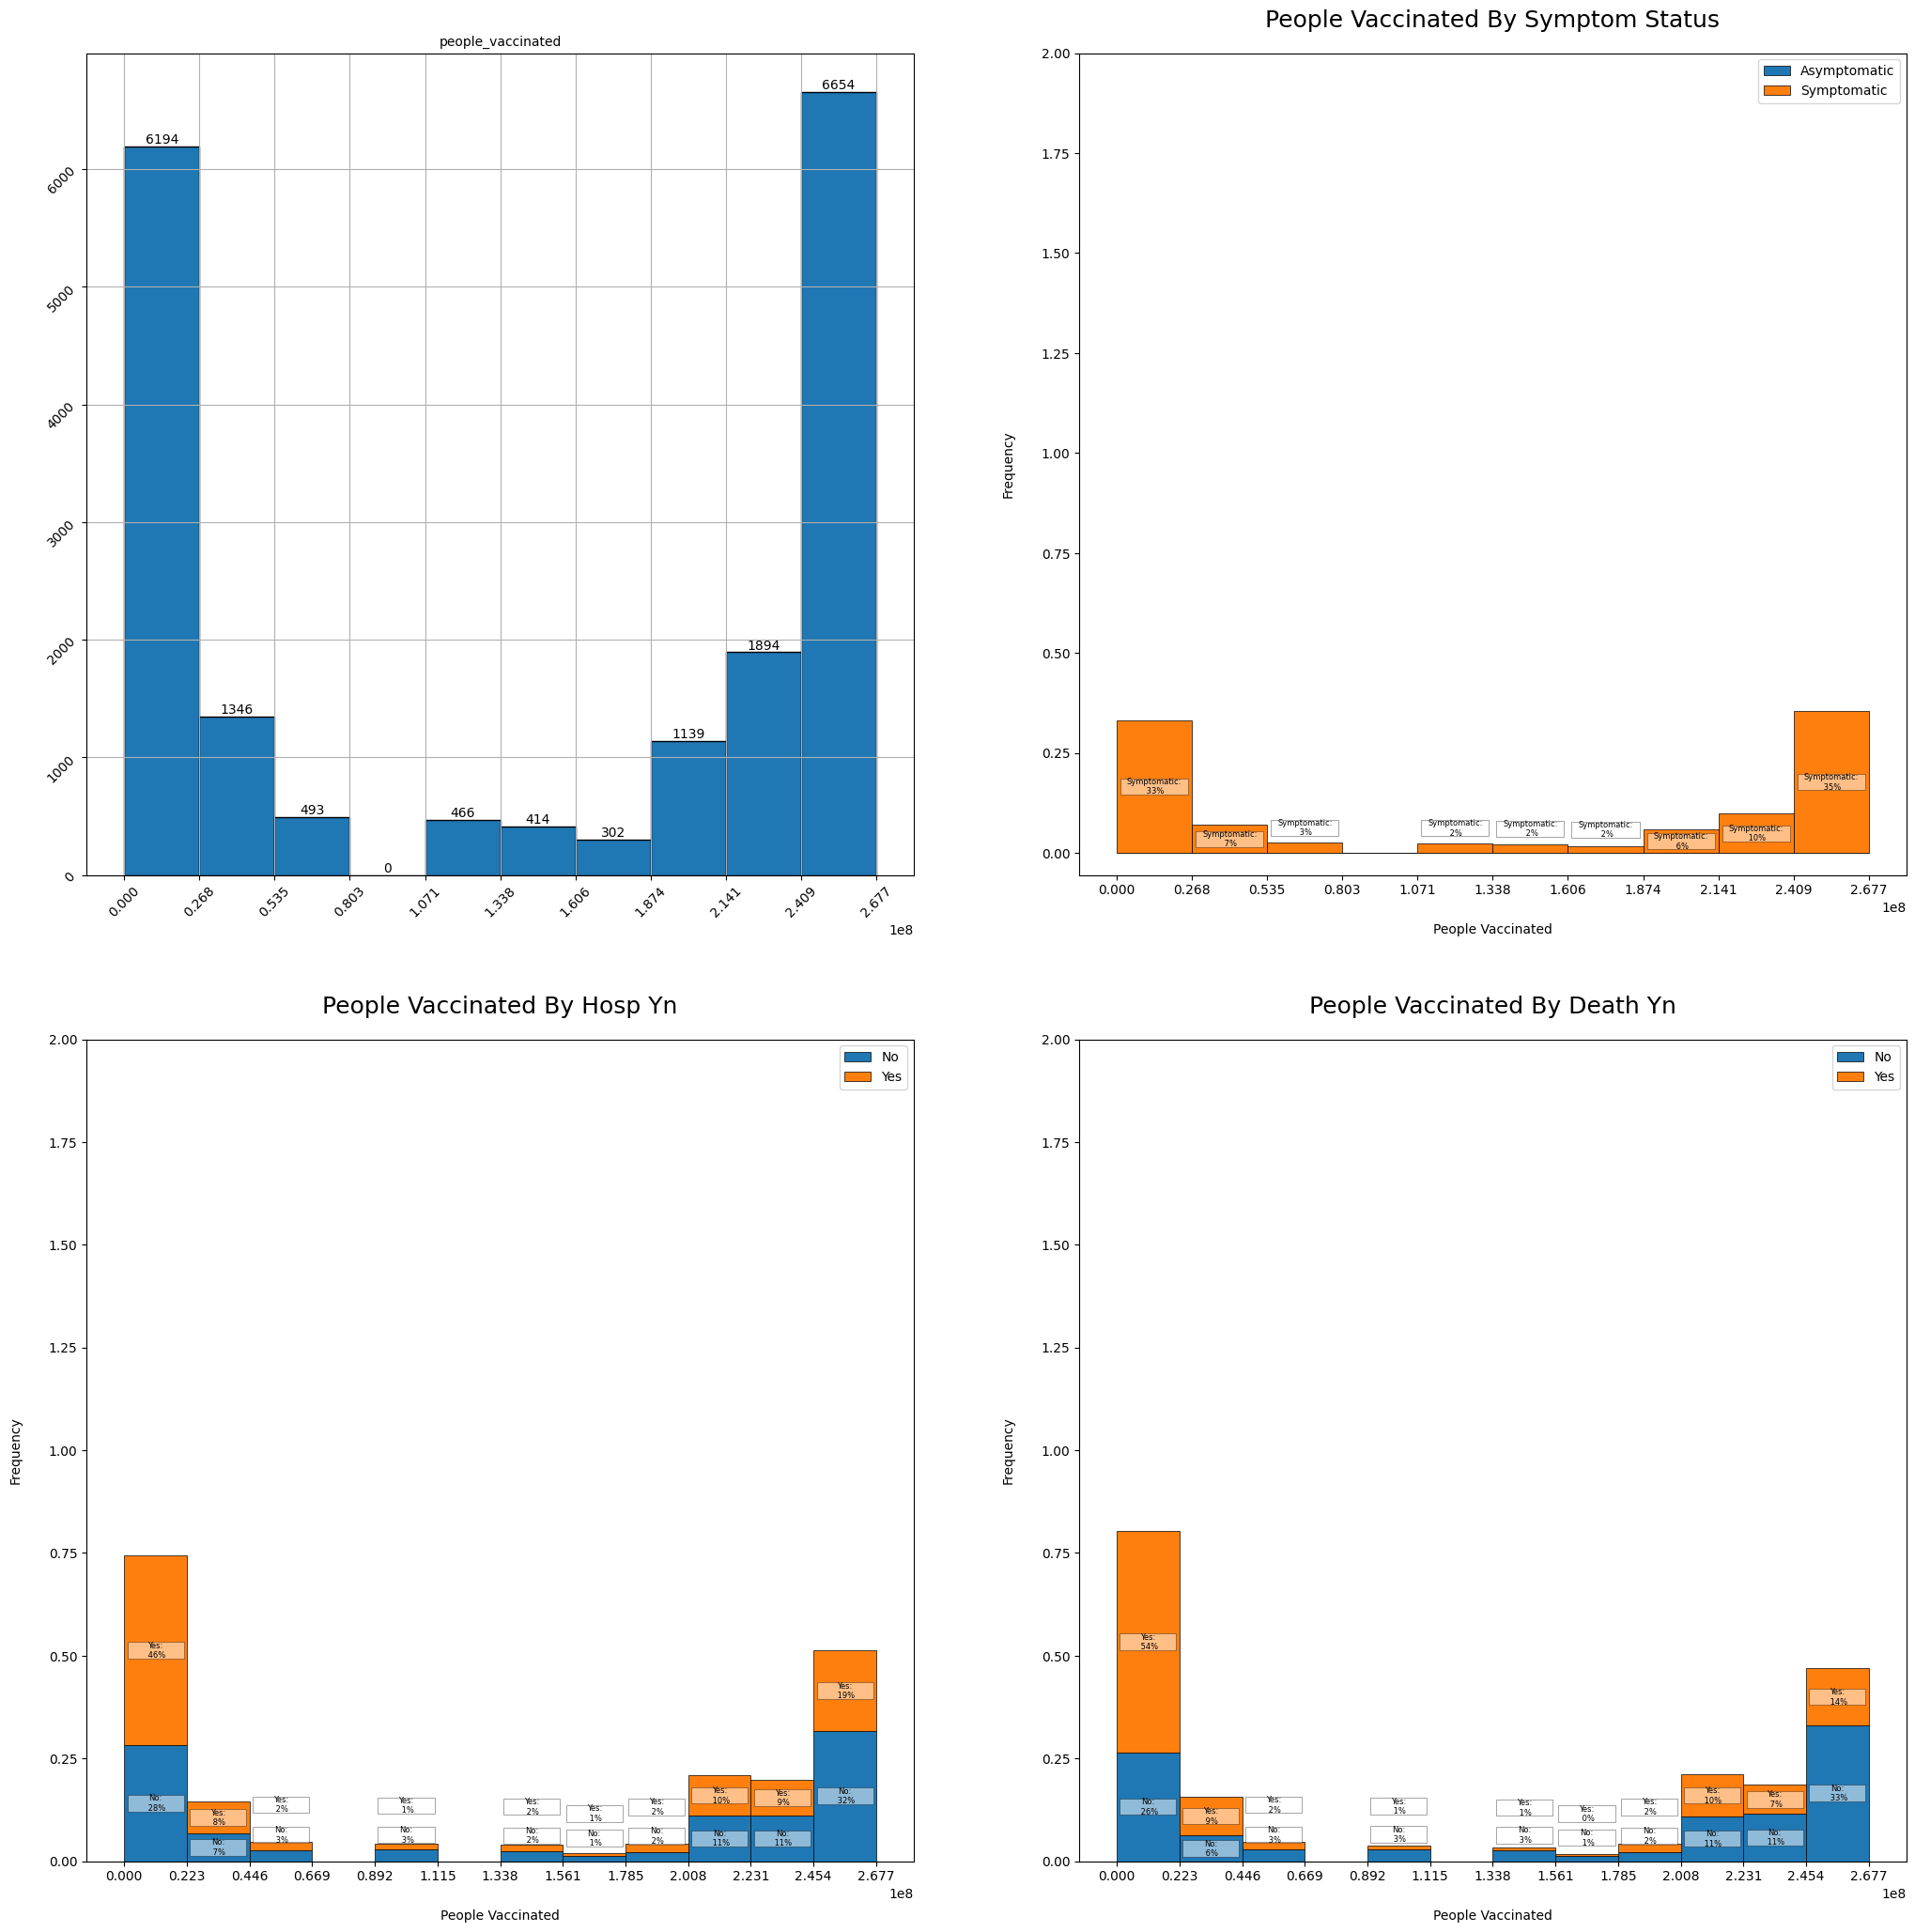

In [271]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(25, 25), facecolor=facecolor)


createHistogram(data_to_transform2, 'people_vaccinated', axs[0][0], bin_count = 10)
createStackedHistograms(data_to_transform2, 'symptom_status', 'people_vaccinated', bin_count = 10, ax=axs[0][1], )
createStackedHistograms(data_to_transform2, 'hosp_yn', 'people_vaccinated', bin_count = 12, ax=axs[1][0])
createStackedHistograms(data_to_transform2, 'death_yn', 'people_vaccinated', bin_count = 12, ax=axs[1][1])

**Running Assessment**

* In the months before the vaccine (first bin), the % of hospitalized patients and % of deaths is greater than % non-hospitalized and % death.
* It may be more beneficial to convert this feature to a binary 'Vaccine Not Released' and 'Vaccine Released' column
* This data is not perhaps not best suited for a predictive model, as now that the vaccine has been released and the number of people being vaccinated has stagnated, it isn't likely that the number of patients affected by Covid will continue to be affected by it.
* The data shows that there is likely a correlation between 'Vaccination status' and 'Hosp_yn' and 'Death_yn', so it is worth considering having one of the fields of the data collection PUI form be indicative of this property.

## Feature 3

The last feature we will add will indicate if and how many risk category groups they are in. These are informed by the insights gained in the Categorical vs Categorical feature pair analysis and will be as follows:
* If a patient is in the Age_Group 50-64 or 65+, risk factor will be set to 1.
* If a patient is Male, risk factor will be set to 1.
* If a patient is Black, risk factor will be set to 1.
* If a patient is Hispanic/Latino, risk factor will be set to 1.

In [272]:
data_to_transform3 = data_to_transform2.copy()

data_to_transform3['risk_factor'] = 0

# increment the risk factor for patients that match certain criteria
data_to_transform3.loc[data_to_transform3['age_group'].isin(['65+ years', '50 to 64 years']), 'risk_factor'] = 1
data_to_transform3.loc[data_to_transform3['sex'] == 'Male', 'risk_factor'] = 1
data_to_transform3.loc[data_to_transform3['race'] == 'Black', 'risk_factor'] = 1
data_to_transform3.loc[data_to_transform3['ethnicity'] == 'Hispanic/Latino', 'risk_factor'] = 1

data_to_transform3

case_month  county_fips_code       age_group     sex   race  \
0     2020-12-01             24021       65+ years    Male  White   
1     2021-12-01              6059       65+ years    Male  White   
2     2020-01-01             13000       65+ years    Male  White   
3     2020-11-01             20173       65+ years    Male  White   
4     2020-07-01             48201       65+ years    Male  White   
...          ...               ...             ...     ...    ...   
18971 2020-12-01             40115       65+ years  Female  Asian   
18972 2020-10-01             40017    0 - 17 years  Female  White   
18973 2021-01-01             39139  18 to 49 years    Male  White   
18974 2020-12-01             40041    0 - 17 years  Female  Asian   
18975 2020-11-01             40000       65+ years    Male  White   

                 ethnicity  case_positive_specimen_interval  \
0      Non-Hispanic/Latino                                0   
1      Non-Hispanic/Latino                                0   
2      Non-Hispanic/Latino                                0   
3      Non-Hispanic/Latino                                0   
4      Non-Hispanic/Latino                                0   
...                    ...                              ...   
18971  Non-Hispanic/Latino                             <NA>   
18972  Non-Hispanic/Latino                             <NA>   
18973  Non-Hispanic/Latino                             <NA>   
18974  Non-Hispanic/Latino                             <NA>   
18975  Non-Hispanic/Latino                             <NA>   

       case_onset_interval             current_status symptom_status hosp_yn  \
0                        0  Laboratory-confirmed case    Symptomatic      No   
1                       10  Laboratory-confirmed case    Symptomatic     Yes   
2                        0  Laboratory-confirmed case    Symptomatic     Yes   
3                        0  Laboratory-confirmed case    Symptomatic     Yes   
4                        3  Laboratory-confirmed case    Symptomatic     Yes   
...                    ...                        ...            ...     ...   
18971                 <NA>              Probable Case   Asymptomatic      No   
18972                 <NA>              Probable Case   Asymptomatic      No   
18973                 <NA>              Probable Case   Asymptomatic      No   
18974                 <NA>              Probable Case   Asymptomatic      No   
18975                 <NA>              Probable Case   Asymptomatic      No   

      death_yn  income  people_vaccinated  risk_factor  
0          Yes   97730            5566951            1  
1          Yes   90234          244166911            1  
2          Yes   51347                  0            1  
3          Yes   56524                  0            1  
4          Yes   61705                  0            1  
...        ...     ...                ...          ...  
18971       No   39872            5566951            1  
18972       No   72056                  0            0  
18973       No   49547           29890726            1  
18974       No   41696            5566951            0  
18975       No   51347                  0            1  

[18976 rows x 15 columns]

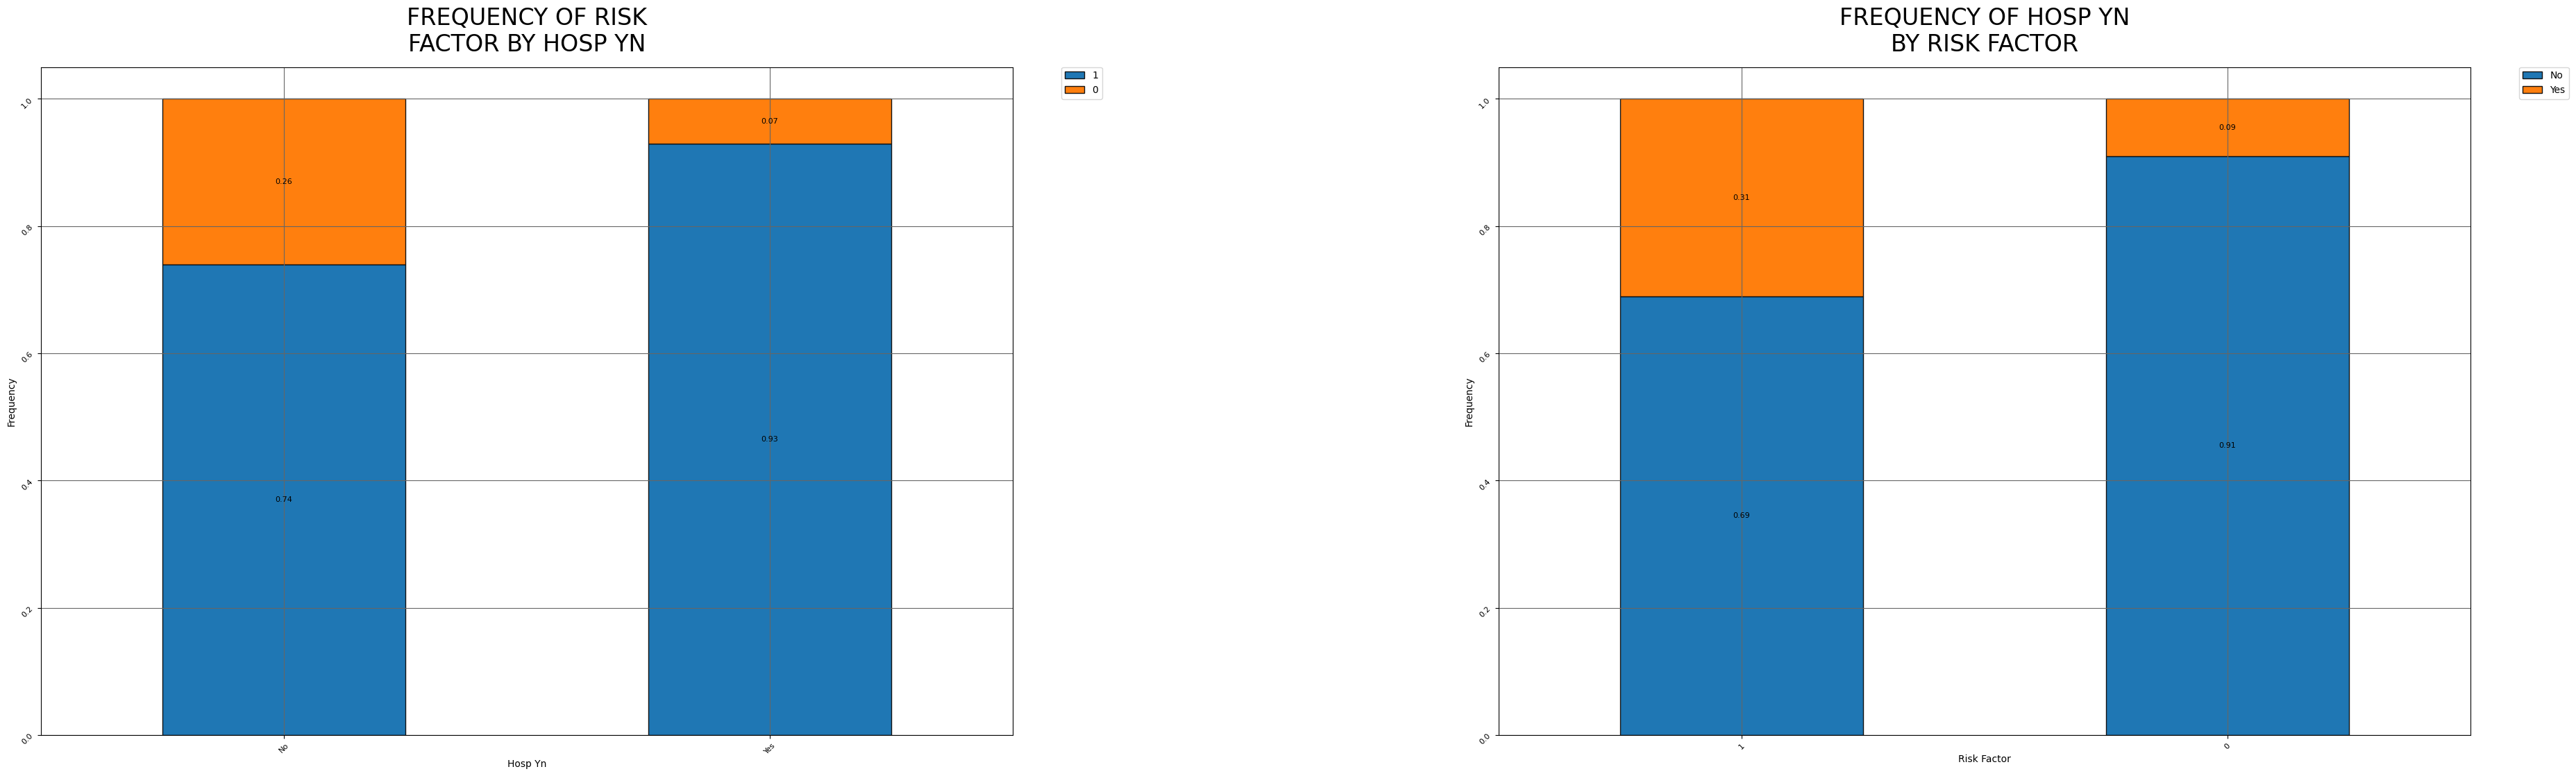

In [273]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 12.5), facecolor=facecolor)

createStackedBarChart(data_to_transform3, 'risk_factor', 'hosp_yn', axs=axs, j=0)
createStackedBarChart(data_to_transform3, 'hosp_yn', 'risk_factor', axs=axs, j=1)

plt.subplots_adjust(left=0.1, right=1.5, wspace=0.5, hspace=0.5)

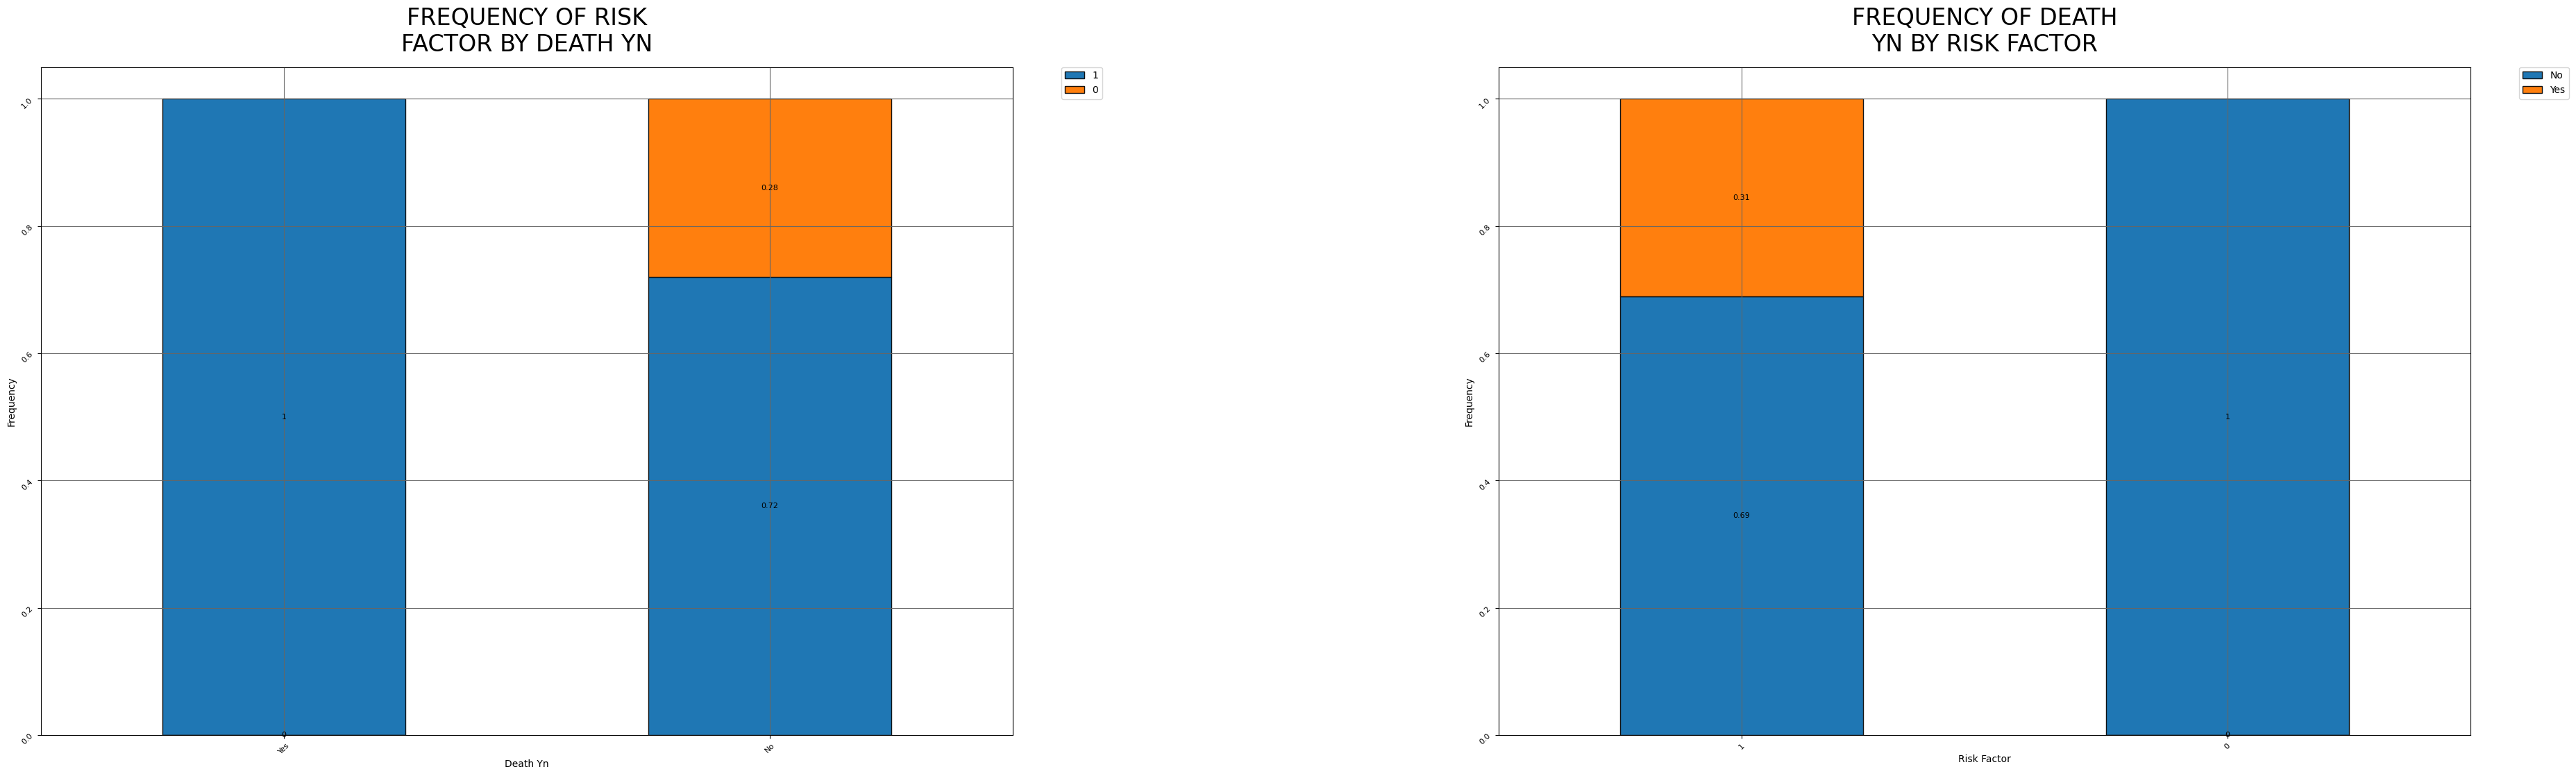

In [274]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 12.5), facecolor=facecolor)

createStackedBarChart(data_to_transform3, 'risk_factor', 'death_yn', axs=axs, j=0)
createStackedBarChart(data_to_transform3, 'death_yn', 'risk_factor', axs=axs, j=1)

plt.subplots_adjust(left=0.1, right=1.5, wspace=0.5, hspace=0.5)

In [275]:
data_to_transform3['risk_factor'] = data_to_transform3['risk_factor'].astype('Int64')

**Running Analysis**  
There is a VERY STRONG correlation between the risk factor we've created and hospitalization and death. A person in one of the at risk categories is more likely to be hospitalized but even more interestingly, in this dataset, NO PATIENT with a risk factor of 0 died.

## Features 4 & 5

We will add two more features to the dataset to capture correlations in time of the year with Covid deaths. We will add a column for Month of the Year and Season.

In [276]:
data_to_transform4 = data_to_transform3.copy()

data_to_transform4['month_of_year'] = 'None'
data_to_transform4['season'] = 'None'

# Extracting month from 'case_month' column
data_to_transform4['month_of_year'] = data_to_transform4['case_month'].dt.month.astype('uint8')

# Extracting season from 'case_month' column
data_to_transform4['season'] = (data_to_transform4['case_month'].dt.month % 12 + 3) // 3
season_names = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
data_to_transform4['season'] = data_to_transform4['season'].map(season_names).astype('category')

data_to_transform4

case_month  county_fips_code       age_group     sex   race  \
0     2020-12-01             24021       65+ years    Male  White   
1     2021-12-01              6059       65+ years    Male  White   
2     2020-01-01             13000       65+ years    Male  White   
3     2020-11-01             20173       65+ years    Male  White   
4     2020-07-01             48201       65+ years    Male  White   
...          ...               ...             ...     ...    ...   
18971 2020-12-01             40115       65+ years  Female  Asian   
18972 2020-10-01             40017    0 - 17 years  Female  White   
18973 2021-01-01             39139  18 to 49 years    Male  White   
18974 2020-12-01             40041    0 - 17 years  Female  Asian   
18975 2020-11-01             40000       65+ years    Male  White   

                 ethnicity  case_positive_specimen_interval  \
0      Non-Hispanic/Latino                                0   
1      Non-Hispanic/Latino                                0   
2      Non-Hispanic/Latino                                0   
3      Non-Hispanic/Latino                                0   
4      Non-Hispanic/Latino                                0   
...                    ...                              ...   
18971  Non-Hispanic/Latino                             <NA>   
18972  Non-Hispanic/Latino                             <NA>   
18973  Non-Hispanic/Latino                             <NA>   
18974  Non-Hispanic/Latino                             <NA>   
18975  Non-Hispanic/Latino                             <NA>   

       case_onset_interval             current_status symptom_status hosp_yn  \
0                        0  Laboratory-confirmed case    Symptomatic      No   
1                       10  Laboratory-confirmed case    Symptomatic     Yes   
2                        0  Laboratory-confirmed case    Symptomatic     Yes   
3                        0  Laboratory-confirmed case    Symptomatic     Yes   
4                        3  Laboratory-confirmed case    Symptomatic     Yes   
...                    ...                        ...            ...     ...   
18971                 <NA>              Probable Case   Asymptomatic      No   
18972                 <NA>              Probable Case   Asymptomatic      No   
18973                 <NA>              Probable Case   Asymptomatic      No   
18974                 <NA>              Probable Case   Asymptomatic      No   
18975                 <NA>              Probable Case   Asymptomatic      No   

      death_yn  income  people_vaccinated  risk_factor  month_of_year  season  
0          Yes   97730            5566951            1             12  Winter  
1          Yes   90234          244166911            1             12  Winter  
2          Yes   51347                  0            1              1  Winter  
3          Yes   56524                  0            1             11  Autumn  
4          Yes   61705                  0            1              7  Summer  
...        ...     ...                ...          ...            ...     ...  
18971       No   39872            5566951            1             12  Winter  
18972       No   72056                  0            0             10  Autumn  
18973       No   49547           29890726            1              1  Winter  
18974       No   41696            5566951            0             12  Winter  
18975       No   51347                  0            1             11  Autumn  

[18976 rows x 17 columns]

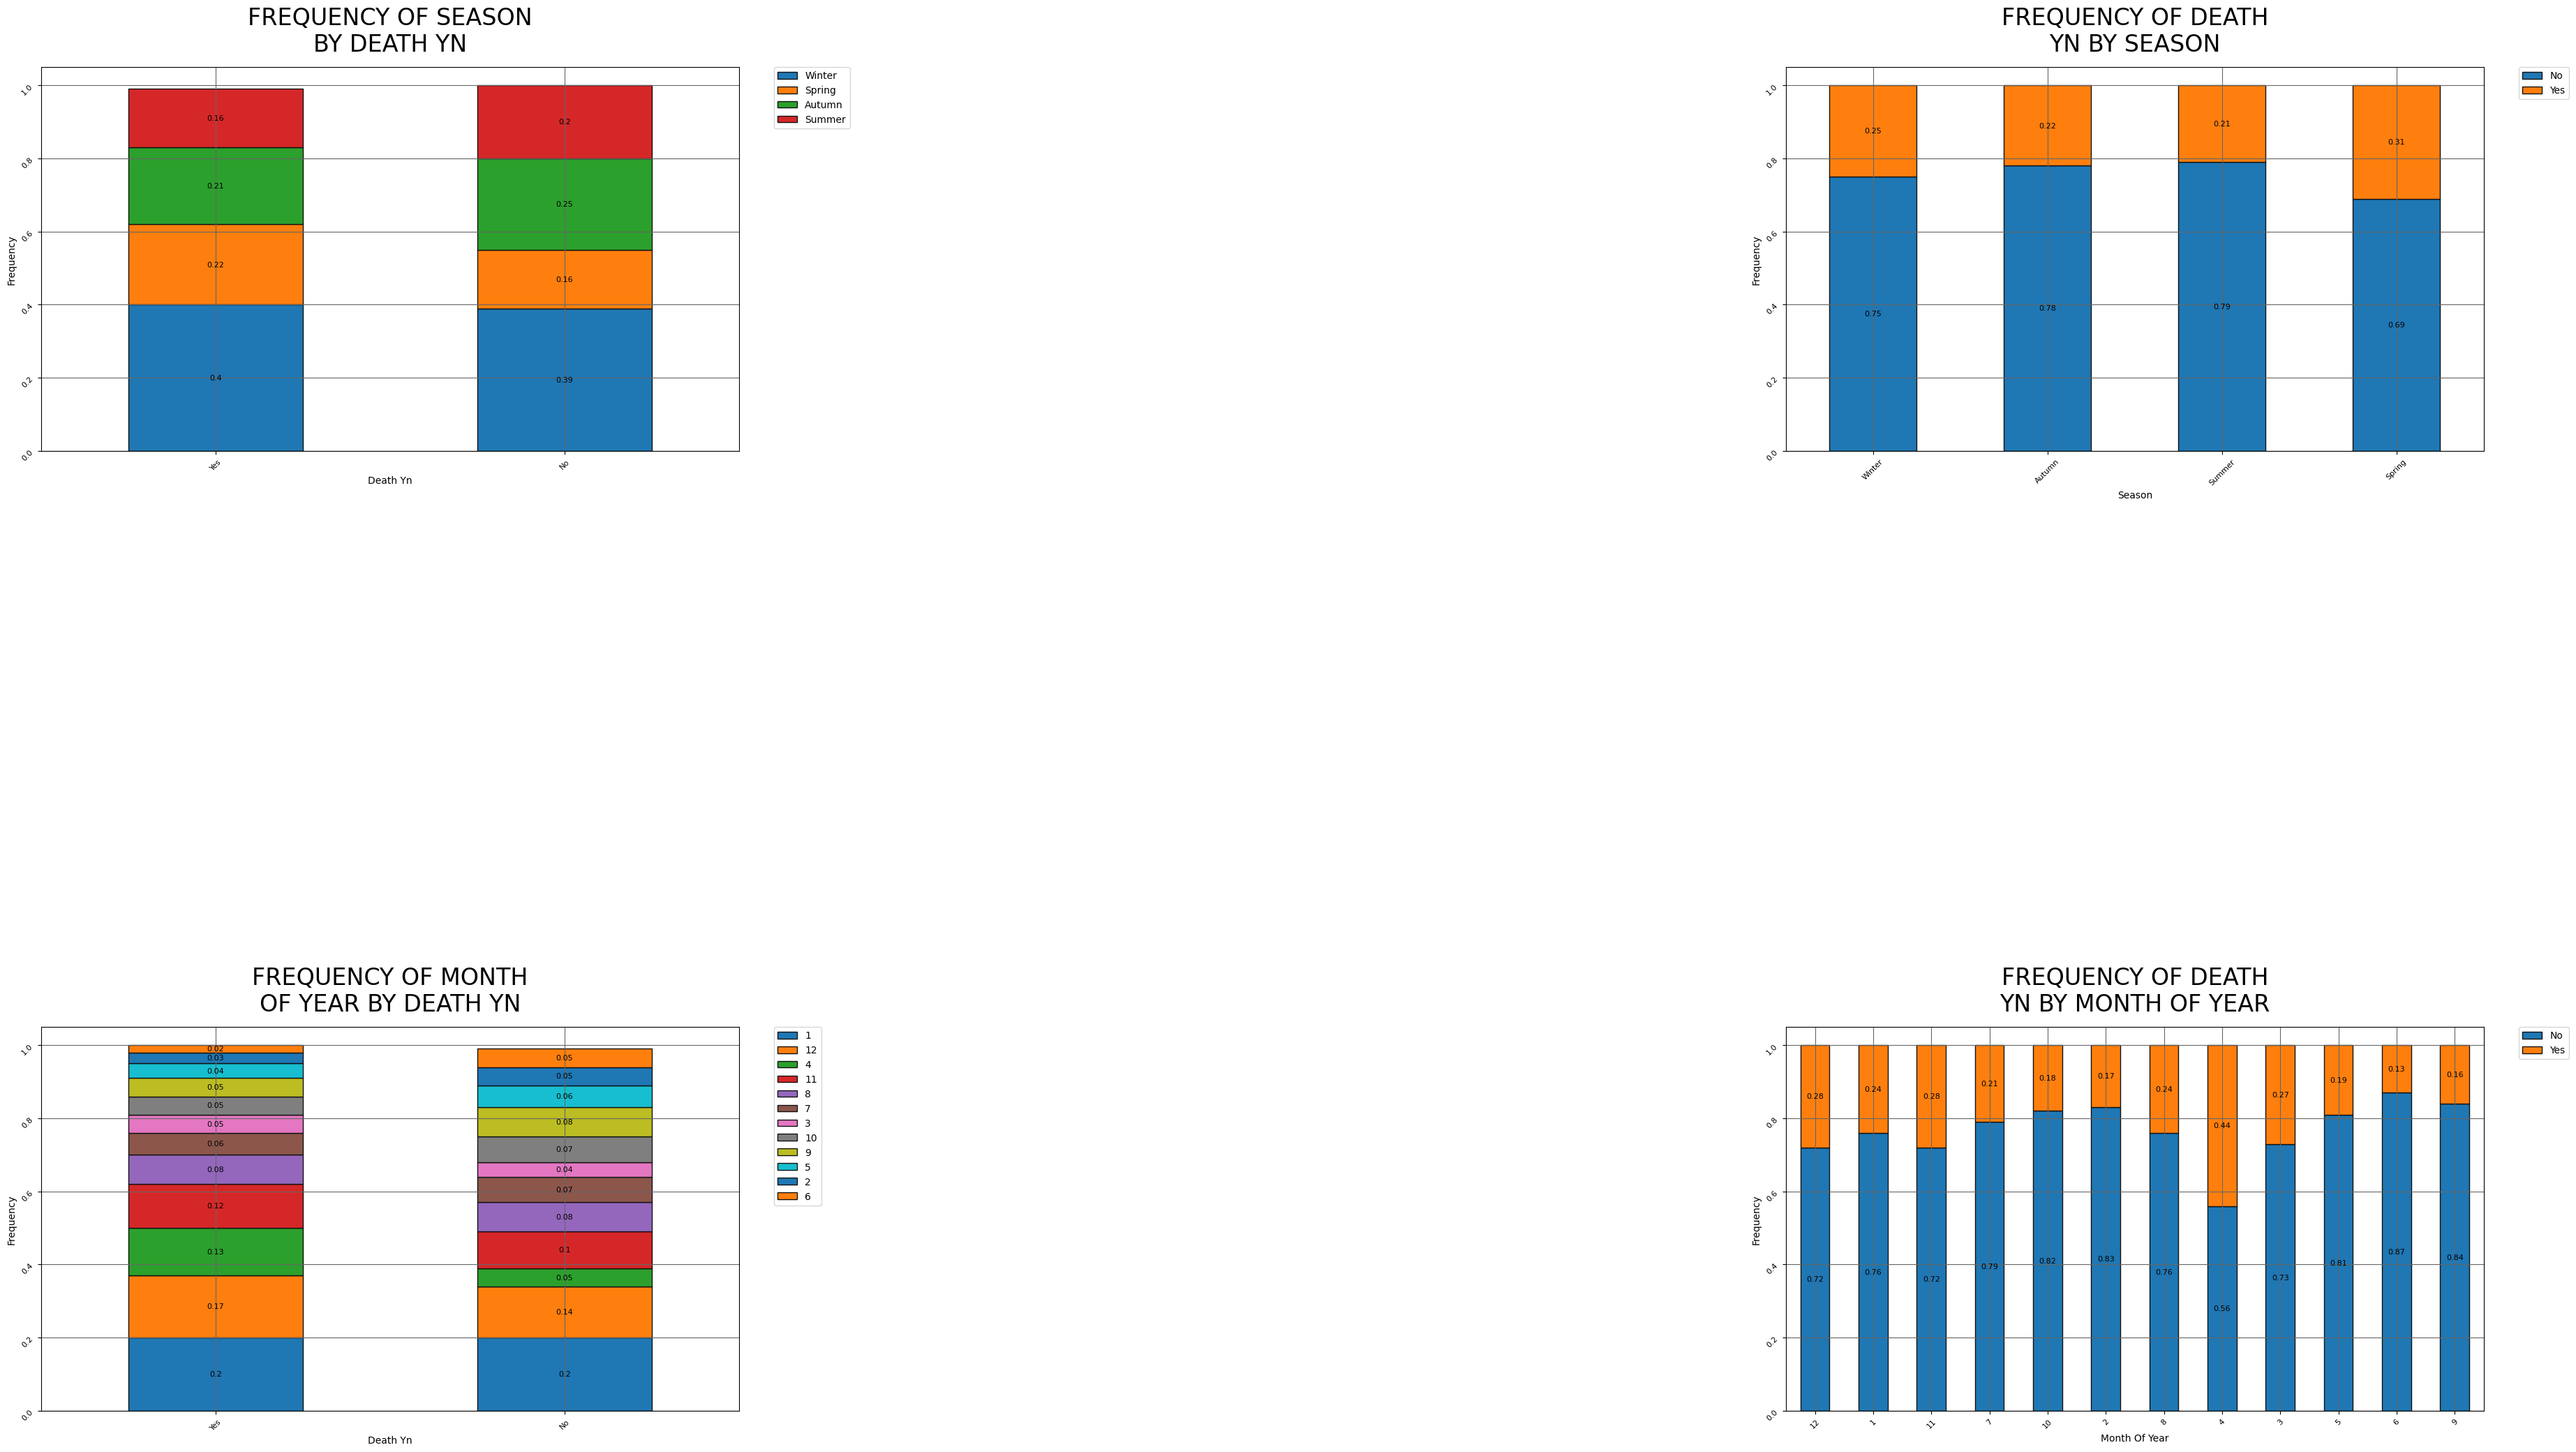

In [277]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25, 25))

createStackedBarChart(data_to_transform4, 'season', 'death_yn', axs=axs, i=0, j=0)
createStackedBarChart(data_to_transform4, 'death_yn', 'season', axs=axs, i=0, j=1)
createStackedBarChart(data_to_transform4, 'month_of_year', 'death_yn', axs=axs, i=1, j=0)
createStackedBarChart(data_to_transform4, 'death_yn', 'month_of_year', axs=axs, i =1, j=1)

# To Finish - Print Data Types, Descriptive tables, Save to csv

In [278]:
final_data = data_to_transform4.copy()

In [279]:
final_data.dtypes

case_month                         datetime64[ns]
county_fips_code                            int64
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
current_status                           category
symptom_status                           category
hosp_yn                                  category
death_yn                                 category
income                                      Int64
people_vaccinated                           Int64
risk_factor                                 Int64
month_of_year                               uint8
season                                   category
dtype: object

In [280]:
# Print table with continuous statistics
continuous_columns = final_data.select_dtypes(['int64','float64','datetime64[ns]', 'uint8']).columns
final_data[continuous_columns].describe(datetime_is_numeric=True).T

count                           mean  \
case_month                         18976  2021-06-05 13:42:08.499156992   
county_fips_code                 18976.0                   29818.870784   
case_positive_specimen_interval  17733.0                       0.309592   
case_onset_interval              18734.0                       0.171827   
income                           18976.0                   65423.742886   
people_vaccinated                18976.0               137403807.764281   
risk_factor                      18976.0                       0.790261   
month_of_year                    18976.0                       6.620099   

                                                 min                  25%  \
case_month                       2020-01-01 00:00:00  2020-12-01 00:00:00   
county_fips_code                              1000.0              20000.0   
case_positive_specimen_interval                  0.0                  0.0   
case_onset_interval                              0.0                  0.0   
income                                       26272.0              51641.5   
people_vaccinated                                0.0            5566951.0   
risk_factor                                      0.0                  1.0   
month_of_year                                    1.0                  3.0   

                                                 50%                  75%  \
case_month                       2021-07-01 00:00:00  2022-01-01 00:00:00   
county_fips_code                             34013.0              37195.0   
case_positive_specimen_interval                  0.0                  0.0   
case_onset_interval                              0.0                  0.0   
income                                       60388.0              73368.0   
people_vaccinated                        193187450.0          251497361.0   
risk_factor                                      1.0                  1.0   
month_of_year                                    7.0                 11.0   

                                                 max               std  
case_month                       2022-11-01 00:00:00               NaN  
county_fips_code                             78000.0      13260.777527  
case_positive_specimen_interval                 70.0          1.849826  
case_onset_interval                             52.0          1.256041  
income                                      142299.0      17728.039763  
people_vaccinated                        267676647.0  113693637.226052  
risk_factor                                      1.0          0.407133  
month_of_year                                   12.0          4.021984

In [281]:
# Print table with categorical statistics
final_data.select_dtypes(['category']).describe().T

count unique                        top   freq
age_group       18976      4             18 to 49 years   7396
sex             18976      2                     Female   9918
race            18976      6                      White  14748
ethnicity       18976      2        Non-Hispanic/Latino  16797
current_status  18976      2  Laboratory-confirmed case  17733
symptom_status  18976      2                Symptomatic  18734
hosp_yn         18976      2                         No  13930
death_yn        18976      2                         No  14373
season          18976      4                     Winter   7491

In [282]:
# Write the cleaned dataframe to a csv file
final_data.to_csv('data\covid19-cdc-18389156_final_assignment2.csv', index=False)